In this notebook, I'm playing the role of a Data Scientist working in a betting company, which is considering entering football market.

The goals of the notebook are:

- Answer predefined questions from management.
- Improve the teams understanding of football by providing insights on leagues, teams, players and positions.
- Analyze the competion. How well do they predict match outcomes?
- Build Machine Learning models to predicting:
  - goals scored for each team;
  - match outcomes (Win, Loose, Draw).

Hypothesis to be tested:

- Is there such a thing as home advantage?
- Teams with higher defensive tendencies and lower buildup tendencies are more likely to perform better.

Link to the dataset: https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european

Link to Google Looker Studio Dashboard: https://lookerstudio.google.com/reporting/2acb7bbd-6f30-4122-afec-104626c11da9


In [1]:
import sqlite3
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import bisect

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    mean_absolute_error,
    classification_report,
    confusion_matrix,
)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE


import my_functions as my

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
con = sqlite3.connect("database.sqlite")
cur = con.cursor()

In [4]:
table_names = cur.execute(
    'SELECT name from sqlite_master where type= "table"'
).fetchall()

i = 0
for table_name in table_names:
    # name cleaning
    table_names[i] = table_name[0]
    i = i + 1

print(table_names)

['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes']


In [5]:
def check_table(table):
    scheme = cur.execute(f"PRAGMA table_info({table})").fetchall()
    print(f"{table} table")

    for column in scheme:
        print(column)
    print("")

# 1. Data Cleaning


In [6]:
def count_missing_values(df):
    """Counts the number of missing values by column"""
    missing_data = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    missing_df = pd.DataFrame(
        {"Missing Values": missing_data, "Percentage": missing_percentage}
    )

    missing_df = missing_df[missing_df["Missing Values"] > 0].sort_values(
        by="Percentage", ascending=False
    )
    return missing_df

In [7]:
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 1000)

## 1.1. Match data


In [8]:
match_data = pd.read_sql("SELECT * FROM Match", con, index_col="id")
match_data.head(2)

country_id  league_id     season  stage                 date  \
id                                                                 
1            1          1  2008/2009      1  2008-08-17 00:00:00   
2            1          1  2008/2009      1  2008-08-16 00:00:00   

    match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
id                                                                     
1         492473              9987              9993               1   
2         492474             10000              9994               0   

    away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
id                                                                   
1                1             NaN             NaN             NaN   
2                0             NaN             NaN             NaN   

    home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
id                                                                   
1              NaN             NaN             NaN             NaN   
2              NaN             NaN             NaN             NaN   

    home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
id                                                                     
1              NaN             NaN              NaN              NaN   
2              NaN             NaN              NaN              NaN   

    away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
id                                                                   
1              NaN             NaN             NaN             NaN   
2              NaN             NaN             NaN             NaN   

    away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
id                                                                   
1              NaN             NaN             NaN             NaN   
2              NaN             NaN             NaN             NaN   

    away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
id                                                                     
1              NaN              NaN              NaN             NaN   
2              NaN              NaN              NaN             NaN   

    home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
id                                                                   
1              NaN             NaN             NaN             NaN   
2              NaN             NaN             NaN             NaN   

    home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
id                                                                   
1              NaN             NaN             NaN             NaN   
2              NaN             NaN             NaN             NaN   

    home_player_Y10  home_player_Y11  away_player_Y1  away_player_Y2  \
id                                                                     
1               NaN              NaN             NaN             NaN   
2               NaN              NaN             NaN             NaN   

    away_player_Y3  away_player_Y4  away_player_Y5  away_player_Y6  \
id                                                                   
1              NaN             NaN             NaN             NaN   
2              NaN             NaN             NaN             NaN   

    away_player_Y7  away_player_Y8  away_player_Y9  away_player_Y10  \
id                                                                    
1              NaN             NaN             NaN              NaN   
2              NaN             NaN             NaN              NaN   

    away_player_Y11  home_player_1  home_player_2  home_player_3  \
id                                                                 
1               NaN            NaN            NaN            NaN   
2               NaN            NaN            NaN            NaN   

    home_player_4  home_player_5  home_player_6  h

In [9]:
bet_cols = match_data.columns[-30:]
print(
    f"""The last {len(bet_cols)} in the Match table are odds provided by the betting companies for the following outcomes:
      H - Home team Win
      D - Draw
      A - Away team Win
      """
)
print(
    "The columns are:",
    *bet_cols,
    f"\n giving us {int(len(bet_cols)/3)} betting companies.",
)

The last 30 in the Match table are odds provided by the betting companies for the following outcomes:
      H - Home team Win
      D - Draw
      A - Away team Win
      
The columns are: B365H B365D B365A BWH BWD BWA IWH IWD IWA LBH LBD LBA PSH PSD PSA WHH WHD WHA SJH SJD SJA VCH VCD VCA GBH GBD GBA BSH BSD BSA 
 giving us 10 betting companies.


In [10]:
missing_df = count_missing_values(match_data)
missing_df[
    (missing_df["Percentage"] >= 5)
    & (~missing_df.index.isin(bet_cols))  # excluding missing betting odds
].T

card   possession       corner      shotoff  \
Missing Values  11762.00000  11762.00000  11762.00000  11762.00000   
Percentage         45.27503     45.27503     45.27503     45.27503   

                      cross   foulcommit       shoton         goal  \
Missing Values  11762.00000  11762.00000  11762.00000  11762.00000   
Percentage         45.27503     45.27503     45.27503     45.27503   

                away_player_Y11  away_player_X11  away_player_X9  \
Missing Values      1839.000000      1839.000000     1833.000000   
Percentage             7.078794         7.078794        7.055699   

                away_player_Y9  away_player_Y10  away_player_X10  \
Missing Values     1833.000000      1833.000000      1833.000000   
Percentage            7.055699         7.055699         7.055699   

                home_player_X10  away_player_X4  away_player_X3  \
Missing Values       1832.00000      1832.00000      1832.00000   
Percentage              7.05185         7.05185         7.05185   

                away_player_X2  away_player_X1  home_player_X11  \
Missing Values      1832.00000      1832.00000       1832.00000   
Percentage             7.05185         7.05185          7.05185   

                home_player_X7  home_player_X9  home_player_X8  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                away_player_X6  home_player_X6  home_player_X5  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                home_player_X4  home_player_X3  away_player_X5  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                away_player_Y3  away_player_X7  away_player_X8  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                away_player_Y5  away_player_Y6  away_player_Y2  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                away_player_Y8  away_player_Y1  home_player_Y11  \
Missing Values      1832.00000      1832.00000       1832.00000   
Percentage             7.05185         7.05185          7.05185   

                home_player_Y10  home_player_Y9  home_player_Y8  \
Missing Values       1832.00000      1832.00000      1832.00000   
Percentage              7.05185         7.05185         7.05185   

                home_player_Y7  home_player_Y6  home_player_Y5  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                home_player_Y4  home_player_Y3  away_player_Y4  \
Missing Values      1832.00000      1832.00000      1832.00000   
Percentage             7.05185         7.05185         7.05185   

                away_player_Y7  home_player_X1  home_player_Y1  \
Missing Values      1832.00000     1821.000000     1821.000000   
Percentage             7.05185        7.009508        7.009508   

                home_player_Y2  home_player_X2  home_player_11  \
Missing Values     1821.000000     1821.000000     1555.000000   
Percentage            7.009508        7.009508        5.985604   

                away_player_11  away_player_10  home_player_10  away_player_8  \
Missing Values     1554.000000     1441.000000     1436.000000    1341.000000   
Percentage            5.981754        5.546788        5.527541       5.161862   

                away_player_5  away_player_9  home_player_6  home_player_4  \
Missing Values    1335.000000    1328.000000    1325.000000    1323.000000   
Percentage           5.138766       5.111821       5.100273       5.092575   

                away_player_4  home_player_5  home_player_2  away_player_6  \
Missing Values    1321.000000     1

For ~45% of the matches in the database, we are missing match statistics such as goal info, cards, possession of the ball, corners, shotoffs, etc..

Moreover, for >5% of the matches we don't know all the player_ids, and for 7% of the matches we don't know the positions of the players in their team formations.


In [11]:
match_data.index.name = "match_id"
match_data = match_data.rename(
    columns={"home_team_api_id": "home_team_id", "away_team_api_id": "away_team_id"}
)
match_data["date"] = pd.to_datetime(match_data["date"])

print("Number of duplicates:", match_data.duplicated().sum())

Number of duplicates: 0


In [12]:
match_data = match_data.sort_values(
    by=["season", "league_id", "date"], ascending=[True, True, True]
)

### Feature Engineering


Now that we have the dataframe somewhat cleaned up, let's do some feature engineering that will be useful in the future. We will be adding:

- total number of goals
- outcome of the game (Win, Loose, Draw) for the home team.


In [13]:
match_data["total_goals"] = match_data["home_team_goal"] + match_data["away_team_goal"]
match_data["win_margin"] = abs(
    match_data["home_team_goal"] - match_data["away_team_goal"]
)

conditions = [
    match_data["home_team_goal"] > match_data["away_team_goal"],  # Home Win
    match_data["home_team_goal"] < match_data["away_team_goal"],  # Away Win
    match_data["home_team_goal"] == match_data["away_team_goal"],  # Draw
]

choices_winner = ["Home", "Away", "Draw"]
choices_home_points = [3, 0, 1]
choices_away_points = [0, 3, 1]

match_data["winner"] = np.select(conditions, choices_winner)
match_data["home_team_points"] = np.select(conditions, choices_home_points)
match_data["away_team_points"] = np.select(conditions, choices_away_points)

## 1.2. Teams data


Now let's inspect the data we have on Football teams. In the SQL database, we have two tables tha have information on Football teams:

- _Team_ table - ids and names.
- _Team_Attributes_ table - holds attributes for teams by date, taken from FIFA games.

We will be joining these tables to create one dataframe.


In [14]:
query = """
        SELECT *
        FROM Team T
        JOIN Team_Attributes TA ON TA.team_api_id = T.team_api_id;
        """

teams = pd.read_sql(query, con)
print(teams.shape)

missing_team_data = count_missing_values(teams)
missing_team_data

(1458, 30)


Missing Values  Percentage
buildUpPlayDribbling             969   66.460905

In the whole dataframe only the '**buildUpPlayDribbling**' column has missing values. Since over 65% rows have missing values, we'll be dropping this feature. We'll also be removing the redundant id columns, as there are ones that are duplicated or unnecessary for the analysis.


In [15]:
teams = teams.drop(columns=["buildUpPlayDribbling", "id", "team_fifa_api_id"])
teams = teams.T.drop_duplicates().T  # for removing duplicate team_api_id column
teams = teams.rename(columns={"team_api_id": "team_id"})
teams["date"] = pd.to_datetime(teams["date"])
teams = teams.drop_duplicates()
teams.head(5)

team_id team_long_name team_short_name       date buildUpPlaySpeed  \
0    9930       FC Aarau             AAR 2010-02-22               60   
1    9930       FC Aarau             AAR 2014-09-19               52   
2    9930       FC Aarau             AAR 2015-09-10               47   
3    8485       Aberdeen             ABE 2010-02-22               70   
4    8485       Aberdeen             ABE 2011-02-22               47   

  buildUpPlaySpeedClass buildUpPlayDribblingClass buildUpPlayPassing  \
0              Balanced                    Little                 50   
1              Balanced                    Normal                 56   
2              Balanced                    Normal                 54   
3                  Fast                    Little                 70   
4              Balanced                    Little                 52   

  buildUpPlayPassingClass buildUpPlayPositioningClass chanceCreationPassing  \
0                   Mixed                   Organised                    60   
1                   Mixed                   Organised                    54   
2                   Mixed                   Organised                    54   
3                    Long                   Organised                    70   
4                   Mixed                   Organised                    53   

  chanceCreationPassingClass chanceCreationCrossing  \
0                     Normal                     65   
1                     Normal                     63   
2                     Normal                     63   
3                      Risky                     70   
4                     Normal                     48   

  chanceCreationCrossingClass chanceCreationShooting  \
0                      Normal                     55   
1                      Normal                     64   
2                      Normal                     64   
3                        Lots                     70   
4                      Normal                     52   

  chanceCreationShootingClass chanceCreationPositioningClass defencePressure  \
0                      Normal                      Organised              50   
1                      Normal                      Organised              47   
2                      Normal                      Organised              47   
3                        Lots                      Organised              60   
4                      Normal                      Organised              47   

  defencePressureClass defenceAggression defenceAggressionClass  \
0               Medium                55                  Press   
1               Medium                44                  Press   
2               Medium                44                  Press   
3               Medium                70                 Double   
4               Medium                47                  Press   

  defenceTeamWidth defenceTeamWidthClass defenceDefenderLineClass  
0               45                Normal                    Cover  
1               54                Normal                    Cover  
2               54                Normal                    Cover  
3               70                  Wide                    Cover  
4               52                Normal                    Cover

In [16]:
# for more efficient 'team_id' and 'team_long_name' mapping
unique_teams = (
    teams.sort_values(by="date", ascending=False)
    .drop_duplicates(subset="team_id", keep="first")[["team_id", "team_long_name"]]
    .reset_index(drop=True)
)

In [17]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1457
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   team_id                         1457 non-null   object        
 1   team_long_name                  1457 non-null   object        
 2   team_short_name                 1457 non-null   object        
 3   date                            1457 non-null   datetime64[ns]
 4   buildUpPlaySpeed                1457 non-null   object        
 5   buildUpPlaySpeedClass           1457 non-null   object        
 6   buildUpPlayDribblingClass       1457 non-null   object        
 7   buildUpPlayPassing              1457 non-null   object        
 8   buildUpPlayPassingClass         1457 non-null   object        
 9   buildUpPlayPositioningClass     1457 non-null   object        
 10  chanceCreationPassing           1457 non-null   object        
 11  chan

For some reason, even numeric columns are stored as objects, so we will need to change the data types.


In [18]:
numeric_team_columns = [
    "buildUpPlaySpeed",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
]

In [19]:
for col in numeric_team_columns:
    teams[col] = pd.to_numeric(teams[col], errors="coerce")

## 1.3. Player Data


Similarly as with Teams, we have two tables holding data on players:

- _Player_ - id, name, birthday, height, weight
- _Player_Attributes_ - player attributes by date from the FIFA games.


In [20]:
query = """
        SELECT *
        FROM Player P
        JOIN Player_Attributes PA ON PA.player_api_id = P.player_api_id;
        """

players = pd.read_sql(query, con)

missing_player_data = count_missing_values(players)
missing_player_data.T

attacking_work_rate      balance       vision      agility  \
Missing Values          3230.000000  2713.000000  2713.000000  2713.000000   
Percentage                 1.755645     1.474633     1.474633     1.474633   

                sliding_tackle      volleys      jumping        curve  \
Missing Values     2713.000000  2713.000000  2713.000000  2713.000000   
Percentage            1.474633     1.474633     1.474633     1.474633   

                  strength  long_shots  aggression  interceptions  \
Missing Values  836.000000  836.000000  836.000000     836.000000   
Percentage        0.454402    0.454402    0.454402       0.454402   

                positioning     marking   penalties  standing_tackle  \
Missing Values   836.000000  836.000000  836.000000       836.000000   
Percentage         0.454402    0.454402    0.454402         0.454402   

                 gk_diving  gk_handling  gk_kicking  gk_positioning  \
Missing Values  836.000000   836.000000  836.000000      836.000000   
Percentage        0.454402     0.454402    0.454402        0.454402   

                   stamina  overall_rating  shot_power   potential  \
Missing Values  836.000000      836.000000  836.000000  836.000000   
Percentage        0.454402        0.454402    0.454402    0.454402   

                 reactions  sprint_speed  acceleration  ball_control  \
Missing Values  836.000000    836.000000    836.000000    836.000000   
Percentage        0.454402      0.454402      0.454402      0.454402   

                long_passing  free_kick_accuracy   dribbling  short_passing  \
Missing Values    836.000000          836.000000  836.000000     836.000000   
Percentage          0.454402            0.454402    0.454402       0.454402   

                heading_accuracy   finishing    crossing  defensive_work_rate  \
Missing Values        836.000000  836.000000  836.000000           836.000000   
Percentage              0.454402    0.454402    0.454402             0.454402   

                preferred_foot  gk_reflexes  
Missing Values      836.000000   836.000000  
Percentage            0.454402     0.454402

In [21]:
players = players.drop(columns=["id", "player_fifa_api_id"])
players = players.T.drop_duplicates().T  # this line takes > 1 min to run.
players = players.rename(columns={"player_api_id": "player_id"})

players["date"] = pd.to_datetime(players["date"])
players["birthday"] = pd.to_datetime(players["birthday"])
players["weight"] = players["weight"] / 2.205  # converting from pounds to kg

players = players.drop_duplicates()

players.head(3)

player_id         player_name   birthday  height     weight       date  \
0    505942  Aaron Appindangoye 1992-02-29  182.88  84.807256 2016-02-18   
1    505942  Aaron Appindangoye 1992-02-29  182.88  84.807256 2015-11-19   
2    505942  Aaron Appindangoye 1992-02-29  182.88  84.807256 2015-09-21   

  overall_rating potential preferred_foot attacking_work_rate  \
0           67.0      71.0          right              medium   
1           67.0      71.0          right              medium   
2           62.0      66.0          right              medium   

  defensive_work_rate crossing finishing heading_accuracy short_passing  \
0              medium     49.0      44.0             71.0          61.0   
1              medium     49.0      44.0             71.0          61.0   
2              medium     49.0      44.0             71.0          61.0   

  volleys dribbling curve free_kick_accuracy long_passing ball_control  \
0    44.0      51.0  45.0               39.0         64.0         49.0   
1    44.0      51.0  45.0               39.0         64.0         49.0   
2    44.0      51.0  45.0               39.0         64.0         49.0   

  acceleration sprint_speed agility reactions balance shot_power jumping  \
0         60.0         64.0    59.0      47.0    65.0       55.0    58.0   
1         60.0         64.0    59.0      47.0    65.0       55.0    58.0   
2         60.0         64.0    59.0      47.0    65.0       55.0    58.0   

  stamina strength long_shots aggression interceptions positioning vision  \
0    54.0     76.0       35.0       71.0          70.0        45.0   54.0   
1    54.0     76.0       35.0       71.0          70.0        45.0   54.0   
2    54.0     76.0       35.0       63.0          41.0        45.0   54.0   

  penalties marking standing_tackle sliding_tackle gk_diving gk_handling  \
0      48.0    65.0            69.0           69.0       6.0        11.0   
1      48.0    65.0            69.0           69.0       6.0        11.0   
2      48.0    65.0            66.0           69.0       6.0        11.0   

  gk_kicking gk_positioning gk_reflexes  
0       10.0            8.0         8.0  
1       10.0            8.0         8.0  
2       10.0            8.0         8.0

As with **teams** dataframe, some numeric columns are classified as objects, so we need to convert them.


In [22]:
non_numeric_cols = [
    "player_name",
    "birthday",
    "date",
    "preferred_foot",
    "attacking_work_rate",
    "defensive_work_rate",
    "player_id",
]

for col in players.columns:
    if col not in non_numeric_cols:
        players[col] = pd.to_numeric(players[col], errors="coerce", downcast="integer")

## 1.4. Validating ids


In [23]:
home_player_columns = [f"home_player_{i}" for i in range(1, 12)]
away_player_columns = [f"away_player_{i}" for i in range(1, 12)]

players_in_matches = set(match_data[home_player_columns + away_player_columns].stack())

player_ids = set(players["player_id"])

unknown_player_ids = players_in_matches - player_ids

print("Unknown players in Match data:", len(unknown_player_ids))

Unknown players in Match data: 0


In [24]:
teams_in_matches = set(match_data[["home_team_id", "away_team_id"]].stack())
team_ids = set(teams["team_id"])

unknown_team_ids = teams_in_matches - team_ids

print("Unknown team ids in Match data:", len(unknown_team_ids))

Unknown team ids in Match data: 11


In [25]:
games_w_unknown_teams = match_data[
    (match_data["home_team_id"].isin(unknown_team_ids))
    | (match_data["away_team_id"].isin(unknown_team_ids))
]
print(
    f"There are {len(games_w_unknown_teams)} matches were at least one team_id is not in the Teams table."
)

There are 350 matches were at least one team_id is not in the Teams table.


# 2. Exploratory Data Analysis


Let's start by answering some the managements predefined questions:

- 2.1. Which leagues are in which countries?
- 2.2. Which leagues score the most/fewest goals?
- 2.3. Who are the top scorers in each team and league?


## 2.1. Which leagues are in which countries?


In [26]:
check_table("League")

League table
(0, 'id', 'INTEGER', 0, None, 1)
(1, 'country_id', 'INTEGER', 0, None, 0)
(2, 'name', 'TEXT', 0, None, 0)



In [27]:
query = """SELECT L.id AS league_id, L.name league, C.name country
        FROM League L
        JOIN Country C ON L.country_id = C.id
        """

leagues = pd.read_sql_query(query, con=con)
leagues[["league", "country"]]

league      country
0     Belgium Jupiler League      Belgium
1     England Premier League      England
2             France Ligue 1       France
3      Germany 1. Bundesliga      Germany
4              Italy Serie A        Italy
5     Netherlands Eredivisie  Netherlands
6         Poland Ekstraklasa       Poland
7   Portugal Liga ZON Sagres     Portugal
8    Scotland Premier League     Scotland
9            Spain LIGA BBVA        Spain
10  Switzerland Super League  Switzerland

Let's further inspect each league by looking at:

- Number of teams and matches played;
- Season timeline.


In [28]:
query = """SELECT L.name league, M.season, COUNT(M.id) as total_matches, COUNT(DISTINCT M.away_team_api_id) team
        FROM League L
        JOIN Match M ON M.league_id = L.id
        GROUP BY 1, 2
        """

leagues_info = pd.read_sql_query(query, con=con)

df_matches = leagues_info.pivot(
    index="league", columns="season", values="total_matches"
)

df_teams = leagues_info.pivot(index="league", columns="season", values="team")
df_teams

season                    2008/2009  2009/2010  2010/2011  2011/2012  \
league                                                                 
Belgium Jupiler League           18         15         16         16   
England Premier League           20         20         20         20   
France Ligue 1                   20         20         20         20   
Germany 1. Bundesliga            18         18         18         18   
Italy Serie A                    20         20         20         20   
Netherlands Eredivisie           18         18         18         18   
Poland Ekstraklasa               16         16         16         16   
Portugal Liga ZON Sagres         16         16         16         16   
Scotland Premier League          12         12         12         12   
Spain LIGA BBVA                  20         20         20         20   
Switzerland Super League         10         10         10         10   

season                    2012/2013  2013/2014  2014/2015  2015/2016  
league                                                                
Belgium Jupiler League           16          4         16         16  
England Premier League           20         20         20         20  
France Ligue 1                   20         20         20         20  
Germany 1. Bundesliga            18         18         18         18  
Italy Serie A                    20         20         20         20  
Netherlands Eredivisie           18         18         18         18  
Poland Ekstraklasa               16         16         16         16  
Portugal Liga ZON Sagres         16         16         18         18  
Scotland Premier League          12         12         12         12  
Spain LIGA BBVA                  20         20         20         20  
Switzerland Super League         10         10         10         10

From the table above, we see that England, France, Italy and Spain leagues consistently have 20 teams playing each season. Germany and Netherlands leagues consistently have 18 teams playing. Poland, Scotland and Switzerland also don't fluctuate, having 16, 12 and 10 teams respectively.

Portugal expanded it's league from 16 teams to 18 after the 2013/2014 season. Belgium has a very inconsistent number of teams. 2013-2014 shows only 4 teams, however, this is due to missing data, as a quick google search shows that there were in fact 16 teams playing that season. (https://www.soccer24.com/belgium/jupiler-pro-league-2013-2014/#/SYdaMVJH/table/overall)


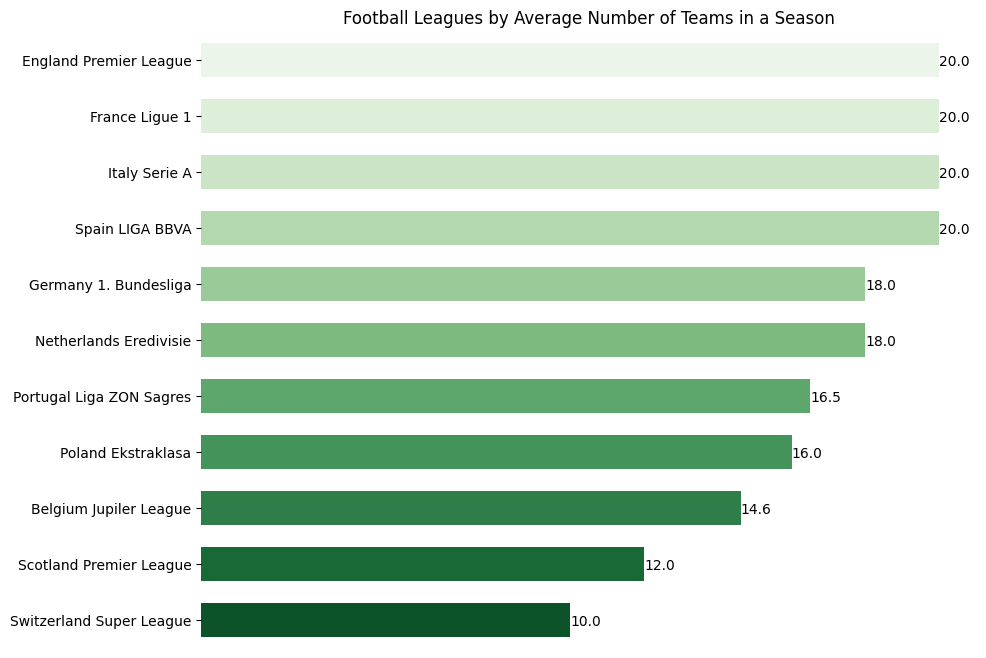

In [29]:
df_teams["avg"] = df_teams.mean(axis=1)

plt.figure(figsize=(10, 8))

my.plot_horiz_barchart(df=df_teams, names="index", values="avg", decimals=1, order=True)
plt.title("Football Leagues by Average Number of Teams in a Season")

plt.show()

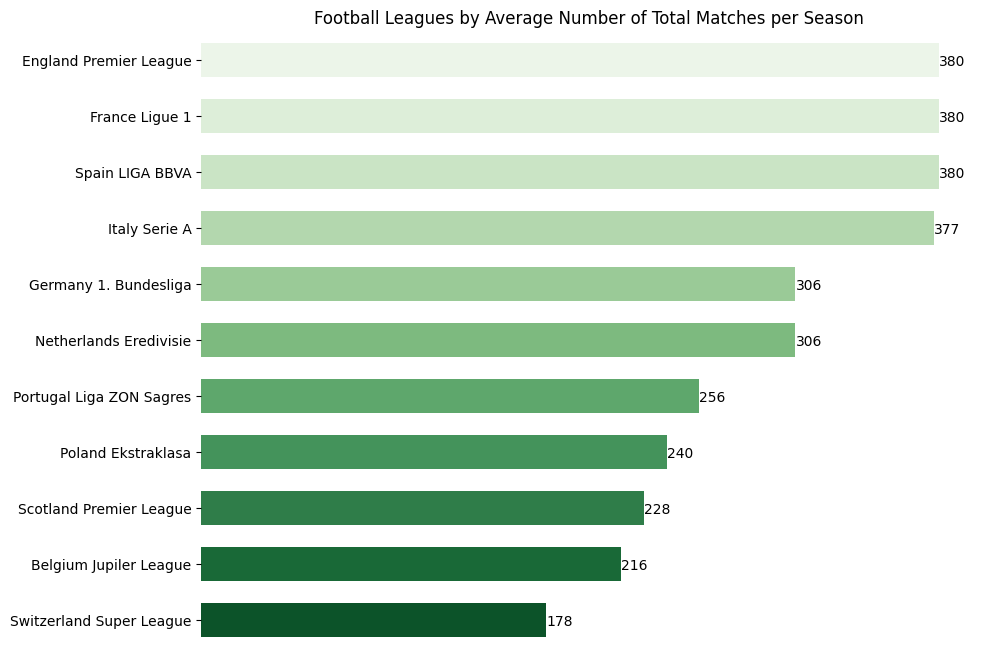

In [30]:
df_matches["avg_per_season"] = df_matches.mean(axis=1)

plt.figure(figsize=(10, 8))

my.plot_horiz_barchart(
    df=df_matches, names="index", values="avg_per_season", order=True
)
plt.title("Football Leagues by Average Number of Total Matches per Season")

plt.show()

Now let's look at the timeline of a season for each league. We will choose the latest year as an example.


In [31]:
season_data = match_data[match_data["season"] == "2015/2016"]

season_dates = (
    season_data.groupby("league_id")["date"].agg(["min", "max"]).reset_index()
)

season_dates["duration"] = (season_dates["max"] - season_dates["min"]).dt.days

season_dates = season_dates.merge(leagues, on="league_id", how="left")

season_dates = season_dates.sort_values(by="duration", ascending=True).drop(
    columns="duration"
)

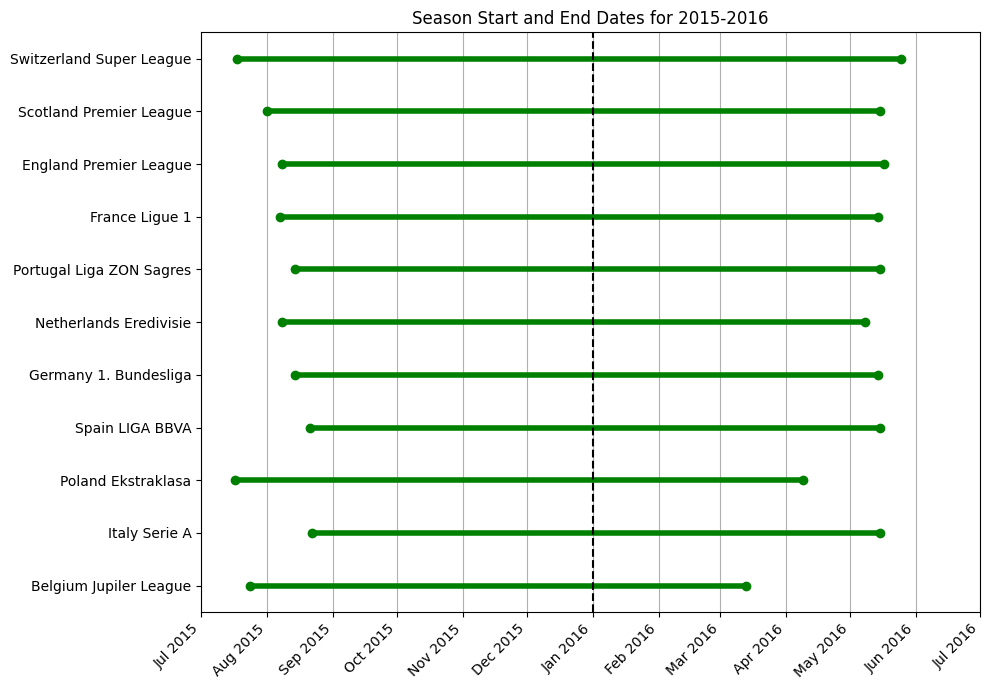

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
for idx, row in season_dates.iterrows():
    ax.plot(
        [row["min"], row["max"]],
        [row["league"], row["league"]],
        marker="o",
        color="green",
        lw=4,
    )


ax.set_xlim(pd.Timestamp("2015-07-01"), pd.Timestamp("2016-07-01"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.grid(True, which="major")
ax.axvline(pd.Timestamp("2016-01-01"), color="black", linestyle="--", lw=1.5)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Season Start and End Dates for 2015-2016")
plt.tight_layout()
plt.show()

All the leagues start arround mid July / mid August. The National league season is shortest for Belgium and Italy leagues and longest for Switzerland and Scotland leagues. Most National league seasons end in the middle of May.


## 2.2. Which leagues score the most/fewest goals?


In [33]:
goals = match_data.groupby("league_id").agg({"total_goals": "sum", "league_id": "size"})

goals = goals.rename(columns={"league_id": "total_matches"})
goals["goals_per_match"] = goals["total_goals"] / goals["total_matches"]

goals = goals.merge(leagues[["league_id", "league"]], on="league_id", how="left")

goals = goals.sort_values(by="goals_per_match", ascending=False)

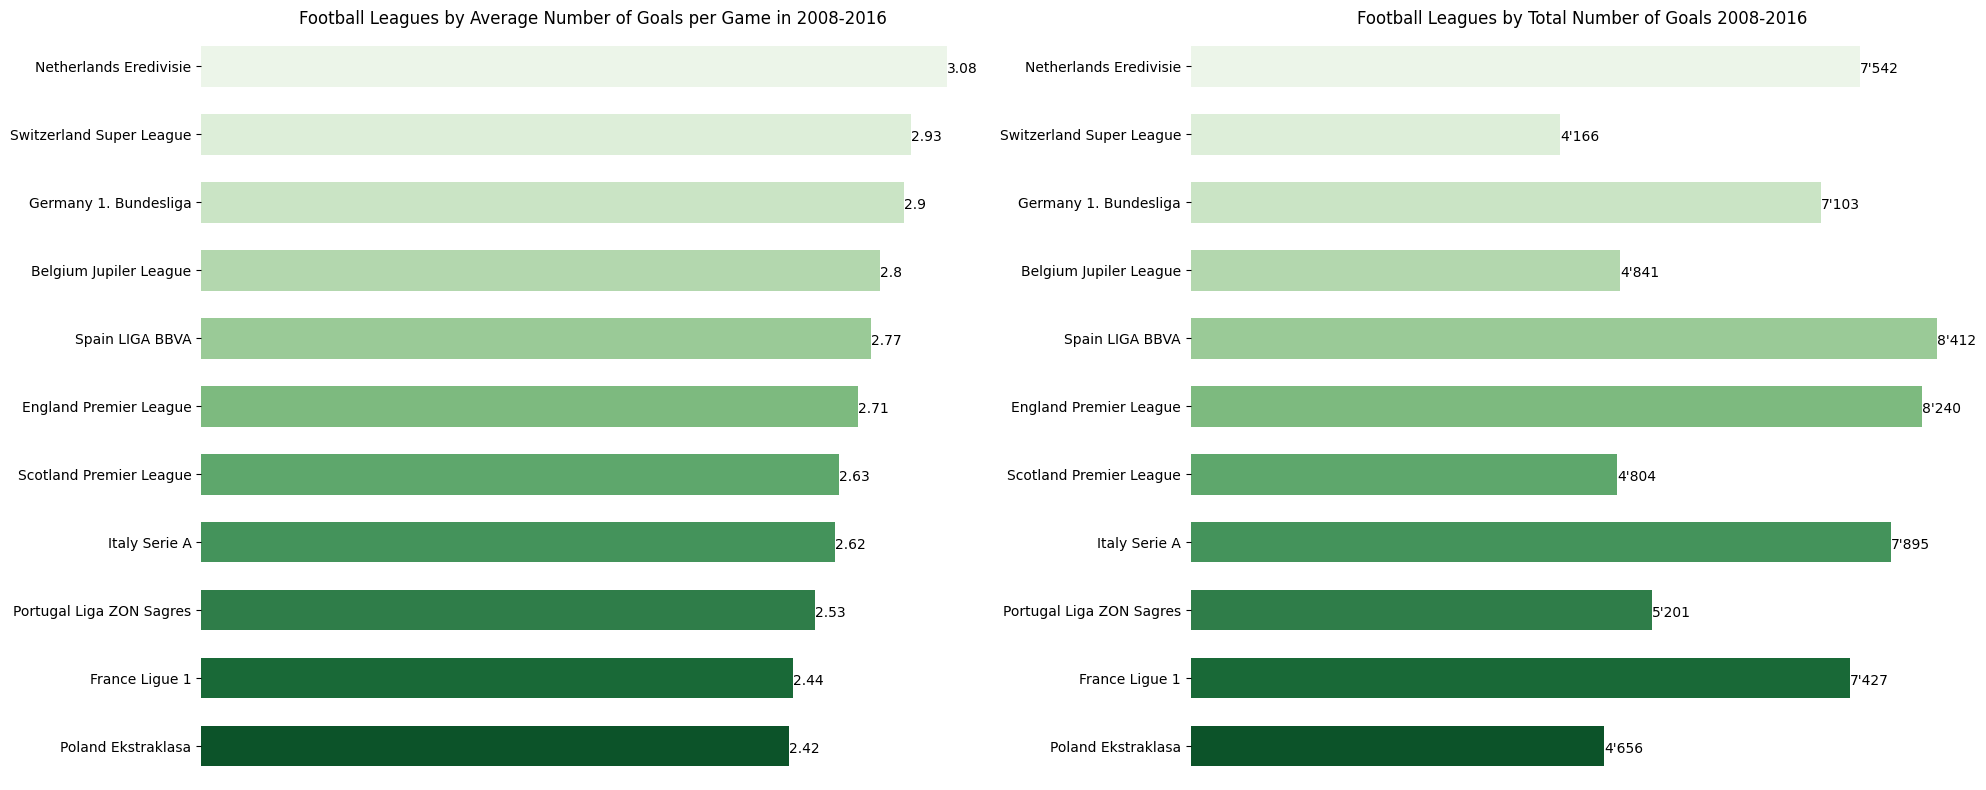

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

my.plot_horiz_barchart(
    df=goals, names="league", values="goals_per_match", ax=axes[0], decimals=2
)
axes[0].set_title("Football Leagues by Average Number of Goals per Game in 2008-2016")

my.plot_horiz_barchart(df=goals, names="league", values="total_goals", ax=axes[1])
axes[1].set_title("Football Leagues by Total Number of Goals 2008-2016")

plt.tight_layout()
plt.show()

Looking at the totals, Spain and English leagues have the most goals. However, they have more teams than some of the other leagues and, therefore, more games played. When looking at average number of goals per match, it seems that the Netherlands Eredivisie league has the most with just over 3 goals per match, whereas England and Spain leagues are around the average with 2.7-2.8 goals per match.

Now, let's look at the distribution of goals scored.


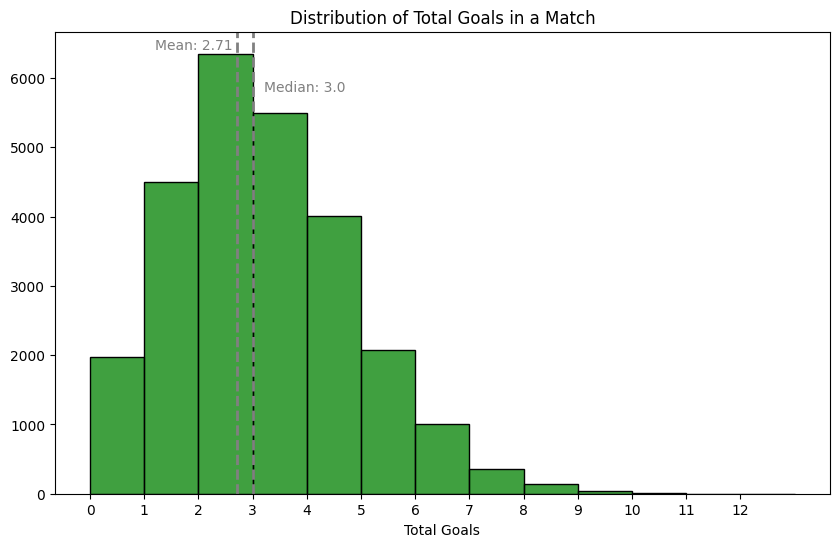

In [35]:
max_goals = int(match_data["total_goals"].max())
mean_val = match_data["total_goals"].mean()
median_val = match_data["total_goals"].median()

plt.figure(figsize=(10, 6))
sns.histplot(
    data=match_data,
    x="total_goals",
    bins=range(max_goals + 2),
    color="green",
    edgecolor="black",
)

plt.axvline(mean_val, color="grey", linestyle="--", linewidth=2)
plt.text(
    mean_val - 1.5,
    plt.gca().get_ylim()[1] - 200,
    f"Mean: {mean_val:.2f}",
    color="grey",
    va="center",
)

plt.axvline(median_val, color="grey", linestyle="--", linewidth=2)
plt.text(
    median_val + 0.2,
    plt.gca().get_ylim()[1] - 800,
    f"Median: {median_val:.1f}",
    color="grey",
    va="center",
)


plt.xlabel("Total Goals")
plt.ylabel("")
plt.title("Distribution of Total Goals in a Match")
plt.xticks(list(range(max_goals + 1)))
plt.show()

The distribution of total goals scored in a match follows a normal distribution that is rightly skewed. The median is 3 goals with the mean of 2.71 goals, and the range is from 0 to 12 goals. There are no apparent outliers.


## 2.3. Who are the top scorers in each team and league?


We will start by getting the top scorers by league. Information on which player scored goals for each match is stored in the _goal_ column of the _Match_ table in our SQL database. We will first inspect if we have all necessary data.


In [36]:
query = """SELECT 
    L.id AS league_id,
    L.name AS league,
    COUNT(M.id) AS total_matches,
    SUM(CASE WHEN M.goal IS NOT NULL THEN 1 ELSE 0 END) AS matches_with_goal_info,
    SUM(CASE WHEN M.goal IS NULL THEN 1 ELSE 0 END) AS missing_goal_info
FROM 
    League L
LEFT JOIN 
    Match M ON L.id = M.league_id
GROUP BY 
    L.id, L.name

        """

leagues_with_goals = pd.read_sql_query(query, con=con)
leagues_with_goals

league_id                    league  total_matches  \
0           1    Belgium Jupiler League           1728   
1        1729    England Premier League           3040   
2        4769            France Ligue 1           3040   
3        7809     Germany 1. Bundesliga           2448   
4       10257             Italy Serie A           3017   
5       13274    Netherlands Eredivisie           2448   
6       15722        Poland Ekstraklasa           1920   
7       17642  Portugal Liga ZON Sagres           2052   
8       19694   Scotland Premier League           1824   
9       21518           Spain LIGA BBVA           3040   
10      24558  Switzerland Super League           1422   

    matches_with_goal_info  missing_goal_info  
0                        0               1728  
1                     3040                  0  
2                     2026               1014  
3                     2448                  0  
4                     3014                  3  
5                      530               1918  
6                        7               1913  
7                        0               2052  
8                       13               1811  
9                     3039                  1  
10                     100               1322

From the table above, we see that we have (almost) all the goals for: England, Germany, (Italy) and (Spain) leagues. We have the majority of goal info for France league. We have none at all (or only a minority) for: Belgium, (Netherlands), (Poland), Portugal, (Switzerland). This should be kept in mind when interpreting further results.


To be able to credit goals to players, we first need to parse the goal data from the 'goal' column which is in XML.


In [37]:
match_data["goal_data"] = match_data.apply(
    lambda row: my.parse_goal_xml(
        row["goal"], row["home_team_id"], row["away_team_id"]
    ),
    axis=1,
)

In [38]:
goals_df = match_data.explode("goal_data")
goals_df = pd.concat([goals_df, goals_df["goal_data"].apply(pd.Series)], axis=1)
goals_df = goals_df[goals_df["type"] != "owngoal"]  # filtering out owngoals
goals_df = goals_df.merge(leagues[["league_id", "league"]], on="league_id", how="left")

In [39]:
top_scorers_league = (
    goals_df.groupby(["league", "player_id"])
    .size()
    .reset_index(name="goal_count")
    .sort_values(by=["league", "goal_count"], ascending=[True, False])
)

top_scorers_league = top_scorers_league.groupby("league").first().reset_index()
top_scorers_league = my.append_player_names(top_scorers_league, con)
top_scorers_league = top_scorers_league.sort_values(by="goal_count", ascending=False)

print(top_scorers_league[["league", "player_name", "goal_count"]])

                     league         player_name  goal_count
7           Spain LIGA BBVA        Lionel Messi         281
3             Italy Serie A   Antonio Di Natale         147
0    England Premier League        Wayne Rooney         125
2     Germany 1. Bundesliga  Robert Lewandowski         121
1            France Ligue 1  Zlatan Ibrahimovic         113
4    Netherlands Eredivisie        Luuk de Jong          43
8  Switzerland Super League    Guillaume Hoarau          17
6   Scotland Premier League        Kenny Miller           7
5        Poland Ekstraklasa     Artjoms Rudnevs           3


Now that we have the top goal scorers for each league for the 2008/2009 - 2015/2016 time period, let's find all the team top scorers.


In [40]:
top_scorers_team = (
    goals_df.groupby(["league", "team_id", "player_id"])
    .size()
    .reset_index(name="goal_count")
    .sort_values(by=["league", "team_id", "goal_count"], ascending=[True, True, False])
)

top_scorers_team = top_scorers_team.groupby(["league", "team_id"]).first().reset_index()
top_scorers_team = my.append_player_names(top_scorers_team, con)
top_scorers_team = my.append_team_names(top_scorers_team, con)
display(
    top_scorers_team[["team_long_name", "league", "player_name", "goal_count"]]
    .sort_values(by="goal_count", ascending=False)
    .head(20)
)

team_long_name                  league          player_name  \
177             FC Barcelona         Spain LIGA BBVA         Lionel Messi   
176           Real Madrid CF         Spain LIGA BBVA    Cristiano Ronaldo   
111                  Udinese           Italy Serie A    Antonio Di Natale   
4          Manchester United  England Premier League         Wayne Rooney   
59       Paris Saint-Germain          France Ligue 1   Zlatan Ibrahimovic   
70       Bayer 04 Leverkusen   Germany 1. Bundesliga     Stefan Kiessling   
10           Manchester City  England Premier League        Sergio Aguero   
90          FC Bayern Munich   Germany 1. Bundesliga       Thomas Mueller   
113                     Roma           Italy Serie A      Francesco Totti   
65             FC Schalke 04   Germany 1. Bundesliga  Klaas Jan Huntelaar   
118                   Napoli           Italy Serie A       Edinson Cavani   
9                    Chelsea  England Premier League        Frank Lampard   
87         Borussia Dortmund   Germany 1. Bundesliga   Robert Lewandowski   
82          SV Werder Bremen   Germany 1. Bundesliga      Claudio Pizarro   
52        Olympique Lyonnais          France Ligue 1  Alexandre Lacazette   
162               Sevilla FC         Spain LIGA BBVA       Alvaro Negredo   
89       Eintracht Frankfurt   Germany 1. Bundesliga      Alexander Meier   
20                 Liverpool  England Premier League          Luis Suarez   
165  Athletic Club de Bilbao         Spain LIGA BBVA         Aritz Aduriz   
30                   Arsenal  England Premier League     Robin van Persie   

     goal_count  
177         281  
176         259  
111         147  
4           125  
59          113  
70          109  
10          102  
90           91  
113          82  
65           81  
118          77  
9            76  
87           74  
82           74  
52           71  
162          70  
89           70  
20           69  
165          68  
30           68

In [41]:
duplicated_names = top_scorers_team[
    top_scorers_team["player_name"].duplicated(keep=False)
]
duplicated_names = duplicated_names.dropna()
display(duplicated_names[["team_long_name", "league", "player_name", "goal_count"]])

team_long_name                  league      player_name  \
5          Newcastle United  England Premier League     Papiss Cisse   
78              SC Freiburg   Germany 1. Bundesliga     Papiss Cisse   
156             Valencia CF         Spain LIGA BBVA  Roberto Soldado   
163               Getafe CF         Spain LIGA BBVA  Roberto Soldado   
174              Levante UD         Spain LIGA BBVA     David Barral   
185  Real Sporting de Gijón         Spain LIGA BBVA     David Barral   

     goal_count  
5            38  
78           37  
156          59  
163          29  
174          18  
185          28

There are three players that are top scorers for two different teams in the whole 2008-2016 period.


## 2.4. Who Are the Champions of each league?


In [42]:
def get_season_standings(league_id, season, df):
    filtered_data = df[(df["league_id"] == league_id) & (df["season"] == season)].copy()

    teams_ids = set(filtered_data["home_team_id"]).union(
        set(filtered_data["away_team_id"])
    )

    rankings = pd.DataFrame(
        columns=[
            "team_id",
            "matches_played",
            "wins",
            "draws",
            "losses",
            "goals_scored",
            "goals_allowed",
            "goal_difference",
            "points",
        ]
    )

    for team in teams_ids:
        home_matches = filtered_data[filtered_data["home_team_id"] == team]
        away_matches = filtered_data[filtered_data["away_team_id"] == team]

        matches_played = len(home_matches) + len(away_matches)

        # Points
        home_points = home_matches["home_team_points"].sum()
        away_points = away_matches["away_team_points"].sum()
        total_points = home_points + away_points

        # Goals
        goals_scored_home = home_matches["home_team_goal"].sum()
        goals_scored_away = away_matches["away_team_goal"].sum()
        goals_allowed_home = home_matches["away_team_goal"].sum()
        goals_allowed_away = away_matches["home_team_goal"].sum()

        goals_scored = goals_scored_home + goals_scored_away
        goals_allowed = goals_allowed_home + goals_allowed_away
        goal_difference = goals_scored - goals_allowed

        # Wins, draws, losses
        wins = len(home_matches[home_matches["winner"] == "Home"]) + len(
            away_matches[away_matches["winner"] == "Away"]
        )
        draws = len(home_matches[home_matches["winner"] == "Draw"]) + len(
            away_matches[away_matches["winner"] == "Draw"]
        )
        losses = (
            matches_played
            - len(home_matches[home_matches["winner"] == "Home"])
            - len(away_matches[away_matches["winner"] == "Away"])
            - draws
        )

        new_row = pd.DataFrame(
            {
                "team_id": [team],
                "matches_played": [matches_played],
                "wins": [wins],
                "draws": [draws],
                "losses": [losses],
                "goals_scored": [goals_scored],
                "goals_allowed": [goals_allowed],
                "goal_difference": [goal_difference],
                "points": [total_points],
            }
        )

        rankings = pd.concat([rankings, new_row], ignore_index=True)

    rankings = rankings.sort_values(
        by=["points", "goal_difference"], ascending=[False, False]
    )

    return rankings.reset_index(drop=True)

In [43]:
leagues

league_id                    league      country
0           1    Belgium Jupiler League      Belgium
1        1729    England Premier League      England
2        4769            France Ligue 1       France
3        7809     Germany 1. Bundesliga      Germany
4       10257             Italy Serie A        Italy
5       13274    Netherlands Eredivisie  Netherlands
6       15722        Poland Ekstraklasa       Poland
7       17642  Portugal Liga ZON Sagres     Portugal
8       19694   Scotland Premier League     Scotland
9       21518           Spain LIGA BBVA        Spain
10      24558  Switzerland Super League  Switzerland

In [44]:
standings = get_season_standings(21518, season="2015/2016", df=match_data)
standings = standings.merge(unique_teams, on="team_id", how="left")

# formatting the dataframe
cols = standings.columns.tolist()
cols.insert(1, cols.pop(cols.index("team_long_name")))
standings = standings[cols]
standings.drop("team_id", axis=1, inplace=True)

display(standings)

team_long_name matches_played wins draws losses goals_scored  \
0                FC Barcelona             38   29     4      5          112   
1              Real Madrid CF             38   28     6      4          110   
2             Atlético Madrid             38   28     4      6           63   
3               Villarreal CF             38   18    10     10           44   
4     Athletic Club de Bilbao             38   18     8     12           58   
5            RC Celta de Vigo             38   17     9     12           51   
6                  Sevilla FC             38   14    10     14           51   
7                   Málaga CF             38   12    12     14           38   
8               Real Sociedad             38   13     9     16           45   
9         Real Betis Balompié             38   11    12     15           34   
10                Valencia CF             38   11    11     16           46   
11              UD Las Palmas             38   12     8     18           45   
12                   SD Eibar             38   11    10     17           49   
13               RCD Espanyol             38   12     7     19           40   
14  RC Deportivo de La Coruña             38    8    18     12           45   
15     Real Sporting de Gijón             38   10     9     19           40   
16                 Granada CF             38   10     9     19           46   
17             Rayo Vallecano             38    9    11     18           52   
18                  Getafe CF             38    9     9     20           37   
19                 Levante UD             38    8     8     22           37   

   goals_allowed goal_difference points  
0             29              83     91  
1             34              76     90  
2             18              45     88  
3             35               9     64  
4             45              13     62  
5             59              -8     60  
6             50               1     52  
7             35               3     48  
8             48              -3     48  
9             52             -18     45  
10            48              -2     44  
11            53              -8     44  
12            61             -12     43  
13            74             -34     43  
14            61             -16     42  
15            62             -22     39  
16            69             -23     39  
17            73             -21     38  
18            67             -30     36  
19            70             -33     32

In [45]:
league_winners = []

for season in match_data["season"].unique():
    for league in match_data["league_id"].unique():
        rankings = get_season_standings(league, season, match_data)

        if not rankings.empty:
            winner = rankings.iloc[0]["team_id"]

            league_winners_data = {
                "season": season,
                "league_id": league,
                "team_id": winner,
            }
            league_winners.append(league_winners_data)

winners_df = pd.DataFrame(league_winners)

# Adding names to ids
winners_df = winners_df.merge(
    leagues[["league_id", "league"]], on="league_id", how="left"
)

winners_df = winners_df.merge(unique_teams, on="team_id", how="left")

pivot_winners = winners_df.pivot(
    index="league", columns="season", values="team_long_name"
)
pivot_winners

season                                2008/2009               2009/2010  \
league                                                                    
Belgium Jupiler League           RSC Anderlecht          RSC Anderlecht   
England Premier League        Manchester United                 Chelsea   
France Ligue 1            Girondins de Bordeaux  Olympique de Marseille   
Germany 1. Bundesliga             VfL Wolfsburg        FC Bayern Munich   
Italy Serie A                             Inter                   Inter   
Netherlands Eredivisie                       AZ               FC Twente   
Poland Ekstraklasa                 Wisła Kraków             Lech Poznań   
Portugal Liga ZON Sagres               FC Porto              SL Benfica   
Scotland Premier League                 Rangers                 Rangers   
Spain LIGA BBVA                    FC Barcelona            FC Barcelona   
Switzerland Super League              FC Zürich                FC Basel   

season                            2010/2011               2011/2012  \
league                                                                
Belgium Jupiler League       RSC Anderlecht          RSC Anderlecht   
England Premier League    Manchester United         Manchester City   
France Ligue 1                   LOSC Lille  Montpellier Hérault SC   
Germany 1. Bundesliga     Borussia Dortmund       Borussia Dortmund   
Italy Serie A                         Milan                Juventus   
Netherlands Eredivisie                 Ajax                    Ajax   
Poland Ekstraklasa             Wisła Kraków           Śląsk Wrocław   
Portugal Liga ZON Sagres           FC Porto                FC Porto   
Scotland Premier League             Rangers                  Celtic   
Spain LIGA BBVA                FC Barcelona          Real Madrid CF   
Switzerland Super League           FC Basel                FC Basel   

season                              2012/2013            2013/2014  \
league                                                               
Belgium Jupiler League         RSC Anderlecht          KV Oostende   
England Premier League      Manchester United      Manchester City   
France Ligue 1            Paris Saint-Germain  Paris Saint-Germain   
Germany 1. Bundesliga        FC Bayern Munich     FC Bayern Munich   
Italy Serie A                        Juventus             Juventus   
Netherlands Eredivisie                   Ajax                 Ajax   
Poland Ekstraklasa             Legia Warszawa       Legia Warszawa   
Portugal Liga ZON Sagres             FC Porto           SL Benfica   
Scotland Premier League                Celtic               Celtic   
Spain LIGA BBVA                  FC Barcelona      Atlético Madrid   
Switzerland Super League             FC Basel             FC Basel   

season                              2014/2015            2015/2016  
league                                                              
Belgium Jupiler League         Club Brugge KV       Club Brugge KV  
England Premier League                Chelsea       Leicester City  
France Ligue 1            Paris Saint-Germain  Paris Saint-Germain  
Germany 1. Bundesliga        FC Bayern Munich     FC Bayern Munich  
Italy Serie A                        Juventus             Juventus  
Netherlands Eredivisie                    PSV                  PSV  
Poland Ekstraklasa             Legia Warszawa       Legia Warszawa  
Portugal Liga ZON Sagres           SL Benfica           SL Benfica  
Scotland Premier League                Celtic               Celtic  
Spain LIGA BBVA                  FC Barcelona         FC Barcelona  
Switzerland Super League             FC Basel             FC Basel

Disclaimer: we have missing games in the dataframe for some leagues and seasons, so the results might not be accurate, as these are computed standings from the games we have. For exmaple, we are missing most of games from 2013/2014 Belgium league season.


In [46]:
most_common_winners = (
    winners_df.groupby(["league", "team_long_name"])
    .size()
    .reset_index(name="times_won")
)
most_common_winners = most_common_winners.sort_values(
    ["league", "times_won"], ascending=[True, False]
).drop_duplicates("league")

most_common_winners = most_common_winners[["league", "team_long_name", "times_won"]]
most_common_winners.columns = ["league", "winner", "times_won"]
most_common_winners

league               winner  times_won
2     Belgium Jupiler League       RSC Anderlecht          5
6     England Premier League    Manchester United          3
11            France Ligue 1  Paris Saint-Germain          4
13     Germany 1. Bundesliga     FC Bayern Munich          5
16             Italy Serie A             Juventus          5
19    Netherlands Eredivisie                 Ajax          4
23        Poland Ekstraklasa       Legia Warszawa          4
26  Portugal Liga ZON Sagres             FC Porto          4
28   Scotland Premier League               Celtic          5
31           Spain LIGA BBVA         FC Barcelona          6
33  Switzerland Super League             FC Basel          7

Over the 8 seasons in our dataset, there were teams that were dominating their respective national leagues. For example, Bayern Muich has won Germany's Budesliga 5 times over the course of 8 years, while Barcelona has won the Spanish league 6 times! FC Basel has won the Switzerland Super League 7 times in a row starting from the 2009/2010 season.

In the next part, we will be looking at some of these champion teams, to investigate what makes a good team, to help us better understand the data we have on teams in general.


## 2.5. Exploring Teams Data


In this section, we will be exploring the data that was created by combining the **Team** and **Team_Attributes** (Fifa ratings).


In [47]:
teams.head(2)

team_id team_long_name team_short_name       date  buildUpPlaySpeed  \
0    9930       FC Aarau             AAR 2010-02-22                60   
1    9930       FC Aarau             AAR 2014-09-19                52   

  buildUpPlaySpeedClass buildUpPlayDribblingClass  buildUpPlayPassing  \
0              Balanced                    Little                  50   
1              Balanced                    Normal                  56   

  buildUpPlayPassingClass buildUpPlayPositioningClass  chanceCreationPassing  \
0                   Mixed                   Organised                     60   
1                   Mixed                   Organised                     54   

  chanceCreationPassingClass  chanceCreationCrossing  \
0                     Normal                      65   
1                     Normal                      63   

  chanceCreationCrossingClass  chanceCreationShooting  \
0                      Normal                      55   
1                      Normal                      64   

  chanceCreationShootingClass chanceCreationPositioningClass  defencePressure  \
0                      Normal                      Organised               50   
1                      Normal                      Organised               47   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   

   defenceTeamWidth defenceTeamWidthClass defenceDefenderLineClass  
0                45                Normal                    Cover  
1                54                Normal                    Cover

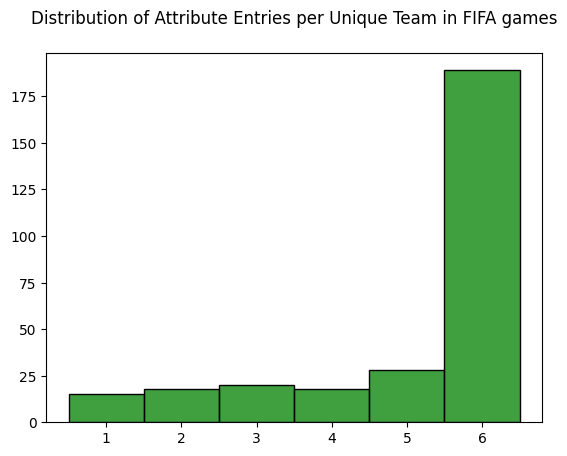

In [48]:
team_counts = teams.team_id.value_counts()

my.plot_detailed_histogram(team_counts)

plt.title("Distribution of Attribute Entries per Unique Team in FIFA games\n")

plt.show()

Some teams appear in the **teams** dataframe more often than others. Nevertheless, we will be ignoring this for exploratory purposes by assuming:

- some of this can be explained by relegation.
- more popular teams appear (and are updated) more often in FIFA games, and better represent their leagues.


In [49]:
teams.describe()

buildUpPlaySpeed  buildUpPlayPassing  chanceCreationPassing  \
count       1457.000000         1457.000000            1457.000000   
mean          52.463967           48.489362              52.166781   
std           11.549653           10.899771              10.364195   
min           20.000000           20.000000              21.000000   
25%           45.000000           40.000000              46.000000   
50%           52.000000           50.000000              52.000000   
75%           62.000000           55.000000              59.000000   
max           80.000000           80.000000              80.000000   

       chanceCreationCrossing  chanceCreationShooting  defencePressure  \
count             1457.000000             1457.000000      1457.000000   
mean                53.734386               53.971860        46.017845   
std                 11.090171               10.330588        10.230702   
min                 20.000000               22.000000        23.000000   
25%                 47.000000               48.000000        39.000000   
50%                 53.000000               53.000000        45.000000   
75%                 62.000000               61.000000        51.000000   
max                 80.000000               80.000000        72.000000   

       defenceAggression  defenceTeamWidth  
count        1457.000000       1457.000000  
mean           49.253946         52.187371  
std             9.740734          9.577828  
min            24.000000         29.000000  
25%            44.000000         47.000000  
50%            48.000000         52.000000  
75%            55.000000         58.000000  
max            72.000000         73.000000

We see that numeric team columns range from 20 to 80, and the average values are around 50. This is not what we were expecting, as the column names and values we have from **Team_Attributes** look more like **team tendencies**, rather than attributes like in the example below (Overall, Offense, Midfield, Defence).

![](fifa_ratings_barcelona.png)

This is rather dissapointing, as having quantified team attributes could be very usefull in predicting match outcomes. Nevertheless, we will quickly explore the team tendencies before moving on to exploring player attributes.


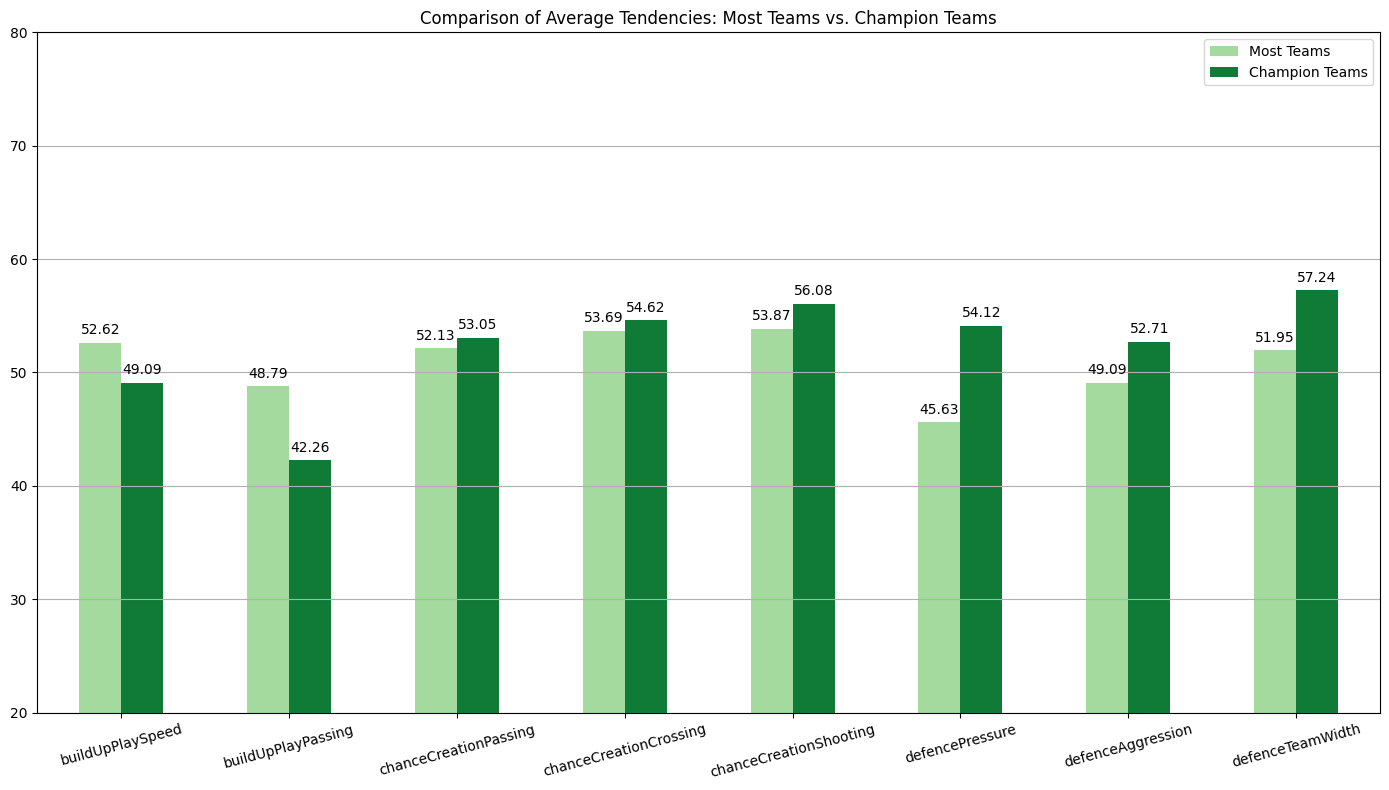

In [50]:
champ_names = list(most_common_winners.winner)

champ_teams_mean = teams[teams.team_long_name.isin(champ_names)].describe().loc["mean"]
other_teams_mean = teams[~teams.team_long_name.isin(champ_names)].describe().loc["mean"]


df_means = pd.DataFrame(
    {"Most Teams": other_teams_mean, "Champion Teams": champ_teams_mean}
)

greens = sns.color_palette("Greens", n_colors=10)
darker_green = greens[-2]
lighter_green = greens[3]


ax = df_means.plot(kind="bar", figsize=(14, 8), color=[lighter_green, darker_green])

plt.title("Comparison of Average Tendencies: Most Teams vs. Champion Teams")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.ylim(20, 80)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

When looking at average tendencies of champion clubs versus the rest we see the following:

- Champion teams have lower **build up play** speed and passing.
- On average, champion teams have only slightly higher **chance creation** tendencies (passing, crossing and shooting).
- Champion teams have higher **defence** tendencies: aggression, team width, and especially - pressure.

This seems to indicate that, according to FIFA games, the champion teams tend to focus and rely on defensive pressure to create opportunities for high-chance counter attacks, rather than build up an attack relying on speed or passing. We will be testing this hypothesis in 3.2. part of the notebook.


## 2.6. Players Analysis


### 2.6.1. Exploring Players Data


In [51]:
players.describe()

height         weight  overall_rating      potential  \
count  183977.000000  183977.000000   183142.000000  183142.000000   
mean      181.878853      76.542480       68.600015      73.460353   
std         6.394831       6.843050        7.041139       6.592271   
min       157.480000      53.061224       33.000000      39.000000   
25%       177.800000      72.108844       64.000000      69.000000   
50%       182.880000      76.190476       69.000000      74.000000   
75%       185.420000      81.179138       73.000000      78.000000   
max       208.280000     110.204082       94.000000      97.000000   

            crossing      finishing  heading_accuracy  short_passing  \
count  183142.000000  183142.000000     183142.000000  183142.000000   
mean       55.086883      49.921078         57.266023      62.429672   
std        17.242135      19.038705         16.488905      14.194068   
min         1.000000       1.000000          1.000000       3.000000   
25%        45.000000      34.000000         49.000000      57.000000   
50%        59.000000      53.000000         60.000000      65.000000   
75%        68.000000      65.000000         68.000000      72.000000   
max        95.000000      97.000000         98.000000      97.000000   

             volleys      dribbling          curve  free_kick_accuracy  \
count  181265.000000  183142.000000  181265.000000       183142.000000   
mean       49.468436      59.175154      52.965675           49.380950   
std        18.256618      17.744688      18.255788           17.831746   
min         1.000000       1.000000       2.000000            1.000000   
25%        35.000000      52.000000      41.000000           36.000000   
50%        52.000000      64.000000      56.000000           50.000000   
75%        64.000000      72.000000      67.000000           63.000000   
max        93.000000      97.000000      94.000000           97.000000   

        long_passing   ball_control   acceleration   sprint_speed  \
count  183142.000000  183142.000000  183142.000000  183142.000000   
mean       57.069880      63.388879      67.659357      68.051244   
std        14.394464      15.196671      12.983326      12.569721   
min         3.000000       5.000000      10.000000      12.000000   
25%        49.000000      58.000000      61.000000      62.000000   
50%        59.000000      67.000000      69.000000      69.000000   
75%        67.000000      73.000000      77.000000      77.000000   
max        97.000000      97.000000      97.000000      97.000000   

             agility      reactions        balance     shot_power  \
count  181265.000000  183142.000000  181265.000000  183142.000000   
mean       65.970910      66.103706      65.189496      61.808427   
std        12.954585       9.155408      13.063188      16.135143   
min        11.000000      17.000000      12.000000       2.000000   
25%        58.000000      61.000000      58.000000      54.000000   
50%        68.000000      67.000000      67.000000      65.000000   
75%        75.000000      72.000000      74.000000      73.000000   
max        96.000000      96.000000      96.000000      97.000000   

             jumping        stamina       strength     long_shots  \
count  181265.000000  183142.000000  183142.000000  183142.000000   
mean       66.969045      67.038544      67.424529      53.339431   
std        11.006734      13.165262      12.072280      18.367025   
min        14.000000      10.000000      10.000000       1.000000   
25%        60.000000      61.000000      60.000000      41.000000   
50%        68.000000      69.000000      69.000000      58.000000   
75%        74.000000      76.000000      76.000000      67.000000   
max        96.000000      96.000000      96.000000      96.000000   

          aggression  interceptions    positioning         vision  \
count  183142.000000  183142.000000  183142.000000  181265.000000   
mean       60.948046      52.009271      55.786504      57.8735

In [52]:
players.head(2)

player_id         player_name   birthday  height     weight       date  \
0    505942  Aaron Appindangoye 1992-02-29  182.88  84.807256 2016-02-18   
1    505942  Aaron Appindangoye 1992-02-29  182.88  84.807256 2015-11-19   

   overall_rating  potential preferred_foot attacking_work_rate  \
0            67.0       71.0          right              medium   
1            67.0       71.0          right              medium   

  defensive_work_rate  crossing  finishing  heading_accuracy  short_passing  \
0              medium      49.0       44.0              71.0           61.0   
1              medium      49.0       44.0              71.0           61.0   

   volleys  dribbling  curve  free_kick_accuracy  long_passing  ball_control  \
0     44.0       51.0   45.0                39.0          64.0          49.0   
1     44.0       51.0   45.0                39.0          64.0          49.0   

   acceleration  sprint_speed  agility  reactions  balance  shot_power  \
0          60.0          64.0     59.0       47.0     65.0        55.0   
1          60.0          64.0     59.0       47.0     65.0        55.0   

   jumping  stamina  strength  long_shots  aggression  interceptions  \
0     58.0     54.0      76.0        35.0        71.0           70.0   
1     58.0     54.0      76.0        35.0        71.0           70.0   

   positioning  vision  penalties  marking  standing_tackle  sliding_tackle  \
0         45.0    54.0       48.0     65.0             69.0            69.0   
1         45.0    54.0       48.0     65.0             69.0            69.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0

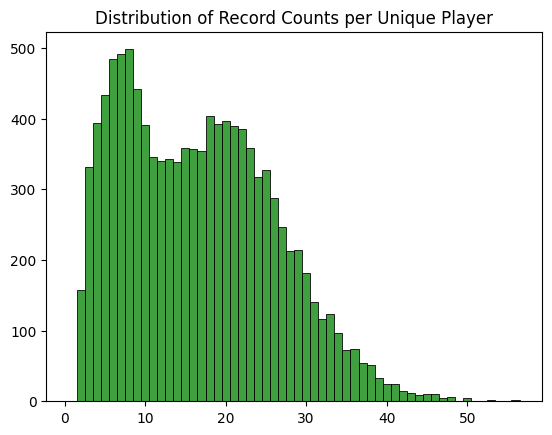

In [53]:
player_counts = players.player_id.value_counts()

my.plot_detailed_histogram(player_counts)

plt.title("Distribution of Record Counts per Unique Player")

plt.show()

As we can see, all players in the database have at least 2 records of their attributes in the FIFA game, with some having even over 50 updates of their attributes. On average, a player has 16-17 records of their attributes, giving us about 2 attribute records for each player per season.


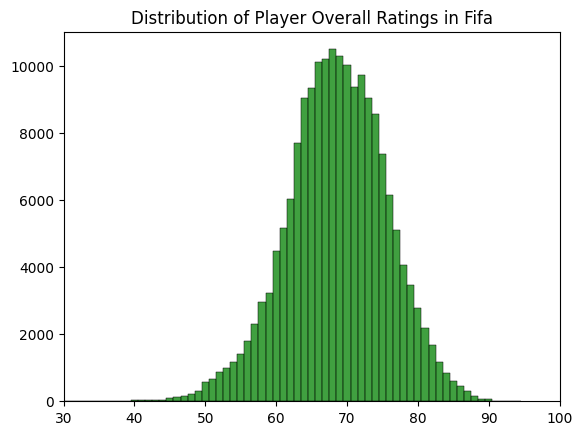

In [54]:
overall_ratings = players.overall_rating

my.plot_detailed_histogram(overall_ratings)

plt.title("Distribution of Player Overall Ratings in Fifa")
plt.xlim(30, 100)

plt.show()

Player overall ratings follow a normal distribution with a mean of 68.6 and a median of ~69. The range of overall ratings is 39 to 94, and there doesn't seem to be any outliers.

Let's inspect the correlation between numeric columns of player attributes.


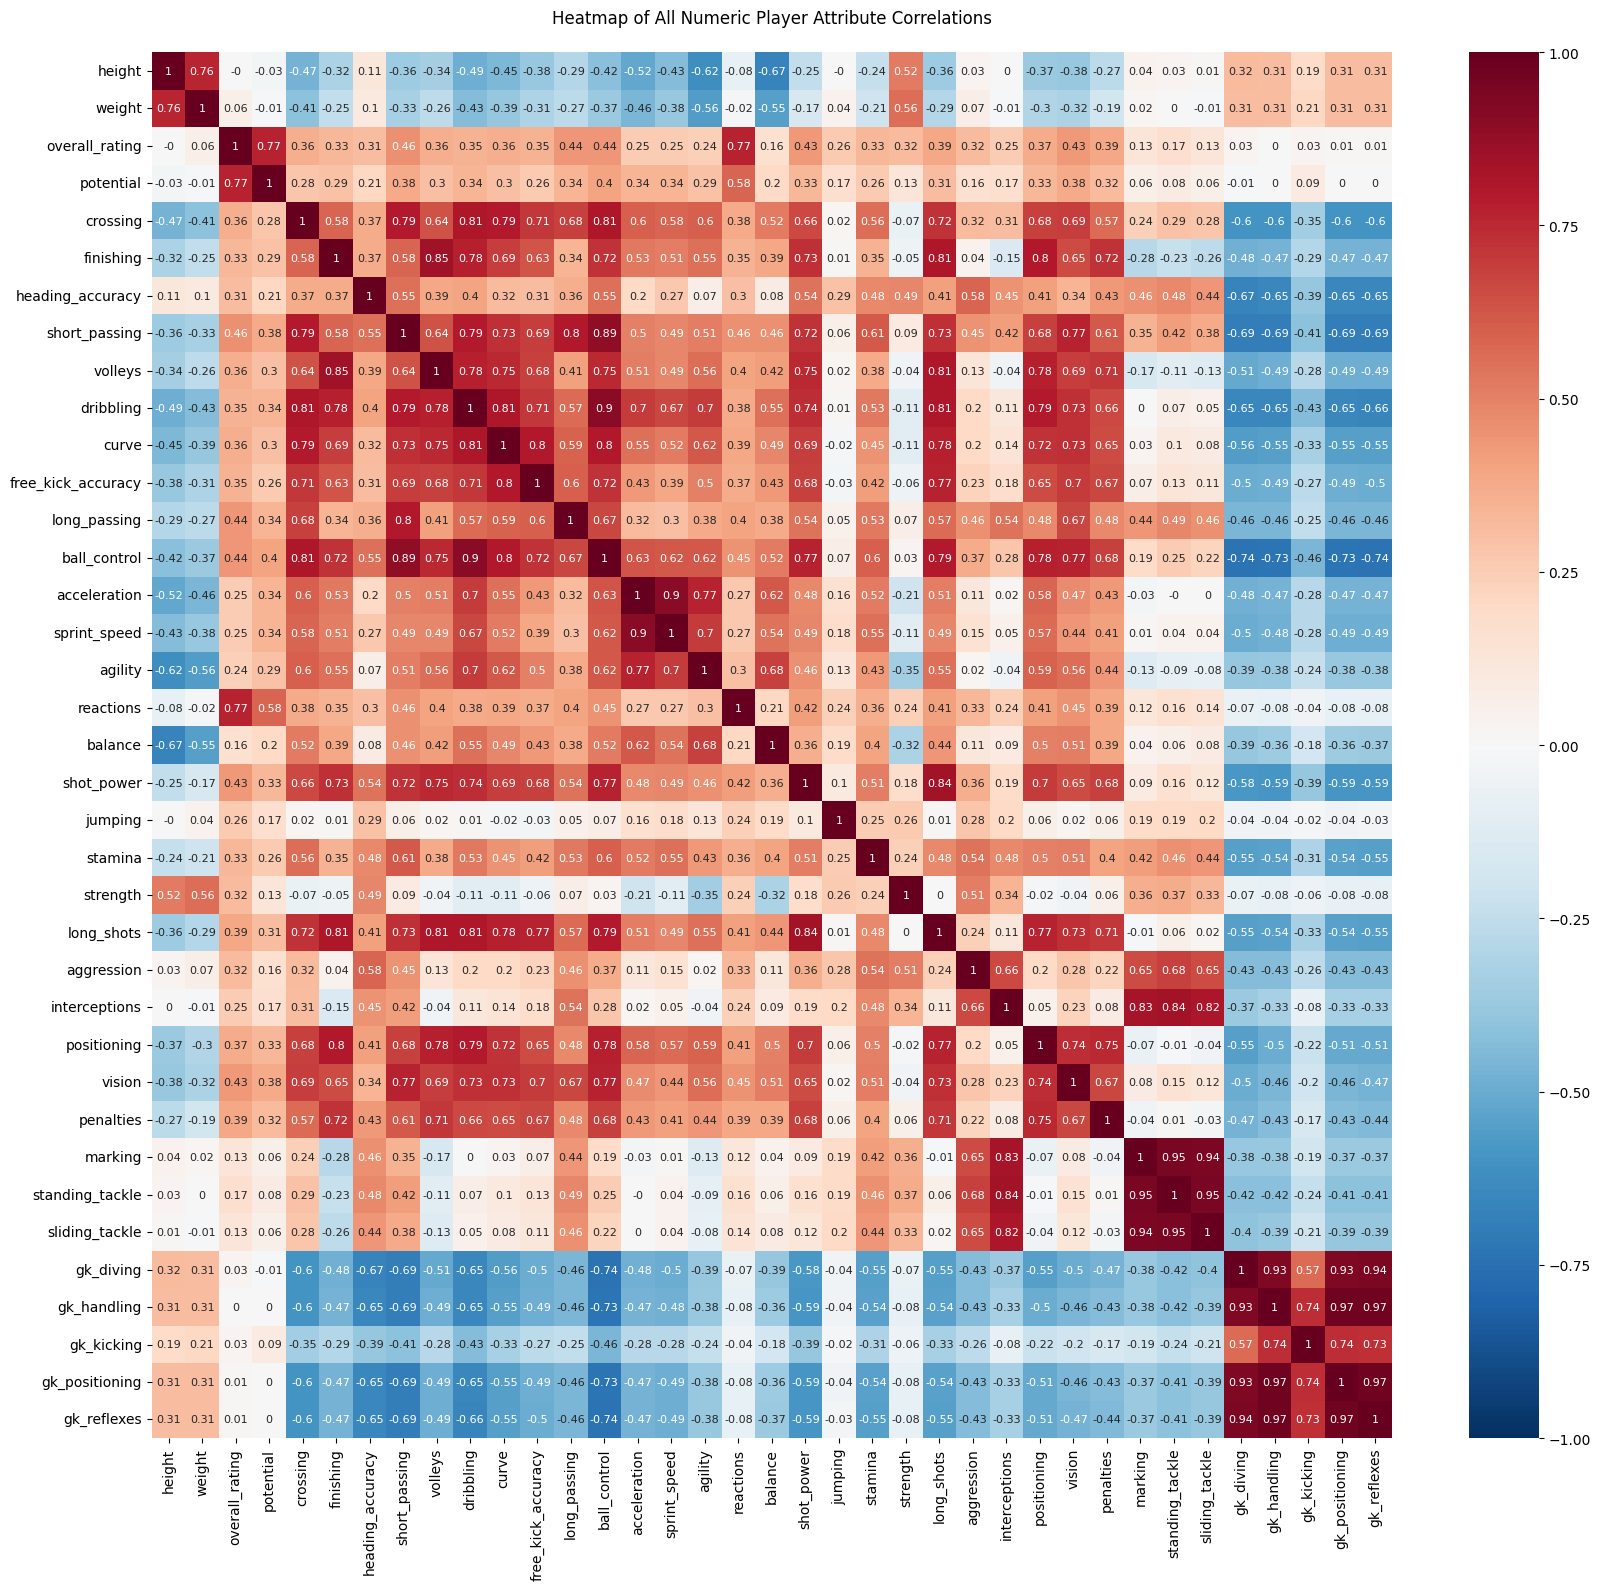

In [55]:
numeric_columns = players.describe().columns

corr_matrix = players[numeric_columns].corr()
corr_matrix = corr_matrix.round(2)

plt.figure(figsize=(20, 18))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    annot_kws={"fontsize": 8},
)

plt.title("Heatmap of All Numeric Player Attribute Correlations\n")
plt.show()

From the extensive heatmap above:

1. right away we notice that **goalkeeping** attributes (bottom right corner of the heatmap) are negatively correlated with most of the other player attributes, but are very strongly correlated with eachother.
2. Next, we see another group of **defensive** attributes that are very strongly correlated with each other: marking, standing_tackle and sliding_tackle.

By continiuosly moving up and left in the heatmap (along the diagnol line of 1s), we can spot additional groups (although not as easily visible as goalkeeping and defensive attributes). This indicates that the FIFA game attributes can be grouped. After visiting fifaratings website, we infact see that the attributes are grouped in the following categories:

- Attacking
- Skill
- Movement
- Power
- Mentality
- Defending
- Goalkeeping

Example: [https://www.fifaratings.com/zlatan-ibrahimovic]

For the simplification of the analysis and avoidance of multicollinearity, we will be grouping attributes to the categories specified in the fifa ratings website and computing their averages.


In [56]:
attribute_categories = {
    "Attacking": [
        "crossing",
        "finishing",
        "heading_accuracy",
        "short_passing",
        "volleys",
    ],
    "Skill": [
        "dribbling",
        "curve",
        "free_kick_accuracy",
        "long_passing",
        "ball_control",
    ],
    "Movement": ["acceleration", "sprint_speed", "agility", "reactions", "balance"],
    "Power": ["shot_power", "jumping", "stamina", "strength", "long_shots"],
    "Mentality": ["aggression", "interceptions", "positioning", "vision", "penalties"],
    "Defending": ["marking", "standing_tackle", "sliding_tackle"],
    "Goalkeeping": [
        "gk_diving",
        "gk_handling",
        "gk_kicking",
        "gk_positioning",
        "gk_reflexes",
    ],
}

In [57]:
for category, attributes in attribute_categories.items():
    players[category] = players[attributes].mean(axis=1)

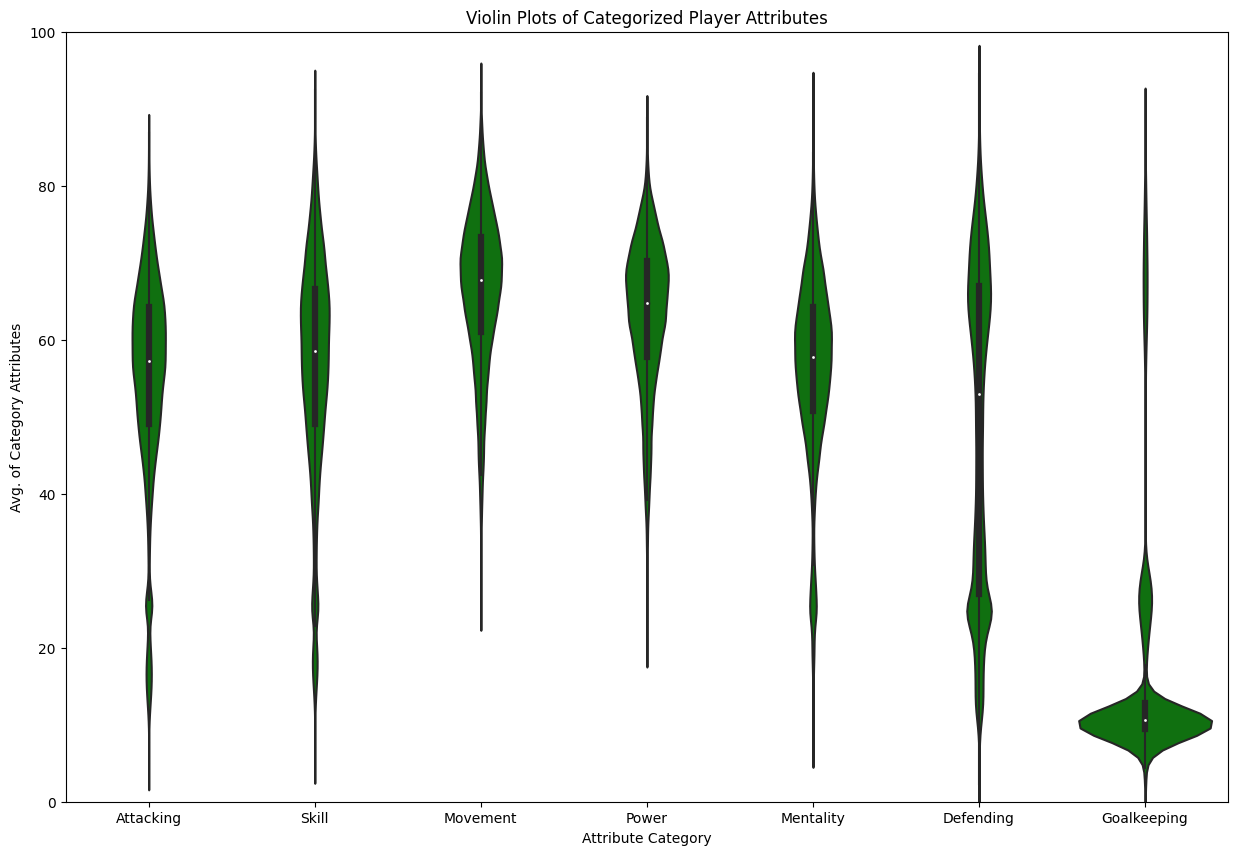

In [58]:
melted_players = players.melt(value_vars=players.columns[-7:])

plt.figure(figsize=(15, 10))

sns.violinplot(x="variable", y="value", data=melted_players, color="green")

plt.title("Violin Plots of Categorized Player Attributes")
plt.xlabel("Attribute Category")
plt.ylabel("Avg. of Category Attributes")

plt.ylim(0, 100)

plt.show()

From the violin plots above we see the distributions of the grouped average ratings for all players.

Most of the categories are normally distributed, however, there are apparent outliers in the distribution in **Attacking**, **Skill**, **Defending** and **Goalkeeping** categories. This most likely can be explained by the goalkeepers in the dataset, as only their **Goalkeeping** attributes are high, while the remainder of their attributes are low, as they are not as relevant for their position.

We will try to **cluster** our players into positions or playstyles, to be able to distinguish the groups, as well as better understand what attributes are needed for which positions.


### 2.6.2. Bonus challenge: Clustering players into archetypes


In [59]:
avg_columns = players.columns[-7:]
players_cleaned = players.copy().dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(players_cleaned[avg_columns])

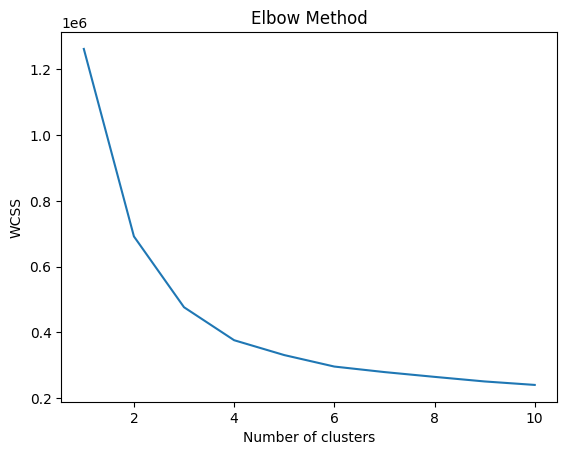

In [60]:
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

Using the Elbow method, it seems that we should try k-means for values 5 and 6. We will also be trying it for 4 clusters, as the line seems to start straighten a bit from there as well. Furthermore, this makes sense from our domain knowledge, as there are 4 major positions in football: Forwards, Midfielders, Defenders and Goalkeepers.


In [61]:
# code takes very long to run
"""
best_n = 0
best_score = -1

for i in range(4, 7):
    kmeans = KMeans(n_clusters=i, random_state=42)
    preds = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, preds)
    if score > best_score:
        best_score = score
        best_n = i

    print(i, score)

print(f"Best number of clusters: {best_n} with silhouette score: {best_score:.2f}")
"""

'\nbest_n = 0\nbest_score = -1\n\nfor i in range(4, 7):\n    kmeans = KMeans(n_clusters=i, random_state=42)\n    preds = kmeans.fit_predict(scaled_data)\n    score = silhouette_score(scaled_data, preds)\n    if score > best_score:\n        best_score = score\n        best_n = i\n\n    print(i, score)\n\nprint(f"Best number of clusters: {best_n} with silhouette score: {best_score:.2f}")\n'

Using the slihoutte score, it seems that 4 is in fact the best number of clusters.


In [62]:
n = 4

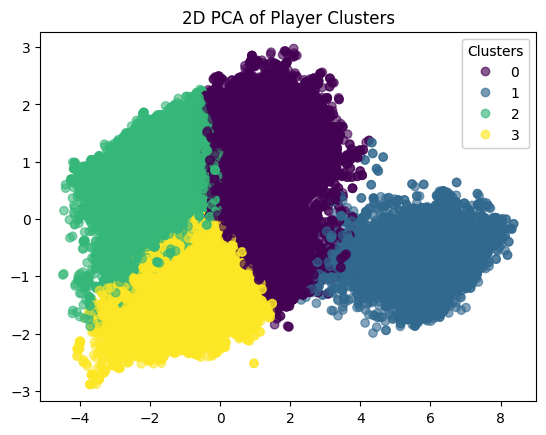

Attacking  Skill  Movement  Power  Mentality  Defending  Goalkeeping  \
Cluster                                                                         
0            47.75  48.14     60.55  58.13      51.82      58.83        12.06   
1            20.29  22.52     50.10  43.45      28.79      18.47        67.68   
2            61.82  65.43     70.31  70.30      66.18      66.52        12.72   
3            63.36  63.89     72.76  66.41      57.75      29.13        11.85   

         avg_overall_rating  count  nunique  
Cluster                                      
0                     63.40  52310     5947  
1                     68.13  14624      911  
2                     72.17  55476     4060  
3                     70.10  57944     3977

In [63]:
kmeans = KMeans(n_clusters=n, random_state=42)
players_cleaned["Cluster"] = kmeans.fit_predict(scaled_data)

cluster_summary = players_cleaned.groupby("Cluster")[avg_columns].mean()
cluster_counts = players_cleaned.groupby("Cluster").agg(
    avg_overall_rating=("overall_rating", "mean"),
    count=("player_id", "count"),
    nunique=("player_id", "nunique"),
)
cluster_summary = cluster_summary.join(cluster_counts)
cluster_summary = cluster_summary.round(2)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

scatter = plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=players_cleaned["Cluster"],
    alpha=0.6,
    cmap="viridis",
)

legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)

plt.title("2D PCA of Player Clusters")
plt.show()

display(cluster_summary)

After applying k-means algorithm over 4 clusters, we get the following groups:

| **Cluster** | **Color** | **Name**                            | **Description**                                                                                             |
| ----------- | --------- | ----------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| 0           | Purple    | **Below average versatile players** | Most of their skills are below average, with Defending being higher and very low Goalkeeping.               |
| 1           | Blue      | **Goalkeepers**                     | High Goalkeeping, other stats are lower.                                                                    |
| 2           | Green     | **Higher tier all-rounders**        | All stats are high, except Goalkeeping.                                                                     |
| 3           | Yellow    | **Forwards**                        | Highest Attacking stat, other stats are also quite high, except for low Defending and very low Goalkeeping. |

At first glance, it seems that the algorithm did well at distinguishing Goal Keepers and Forwards. However, Defenders and Midfielders were separated based on how good they are, rather than playstyles. Therefore, we will try to redo the clustering by first transforming the attributes as a proportion of their overall rating. This is done so that the attributes better represent a players playstyle (strength vs weaknesses), rather than extent of their abilities.


In [64]:
avg_columns = players.columns[-7:]
players_cleaned = players.copy().dropna()

# Getting attributes as proportion of a players overall rating
for category, attributes in attribute_categories.items():
    players_cleaned[category] = (
        players_cleaned[attributes].mean(axis=1) / players_cleaned["overall_rating"]
    )

scaled_data = scaler.fit_transform(players_cleaned[avg_columns])

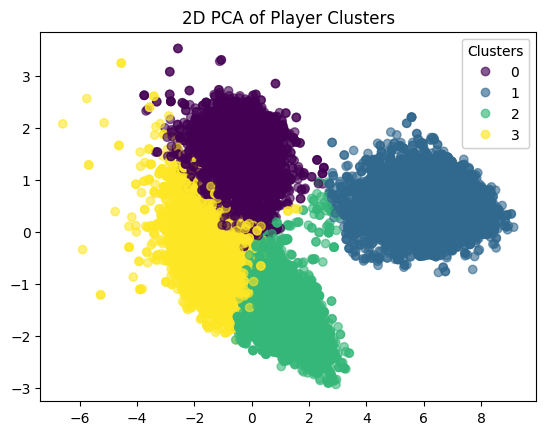

Attacking  Skill  Movement  Power  Mentality  Defending  Goalkeeping  \
Cluster                                                                         
0            62.62  62.90     71.83  65.52      56.89      28.73        11.96   
1            20.22  22.44     50.07  43.43      28.70      18.39        67.87   
2            47.85  47.19     59.88  60.50      54.35      69.75        11.79   
3            58.41  62.13     68.59  66.91      62.47      62.55        12.68   

         avg_overall_rating  count  nunique  
Cluster                                      
0                     69.42  63722     4185  
1                     68.26  14515      897  
2                     68.93  33406     2823  
3                     67.84  68711     5350

In [65]:
kmeans = KMeans(n_clusters=n, random_state=42)
players_cleaned["Cluster"] = kmeans.fit_predict(scaled_data)

# recomputing averages so results are comparable
for category, attributes in attribute_categories.items():
    players_cleaned[category] = players_cleaned[attributes].mean(axis=1)

cluster_summary = players_cleaned.groupby("Cluster")[avg_columns].mean()
cluster_counts = players_cleaned.groupby("Cluster").agg(
    avg_overall_rating=("overall_rating", "mean"),
    count=("player_id", "count"),
    nunique=("player_id", "nunique"),
)
cluster_summary = cluster_summary.join(cluster_counts)
cluster_summary = cluster_summary.round(2)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

scatter = plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=players_cleaned["Cluster"],
    alpha=0.6,
    cmap="viridis",
)

legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)

plt.title("2D PCA of Player Clusters")
plt.show()

display(cluster_summary)

After applying k-means algorithm over 4 clusters on the proportions of skill, we get the following cluster groups:

| **Cluster** | **Color** | **Name**        | **Description**                                                                                                                    |
| ----------- | --------- | --------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| 0           | Purple    | **Forwards**    | Most stats are high, except for low Defending and very low Goalkeeping. This category might contain Attacking Midfielders as well. |
| 1           | Blue      | **Goalkeepers** | High Goalkeeping, other stats are lower. Clearly goalkeepers.                                                                      |
| 2           | Green     | **Defenders**   | Highest Defending, very low goalkeeping, Attacking and Skill are below average.                                                    |
| 3           | Yellow    | **Midfielders** | Well rounded and versatile in stats. Very low Goalkeeping.                                                                         |


### 2.6.3. Player Attributes by Clsutered Positions


Now that we have assigned positions to the players, we can compare to see the differenes between them.


In [66]:
position_mapping = {0: "Forward", 1: "Goalkeeper", 2: "Defender", 3: "Midfielder"}
players_cleaned["Position"] = players_cleaned["Cluster"].replace(position_mapping)

# getting same colors as in cluster PCA chart
num_clusters = players_cleaned["Cluster"].nunique()
color_values = np.linspace(0, 1, num_clusters)
colors_from_viridis = plt.cm.viridis(color_values)

color_mapping = {
    "Forward": colors_from_viridis[0],
    "Goalkeeper": colors_from_viridis[1],
    "Defender": colors_from_viridis[2],
    "Midfielder": colors_from_viridis[3],
}

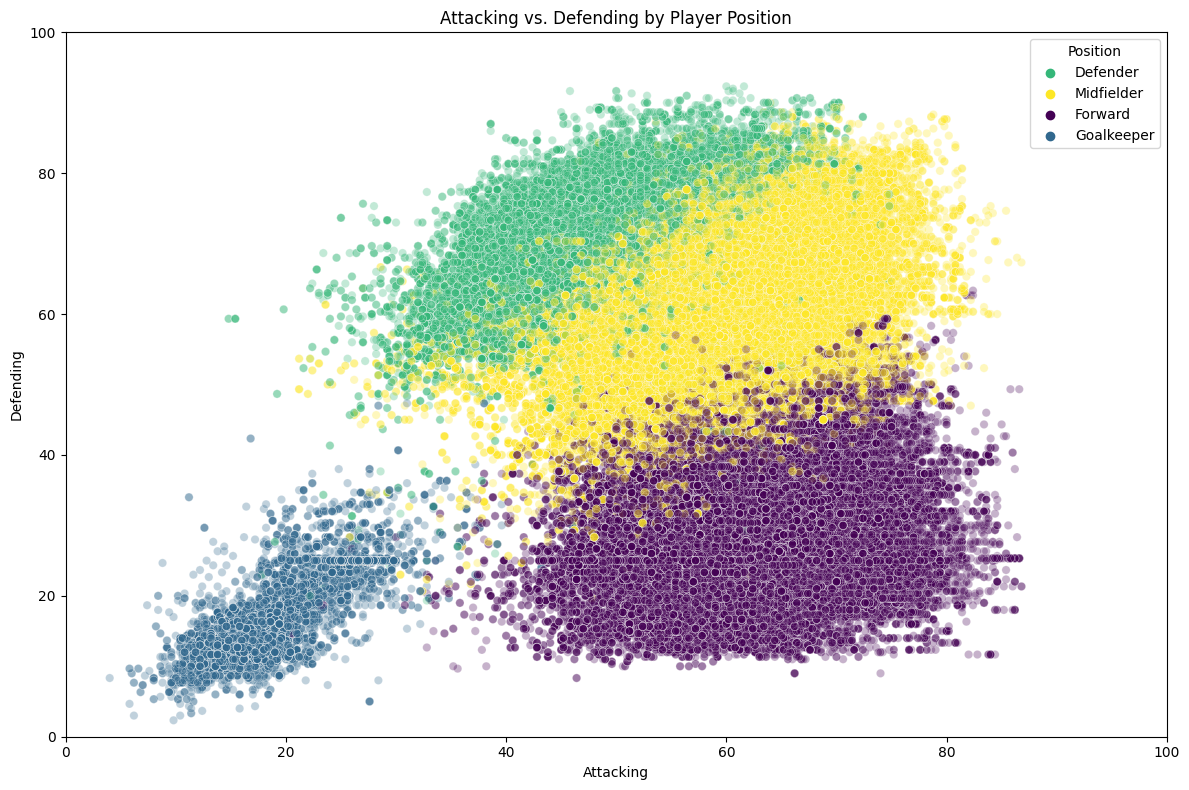

In [67]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=players_cleaned["Attacking"],
    y=players_cleaned["Defending"],
    hue=players_cleaned["Position"],
    palette=color_mapping,
    alpha=0.3,
)

plt.title("Attacking vs. Defending by Player Position")
plt.xlabel("Attacking")
plt.ylabel("Defending")
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.legend(title="Position", loc="best")
plt.tight_layout()
plt.show()

Looking at the scatterplot of Attacking versus Defending, we can get an approximate sense of how well our clustering performed.

- Goalkeepers are distinguished quite well, even though we aren't visualizing the Goalkeeping stats.
- Forwards and Defenders are seperated from each other quite well based on Attacking vs Defending.
- Separating Midfielders from Forwards and Defenders (and vice versa) seems still quite difficult, as there is big overlaps between the clusters. However, this is to be expected, as Midfielder is a very versatile and difficult position to play, involving both offense and defense.


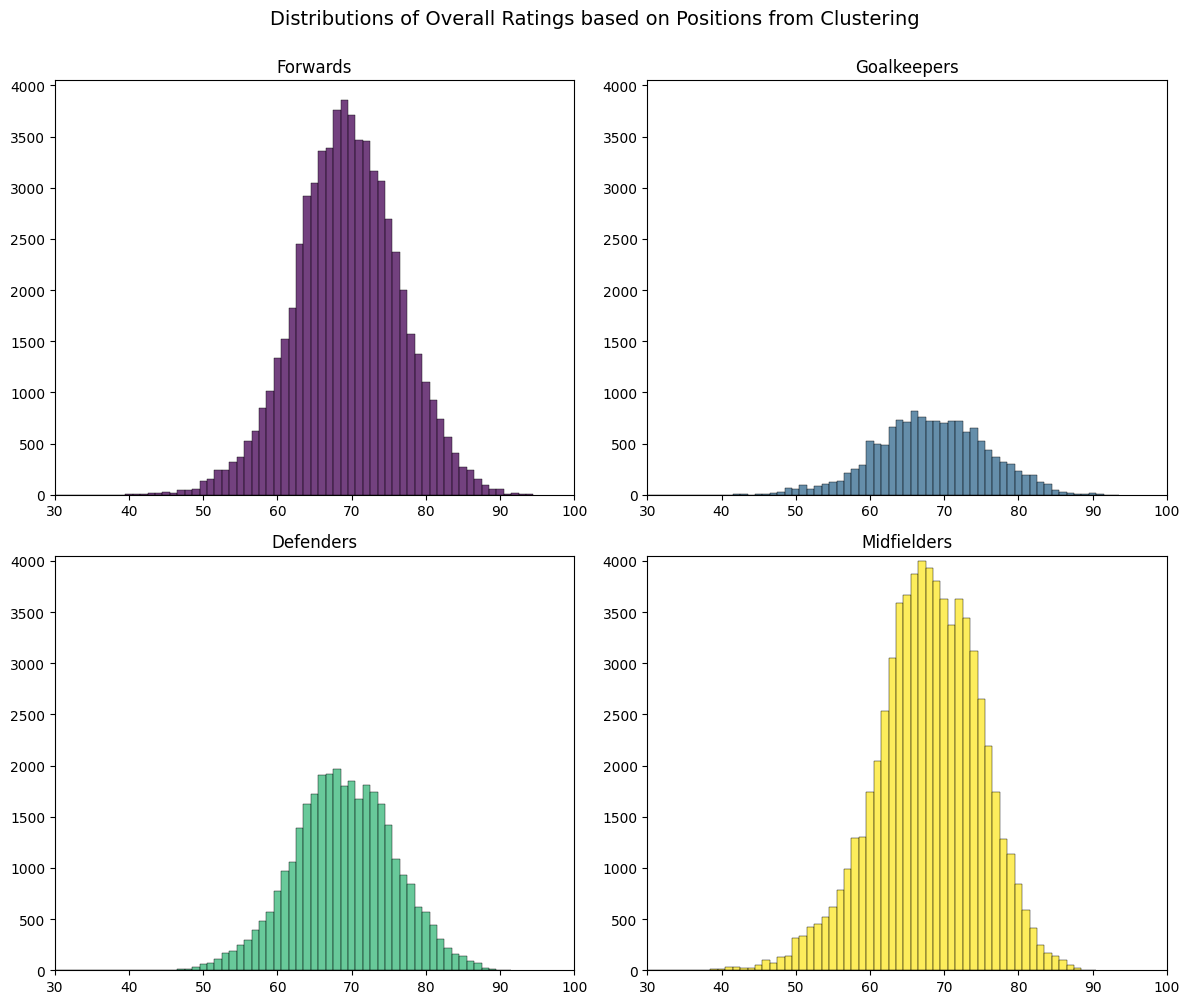

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

positions = ["Forward", "Goalkeeper", "Defender", "Midfielder"]

for i, position in enumerate(positions):
    plt.sca(axes[i])
    data = players_cleaned[players_cleaned["Position"] == position]["overall_rating"]
    color = color_mapping[position]
    my.plot_detailed_histogram(data, color=color)
    axes[i].set_title(position + "s")
    axes[i].set_xlim(30, 100)
    axes[i].set_ylim(0, 4050)

fig.suptitle(
    "Distributions of Overall Ratings based on Positions from Clustering",
    fontsize=14,
    y=1.0,
)
plt.tight_layout()
plt.show()

From the histograms above, we see that all positions follow a normal distribution in regards to overall ratings. Unsuprisingly, we have many less Goalkeepers, as there can be only one Goalkeeper on the field for each team, while it is normal to have several players of each outfield position. Nevertheless, we have more Forwards and Midfielders than Defenders, which shouldn't be the case. This might be due to:

- Forwards being more popular, leading to their stats being updated more often in FIFA games.
- This might be an indicator that there were mistakes in Clustering the data. For example, Attacking Midfielders could be classified as Forwards. Also, it is quite likely that Fullbacks (side Defenders) were clusterd with Midfielders, as they also can participate in a teams offense.


#### Positions by physical attributes


In [69]:
physical_attributes = [
    "height",
    "weight",
    "acceleration",
    "sprint_speed",
    "agility",
    "jumping",
    "stamina",
    "strength",
]

In [70]:
def plot_boxplot_for_attribute(dataframe, column, ax, color_mapping):
    sns.boxplot(
        x=dataframe["Position"],
        y=dataframe[column],
        order=["Forward", "Goalkeeper", "Defender", "Midfielder"],
        palette=color_mapping,
        ax=ax,
    )
    ax.set_title(f"{column.replace('_', ' ').capitalize()}")
    ax.set_xlabel("")
    ax.set_ylabel("")

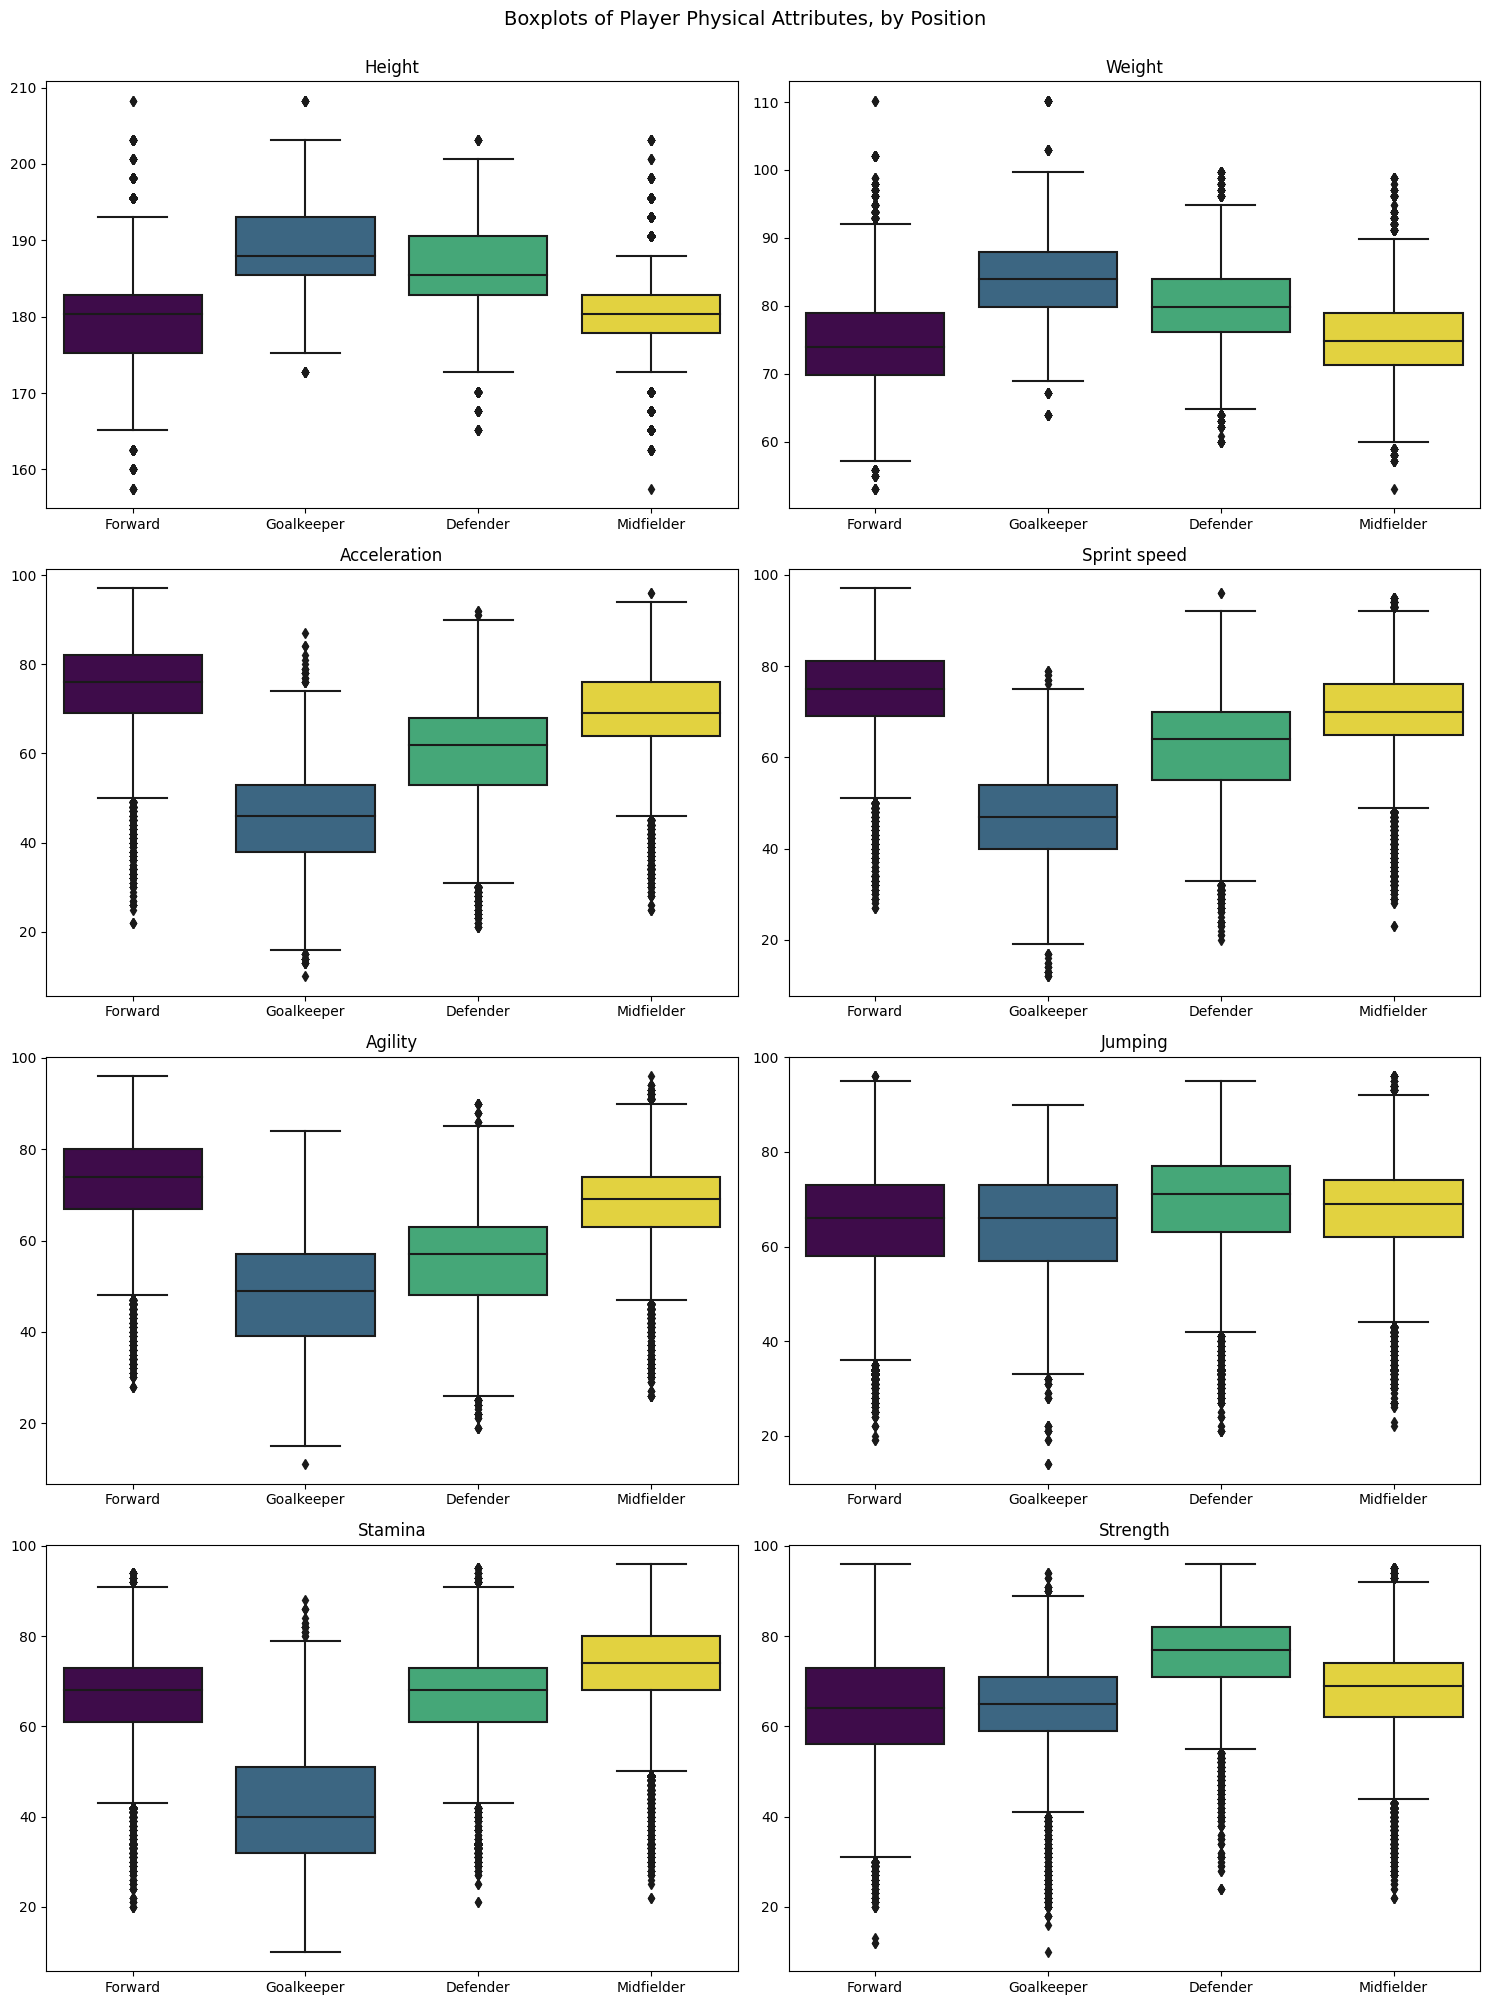

In [71]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, attribute in enumerate(physical_attributes):
    plot_boxplot_for_attribute(players_cleaned, attribute, axes[idx], color_mapping)

fig.suptitle(
    "Boxplots of Player Physical Attributes, by Position",
    fontsize=14,
    y=1.0,
)

plt.tight_layout()
plt.show()

From the boxplots above, we can make the following physical distinctions for each position:

- **Forwards** are shorter in _height_ and _weight_ less than players in other positions. However, they have much higher _acceleration_, _sprint speed_ and _agility_.
- **Midfielders** are very similar to Forwards in terms of _height_ and _weight_. They even have quite similar (yet slightly lower) _acceleration_, _sprint speed_ and _agility_. What makes them different is a higher _stamina_ stat, which is the highest of all positions.
- **Defenders** are _taller_ and _weight_ more than Forwards and Midfielders. The main differentiator is their _strength_ which is marginally higher than the remainder of positions. They also have the highest _jumping_ stat.
- **Goalkeepers** are the tallest and heaviest from all positions. They have significantly lower _movement_ stats, as they don't play outfield as much.


## 2.7. Competitor Analysis


### 2.7.1. Comparison of Markets


In the original **Match** table, the last 30 columns indicate betting odds provided by the competition. The column names were saved in the Data Cleaning part of the notebook.


In [72]:
print(
    f"""The last {len(bet_cols)} in the Match table are odds provided by the betting companies for the following outcomes:
      H - Home team Win
      D - Draw
      A - Away team Win
      """
)
print(
    "The columns are:",
    *bet_cols,
    f"\n giving us {int(len(bet_cols)/3)} betting companies in total.",
)

The last 30 in the Match table are odds provided by the betting companies for the following outcomes:
      H - Home team Win
      D - Draw
      A - Away team Win
      
The columns are: B365H B365D B365A BWH BWD BWA IWH IWD IWA LBH LBD LBA PSH PSD PSA WHH WHD WHA SJH SJD SJA VCH VCD VCA GBH GBD GBA BSH BSD BSA 
 giving us 10 betting companies in total.


In [73]:
betting_companies = []

for i in range(0, len(bet_cols), 3):
    betting_companies.append(bet_cols[i][:-1])

print("The 10 competitors that are present in the dataset are:", *betting_companies)

The 10 competitors that are present in the dataset are: B365 BW IW LB PS WH SJ VC GB BS


Let's see which competitors provide odds for which leagues, according to the data that was collected.


In [74]:
def betting_percentage(df, columns, groupby_col):
    """
    Calculate the percentage of valid bets for specified columns grouped by a given column.

    Parameters:
    - df (pd.DataFrame): The input dataframe containing match and betting data.
    - columns (list): A list of column names in df representing betting odds.
    - groupby_col (str): The column by which the dataframe should be grouped to calculate percentages.

    Returns:
    - pd.DataFrame: A dataframe with the specified column and the calculated percentage of valid bets.
    """

    valid_bets_df = df.dropna(subset=columns, how="all")
    valid_counts = valid_bets_df.groupby(groupby_col).size()
    total_counts = df.groupby(groupby_col).size()

    percentage = (valid_counts / total_counts).fillna(0) * 100

    return percentage.reset_index(name="percentage")

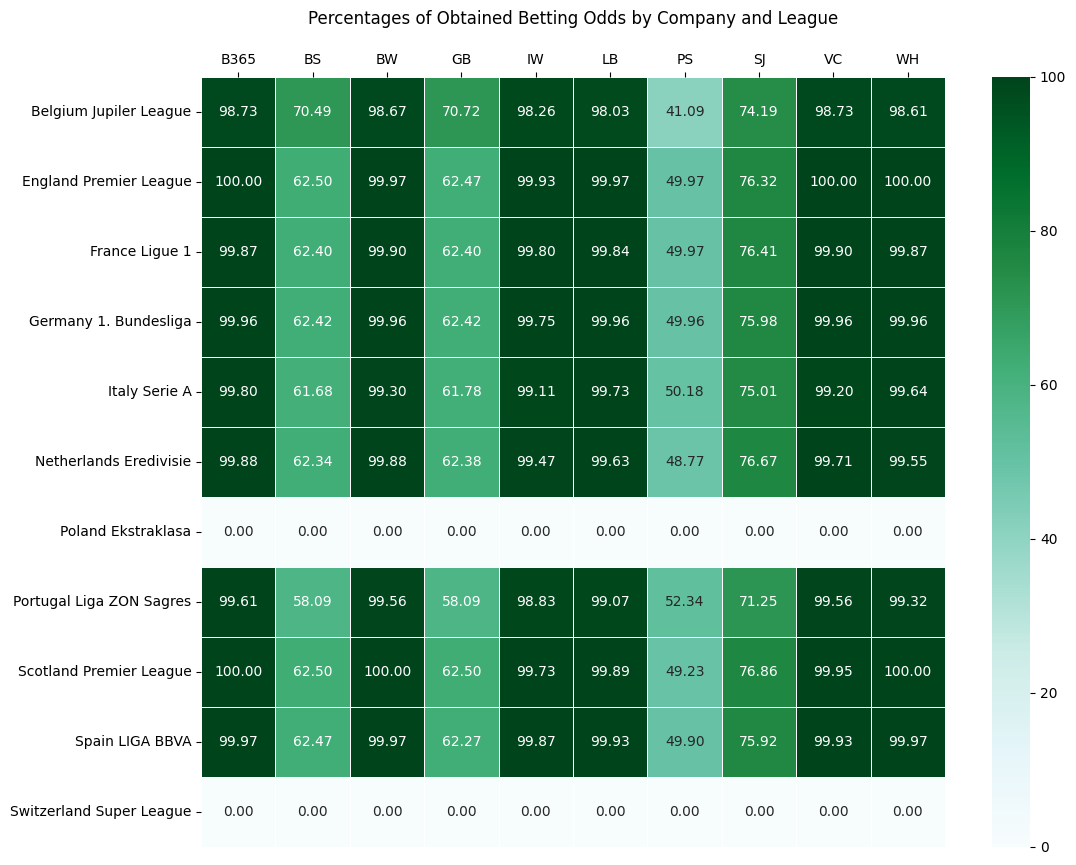

In [75]:
all_results = []

for company in betting_companies:
    columns = [f"{company}{suffix}" for suffix in ["H", "D", "A"]]
    company_df = betting_percentage(match_data, columns, groupby_col="league_id")
    company_df["company"] = company
    all_results.append(company_df)

market_saturation = pd.concat(all_results, ignore_index=True)

market_saturation = market_saturation.merge(
    leagues[["league_id", "league"]], on="league_id", how="left"
)

heatmap_data = market_saturation.pivot_table(
    index="league", columns="company", values="percentage"
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data, cmap="BuGn", annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=100
)
plt.title("Percentages of Obtained Betting Odds by Company and League\n")
plt.gca().xaxis.tick_top()
plt.xlabel("")
plt.ylabel("")

plt.show()

From the **heatmap above**, we see that we don't have any betting odds for Poland and Switzerland leagues. This might be due to difficulty in obtaining the data, or barriers to entry into the markets.

We have most of the odds for: B365, BW, IW, LB, VC and WH, whereas we have over > 45% but less than < 80% of data for the remaining companies: BS, GB, PS and SJ.

Now, looking at the **heatmap below**, showing the percentage of betting odds we have by season, we can speculate that PS entered the market at the beginning of 2012/2013 season. On the other hand, we don't have any betting odds for **BS** and **GB** since 2013/2014, which might indicate them leaving the market, or difficulties in obtaining the data. In any case, we can see that for the seasons and companies we do have, the proportion of data present is more or less consistent at around 87%.


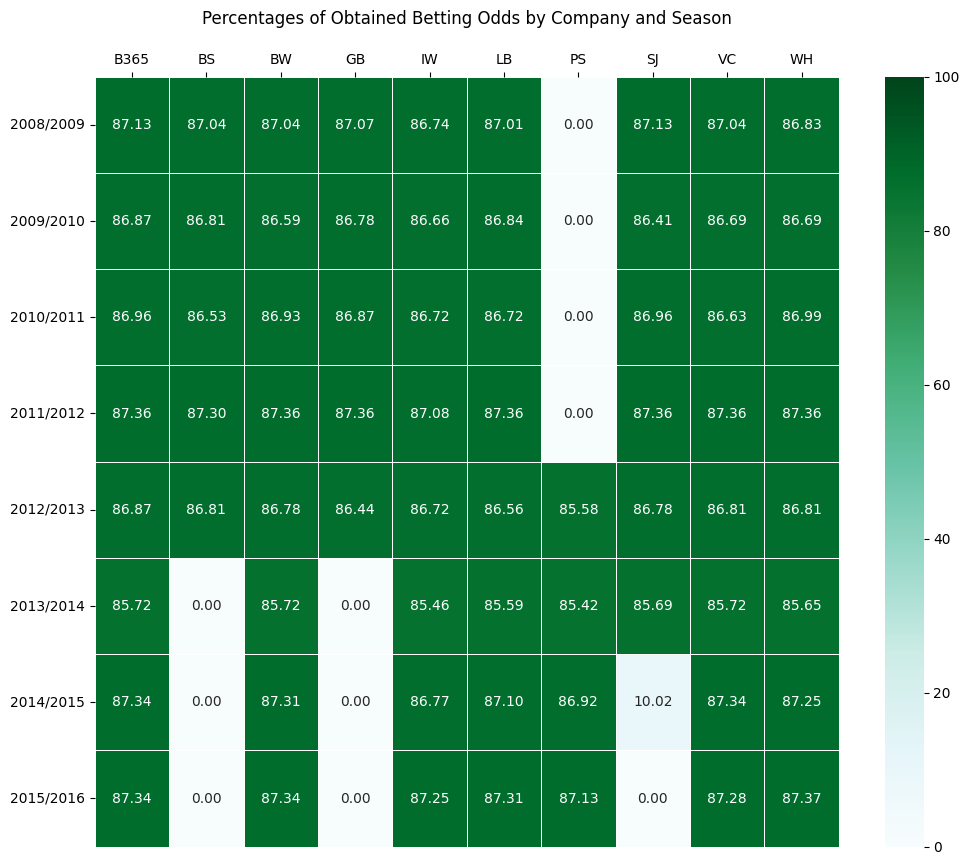

In [76]:
all_results = []

for company in betting_companies:
    columns = [f"{company}{suffix}" for suffix in ["H", "D", "A"]]
    company_df = betting_percentage(match_data, columns, groupby_col="season")
    company_df["company"] = company
    all_results.append(company_df)

market_saturation = pd.concat(all_results, ignore_index=True)

heatmap_data = market_saturation.pivot_table(
    index="season", columns="company", values="percentage"
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data, cmap="BuGn", annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=100
)
plt.title("Percentages of Obtained Betting Odds by Company and Season\n")
plt.gca().xaxis.tick_top()
plt.gca().set_yticklabels(
    plt.gca().get_yticklabels(), rotation=0, horizontalalignment="right"
)
plt.xlabel("")
plt.ylabel("")

plt.show()

### 2.7.2 Competitor Prediction Models Evalaution


#### Accuracy

Now let's see which of the companies perform best in predicting the outcome of the match. We will use the lowest number in odds provided as the outcome predicted by the betting company.


In [77]:
# mapping companies to colors for consistency
colors = sns.color_palette("tab10", 10)
color_mapping = dict(zip(sorted(betting_companies), colors))

In [78]:
def compute_accuracy(predictions, actual_outcomes):
    """
    Compute the accuracy of predictions against actual outcomes.

    :param predictions: Series of predictions.
    :param actual_outcomes: Series of actual outcomes.
    :return: accuracy as a percentage.
    """
    return (predictions == actual_outcomes).mean()

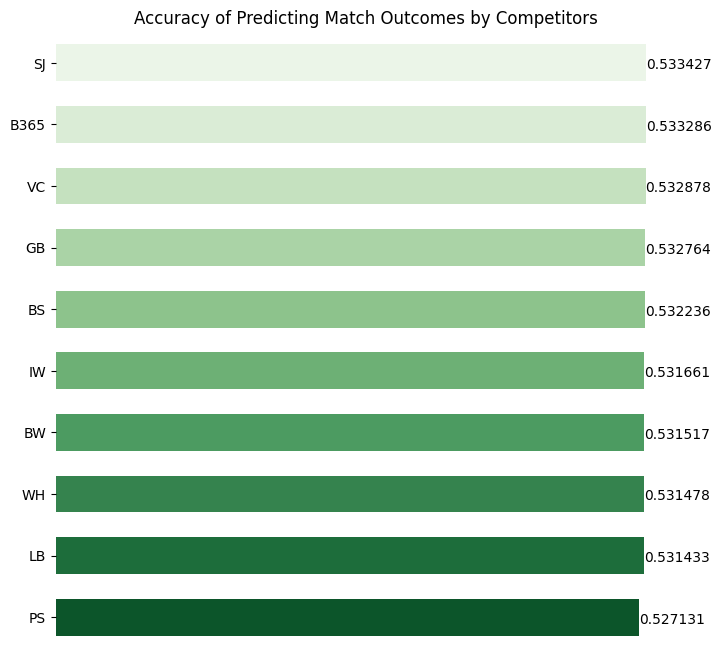

In [79]:
accuracies = {}

for company in betting_companies:
    columns = [f"{company}{suffix}" for suffix in ["H", "D", "A"]]

    bets = match_data[columns + ["winner"]].dropna()

    bets["prediction"] = bets[columns].idxmin(axis=1)
    bets["prediction"] = bets["prediction"].replace(
        {f"{company}H": "Home", f"{company}D": "Draw", f"{company}A": "Away"}
    )

    accuracy = compute_accuracy(bets["prediction"], bets["winner"])
    accuracies[company] = accuracy

accuracy_df = pd.DataFrame(
    list(accuracies.items()), columns=["Company", "Accuracy"]
).sort_values(by="Accuracy", ascending=False)


plt.figure(figsize=(8, 8))
my.plot_horiz_barchart(
    df=accuracy_df, names="Company", values="Accuracy", decimals=6, order=True
)
plt.title("Accuracy of Predicting Match Outcomes by Competitors")

plt.show()

From the barplot above, we see that other betting companies are able to predict match outcomes with 52.7%-53.3% accuracy, which is quite good, considering there are three possible outcomes.


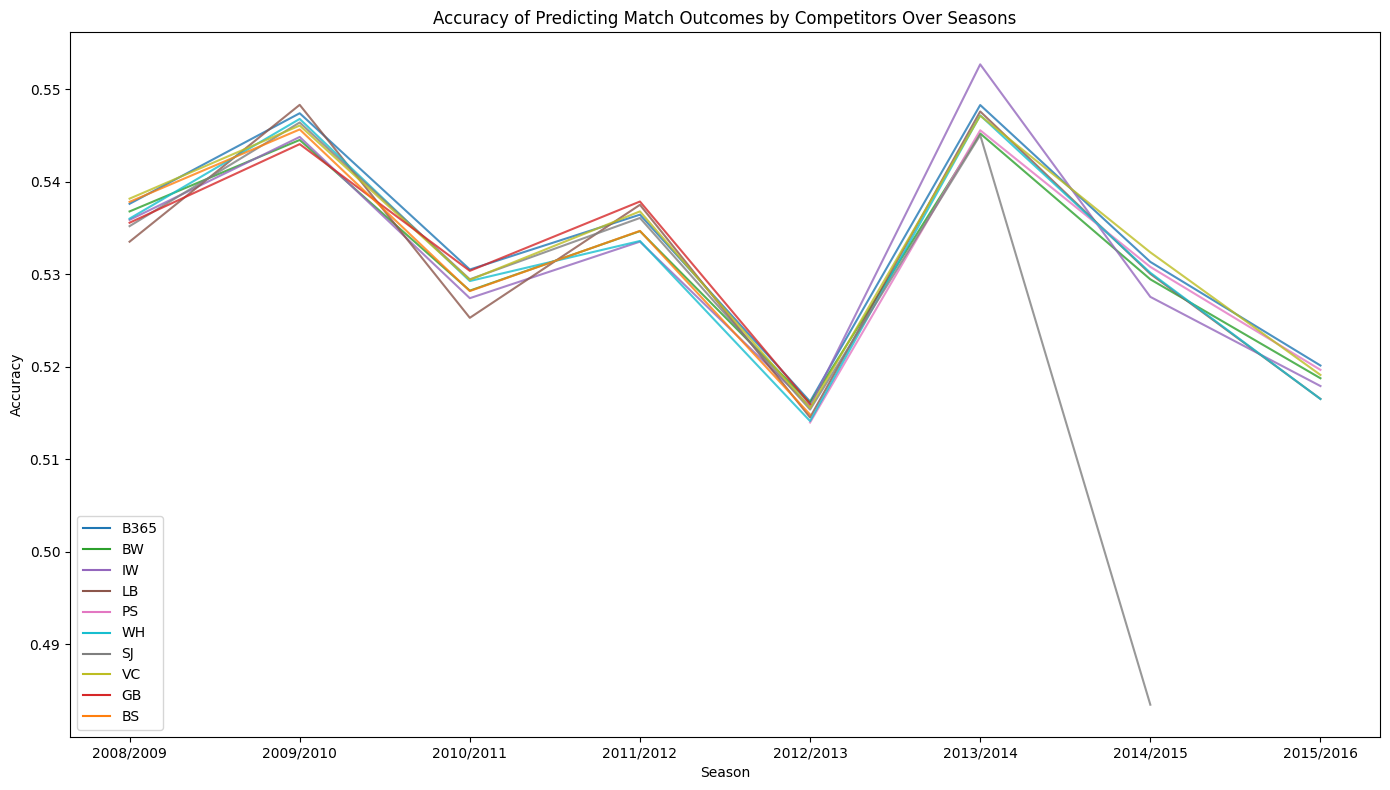

In [80]:
results = []

for company in betting_companies:
    columns = [f"{company}{suffix}" for suffix in ["H", "D", "A"]]

    bets = match_data[columns + ["winner", "season"]].dropna()

    bets["prediction"] = bets[columns].idxmin(axis=1)
    bets["prediction"] = bets["prediction"].replace(
        {f"{company}H": "Home", f"{company}D": "Draw", f"{company}A": "Away"}
    )

    season_accuracies = bets.groupby("season").apply(
        lambda x: compute_accuracy(x["prediction"], x["winner"])
    )

    for season, accuracy in season_accuracies.items():
        results.append({"Company": company, "Season": season, "Accuracy": accuracy})

season_accuracy_df = pd.DataFrame(results)

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=season_accuracy_df,
    x="Season",
    y="Accuracy",
    hue="Company",
    palette=color_mapping,
    alpha=0.8,
)
plt.title("Accuracy of Predicting Match Outcomes by Competitors Over Seasons")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

Looking at accuracy over seasons, we see that companies perform quite similarly in terms of accuracy. For all companies, the 2013/2014 was easiest to predict with accuracy of ~0.547, whereas the previous season 2012/2013 was hardest with the accuracy of ~0.515. **SJ** had a really rought 2014/2015 season, after which, we don't have any further data. They only offered odds for 10% of the matches that season, which probably means A) They exited the market after starting the season on a loss, B) Missing Data, or C) exit from market is unrelated, and the lower accuracy is due to variance and smaller sample size.


#### Other metrics


In [81]:
outcomes = ["Home", "Draw", "Away"]

In [82]:
classification_reports = {}

for company in betting_companies:
    columns = [f"{company}{suffix}" for suffix in ["H", "D", "A"]]

    bets = match_data[columns + ["winner"]].dropna()

    bets["prediction"] = bets[columns].idxmin(axis=1)
    bets["prediction"] = bets["prediction"].replace(
        {f"{company}H": "Home", f"{company}D": "Draw", f"{company}A": "Away"}
    )

    report = classification_report(bets["winner"], bets["prediction"], labels=outcomes)
    classification_reports[company] = report

In [83]:
print(classification_reports["B365"])

              precision    recall  f1-score   support

        Home       0.54      0.86      0.67     10371
        Draw       0.57      0.00      0.01      5716
        Away       0.51      0.48      0.49      6505

    accuracy                           0.53     22592
   macro avg       0.54      0.45      0.39     22592
weighted avg       0.54      0.53      0.45     22592



In the code above, we made a _classification_reports_ dictionary, holding classification reports for each competitor company. For example, we see that company **B365** has an accuracy of 0.53, with _precision_ for all categories being somewhat similar, while _recall_ for _Home wins_ being very high and extremely low for _Draw_ outcomes.

Next, we will be taking a look at how well does the average of all bookmakers performs in predicting match outcomes. In the code below we are calculating the averages of odds for each match, and the lowest odds as the predicted outcome.


In [84]:
average_odds = match_data[["winner"]].dropna().copy()

for outcome in ["H", "D", "A"]:
    average_odds[f"avg_{outcome}"] = match_data[
        [f"{company}{outcome}" for company in betting_companies]
    ].mean(axis=1)

conditions = [
    (average_odds["avg_H"] < average_odds["avg_D"])
    & (average_odds["avg_H"] < average_odds["avg_A"]),
    (average_odds["avg_D"] < average_odds["avg_H"])
    & (average_odds["avg_D"] < average_odds["avg_A"]),
    (average_odds["avg_A"] < average_odds["avg_H"])
    & (average_odds["avg_A"] < average_odds["avg_D"]),
]
choices = ["Home", "Draw", "Away"]
average_odds["prediction"] = np.select(conditions, choices, default="Draw")

comp_avg_metrics = classification_report(
    average_odds["winner"], average_odds["prediction"], labels=outcomes
)
print(comp_avg_metrics)

              precision    recall  f1-score   support

        Home       0.54      0.75      0.63     11917
        Draw       0.26      0.14      0.18      6596
        Away       0.50      0.42      0.46      7466

    accuracy                           0.50     25979
   macro avg       0.44      0.43      0.42     25979
weighted avg       0.46      0.50      0.47     25979



We see that the total average of odds has a lower _accuracy_ than each company individually. Moreover, the average of odds predicts Draws with a much lower _precision_ and higher _recall_.


### 2.7.3. Overround Analysis


Overround is the betting companies' profit margin if the books were balanced perfectly to take equal money on all outcomes. It is calculated as:

$ Overround = (Total Probability − 1) \times 100\% $

A lower overround should be more attractive to costumers, as their ROI (Return On Investment) should be higher for them.


In [85]:
def calculate_overround(row, columns):
    prob_home = 1 / row[columns[0]] if row[columns[0]] else 0
    prob_draw = 1 / row[columns[1]] if row[columns[1]] else 0
    prob_away = 1 / row[columns[2]] if row[columns[2]] else 0

    total_prob = prob_home + prob_draw + prob_away
    overround = (total_prob - 1) * 100  # Convert to percentage

    return overround

In [86]:
overround_results = []

for company in betting_companies:
    cols = [f"{company}{suffix}" for suffix in ["H", "D", "A"]]
    temp_df = match_data[["season", "league_id"] + cols].dropna()
    temp_df["overround"] = temp_df.apply(
        lambda row: calculate_overround(row, cols), axis=1
    )
    temp_df["company"] = company
    overround_results.append(temp_df[["season", "league_id", "company", "overround"]])

overround_df = pd.concat(overround_results, ignore_index=True)

In [87]:
season_overrounds = (
    overround_df.groupby(["season", "company"])["overround"].mean().reset_index()
)

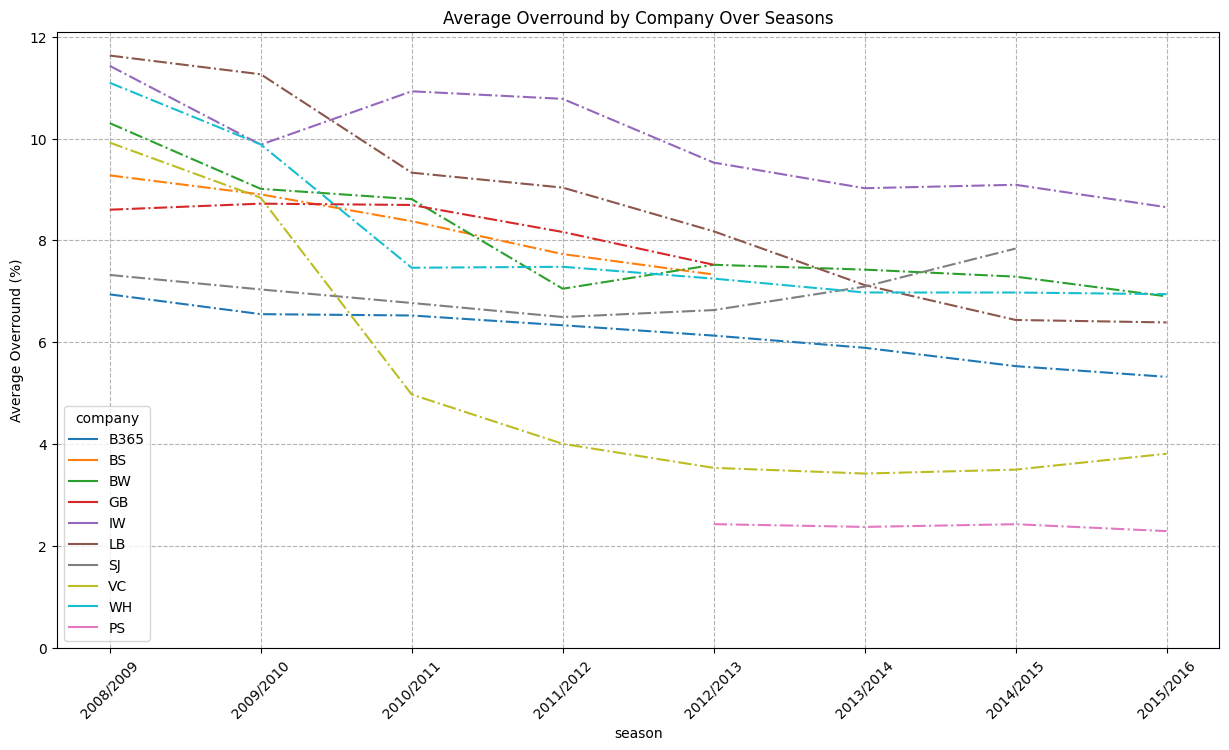

In [88]:
plt.figure(figsize=(15, 8))

grouped = overround_df.groupby(["season", "company"])["overround"].mean().reset_index()

sns.lineplot(
    data=grouped,
    x="season",
    y="overround",
    hue="company",
    palette=color_mapping,
    ls="-.",
)

plt.title("Average Overround by Company Over Seasons")
plt.ylabel("Average Overround (%)")
plt.ylim(0)
plt.xticks(rotation=45)
plt.grid(True, which="both", ls="--", c="0.7")

plt.show()

From the lineplot above, we see a trend of decreasing overround, indicating increasing competition in the market. In 2008/2009 the range was 7%-11.8%, while in 2015/2016 the range was 2%-9%. This increases pressure for the companies to predict the outcomes better in order to stay profitable.

- Since 2010/2011 season, **IW** remained as the company offering worst odds for the consumer (= highest overround).
- **PS**, most likely a new entrant in the market, is trying to attract customers by providing more favourable odds for the bettors.


# 3. Statistical Inferentce


## 3.1. Is there such a thing as home advantage?


**$H_{1N}$**: Being the home team does not give any advantage or disadvantage in winning the game.

**$H_{1A}$**: There is a statistically significant home advantage or disadvantage in winning the game.

**Population**: 25'979 matches in the 11 predefined European Football leagues for seasons 2008/2009 - 2015/2016. This is quite close to true population (limited by season and leagues), as most of the matches were scraped.

**Assumptions**:

- Each team plays each other both at home and away.
- In all games, all teams and players give equal effort, and there is no trying to "game" the points system and season rankings.

**Required alpha** <= 0.01

**Statistical test**: **chi-squared test**

We will be looking at only two outcomes: Win and not-win (Loose + Draw). Otherwise, the relationship between Home and Away team results is perferctly inverse and we would be testing a relationship we know mathematically to be true (Home Win == Away Lose, Home Lose == Away Win, Home Draw == Away Draw).


In [89]:
alpha = 0.01

In [90]:
home_wins = len(match_data[(match_data["winner"] == "Home")])
home_not_wins = len(match_data) - home_wins

away_wins = len(match_data[(match_data["winner"] == "Away")])
away_not_wins = len(match_data) - away_wins

contingency_table = [[home_wins, home_not_wins], [away_wins, away_not_wins]]

contingency_df = pd.DataFrame(
    contingency_table, columns=["Win", "Draw or Loose"], index=["Home", "Away"]
)

display(contingency_df)

chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_val:.6f}")

print(f"Reject the Null Hypothesis: {p_val < alpha}")

Win  Draw or Loose
Home  11917          14062
Away   7466          18513

Chi-squared Statistic: 1629.55
P-value: 0.000000
Reject the Null Hypothesis: True


With the p-value below 0.01, we reject the null hypothesis, and state that there is in fact a home court advantage in terms of winning the games.

To further validate our results, let's look at:

1. the predicted proportions by betting companies, computed from odds.
2. the proportions of wins in our dataset.


In [91]:
avg_home_odds = (
    match_data[[f"{company}H" for company in betting_companies]].mean().mean()
)
avg_draw_odds = (
    match_data[[f"{company}D" for company in betting_companies]].mean().mean()
)
avg_away_odds = (
    match_data[[f"{company}A" for company in betting_companies]].mean().mean()
)

dataset_prop = match_data.winner.value_counts() / len(match_data) * 100

proportions = {
    "Outcomes": ["Home Win", "Draw", "Away Win"],
    "Odds": [avg_home_odds, avg_draw_odds, avg_away_odds],
    "Data": [
        dataset_prop["Home"],
        dataset_prop["Draw"],
        dataset_prop["Away"],
    ],
}

proportions = pd.DataFrame(proportions)

# Callculating Probabilities according to Betting companies
proportions["Bookmaker"] = 1 / proportions["Odds"]
# Adjusting for overround
overround = proportions["Bookmaker"].sum()
proportions["Bookmaker"] = proportions["Bookmaker"] / overround * 100

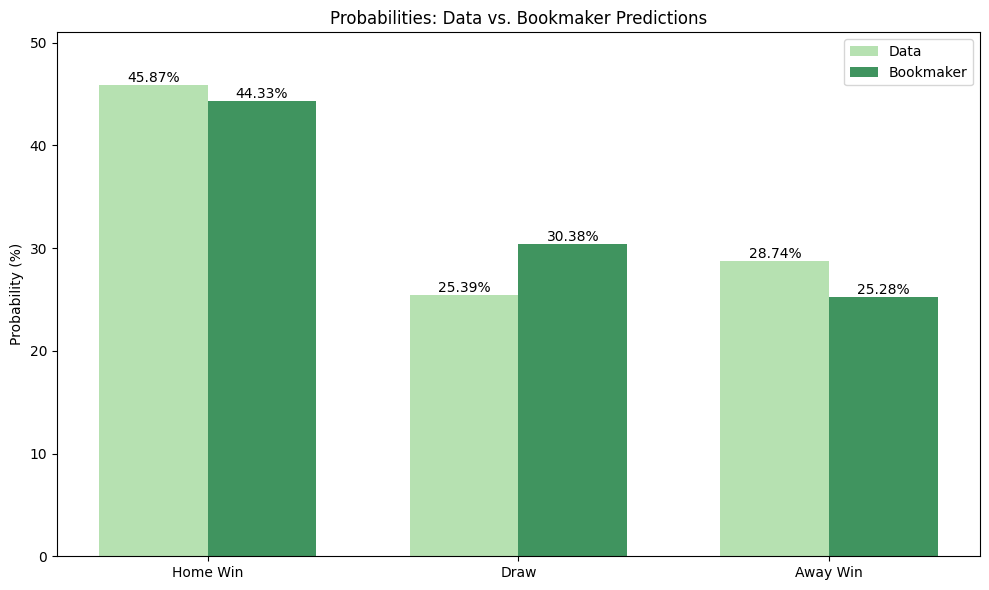

In [92]:
greens = sns.color_palette("Greens", n_colors=10)

darker_green = greens[-2]
lighter_green = greens[3]

bar_positions = np.arange(len(proportions["Outcomes"]))

width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Data probabilities
bars1 = ax.bar(
    bar_positions - width / 2,
    proportions["Data"],
    width,
    color=lighter_green,
    alpha=0.8,
    label="Data",
)

# Bookmaker probabilities
bars2 = ax.bar(
    bar_positions + width / 2,
    proportions["Bookmaker"],
    width,
    color=darker_green,
    alpha=0.8,
    label="Bookmaker",
)

ax.set_ylabel("Probability (%)")
plt.ylim(0, 51)
ax.set_xticks(bar_positions)
ax.set_xticklabels(proportions["Outcomes"])


for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{round(yval, 2)}%",
            ha="center",
            va="bottom",
        )

ax.legend(loc="upper right")

plt.title("Probabilities: Data vs. Bookmaker Predictions")

plt.tight_layout()
plt.show()

From the barchart above, we see that both in data and in predictions of betting companies, there seems to be a home field advantage with around 45% (quite above 33% if we would assume all 3 outcomes are equally likely). What's interestign to note is that betting companies follow the proportions in our data quite well, the main difference being overpredicting Draws, and underpredicting Away wins.


## 3.2. Teams with higher defensive tendencies and lower buildup tendencies are more likely to perform better.


In the analysis of Teams and Team Attributes, we found that, on average, champion club defensive tendencies were higher, while their buildup tendencies seemed lower compared to the rest of the teams. We will be testing if the combination of these tendencies is significant. At the same time, we will check if these tendencies correlate with performance for all teams and not just the champions.

**$H_{1N}$**: Combination of defensive and buildup tendencies has no affect on a teams performance.

**$H_{1A}$**: There is difference in teams performance (season points gained) based on teams combined buildup and defensive tendencies.

**Population**: 39'832 team appearances in matches (2 teams per match) of the 11 predefined European Football leagues for seasons 2008/2009 - 2015/2016. Teams with no data on tendencies that could be gathered before the match were not included, as that will not help us in our forecasting model.

**Assumptions**:

- Tendencies in FIFA games are accurately representing team tendencies.
- Data on team tendencies is updated in a timely manner.
- Team tendnecies do not change drastically between or during the matches.

**Required alpha** <= 0.01

**Statistical test**: **ANOVA**

We will be categorizing teams based on their tendencies, and, seeing how many points, on average, do these teams gain.


In [93]:
def merge_team_data(match_df, teams_df, columns_to_merge):
    merged_df = match_df.copy()

    for side in ["home", "away"]:
        temp_df = teams_df[["team_id", "date"] + columns_to_merge]

        # renaming columns to home_ or away_ to avoid collision during the merge
        temp_df.columns = [
            f"{side}_team_{col}" if col not in ["team_id", "date"] else col
            for col in temp_df.columns
        ]

        # Merging data using a lambda function to ensure the team's date is the latest before the match date
        for index, row in merged_df.iterrows():
            team_data = (
                temp_df[
                    (temp_df["team_id"] == row[f"{side}_team_id"])
                    & (temp_df["date"] < row["date"])
                ]
                .sort_values(by="date", ascending=False)
                .head(1)
            )

            for col in columns_to_merge:
                merged_df.at[index, f"{side}_team_{col}"] = (
                    team_data[f"{side}_team_{col}"].values[0]
                    if not team_data.empty
                    else np.nan
                )

    return merged_df

In [94]:
teams_df = merge_team_data(
    match_data,
    teams,
    [
        "buildUpPlaySpeed",
        "buildUpPlayPassing",
        "defencePressure",
        "defenceAggression",
        "defenceTeamWidth",
    ],
)
teams_df.head(2)

country_id  league_id     season  stage       date  match_api_id  \
match_id                                                                     
2                  1          1  2008/2009      1 2008-08-16        492474   
3                  1          1  2008/2009      1 2008-08-16        492475   

          home_team_id  away_team_id  home_team_goal  away_team_goal  \
match_id                                                               
2                10000          9994               0               0   
3                 9984          8635               0               3   

          home_player_X1  home_player_X2  home_player_X3  home_player_X4  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   
3                    NaN             NaN             NaN             NaN   

          home_player_X5  home_player_X6  home_player_X7  home_player_X8  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   
3                    NaN             NaN             NaN             NaN   

          home_player_X9  home_player_X10  home_player_X11  away_player_X1  \
match_id                                                                     
2                    NaN              NaN              NaN             NaN   
3                    NaN              NaN              NaN             NaN   

          away_player_X2  away_player_X3  away_player_X4  away_player_X5  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   
3                    NaN             NaN             NaN             NaN   

          away_player_X6  away_player_X7  away_player_X8  away_player_X9  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   
3                    NaN             NaN             NaN             NaN   

          away_player_X10  away_player_X11  home_player_Y1  home_player_Y2  \
match_id                                                                     
2                     NaN              NaN             NaN             NaN   
3                     NaN              NaN             NaN             NaN   

          home_player_Y3  home_player_Y4  home_player_Y5  home_player_Y6  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   
3                    NaN             NaN             NaN             NaN   

          home_player_Y7  home_player_Y8  home_player_Y9  home_player_Y10  \
match_id                                                                    
2                    NaN             NaN             NaN              NaN   
3                    NaN             NaN             NaN              NaN   

          home_player_Y11  away_player_Y1  away_player_Y2  away_player_Y3  \
match_id                                                                    
2                     NaN             NaN             NaN             NaN   
3                     NaN             NaN             NaN             NaN   

          away_player_Y4  away_player_Y5  away_player_Y6  away_player_Y7  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   
3                    NaN             NaN             NaN             NaN   

          away_player_Y8  away_player_Y9  away_player_Y10  away_player_Y11  \
match_id                                                                     
2                    NaN             NaN              NaN              NaN   
3                    NaN             NaN              NaN              NaN   

          home_player

In [95]:
cols_to_drop = [
    "country_id",
    "league_id",
    "goal",
    "shoton",
    "shotoff",
    "foulcommit",
    "card",
    "cross",
    "corner",
    "possession",
] + list(bet_cols)
for side in ["home", "away"]:
    for i in range(1, 12):
        cols_to_drop.append(f"{side}_player_X{i}")
        cols_to_drop.append(f"{side}_player_Y{i}")

In [96]:
teams_df = teams_df.drop(columns=cols_to_drop)
teams_df.head(2)

season  stage       date  match_api_id  home_team_id  \
match_id                                                            
2         2008/2009      1 2008-08-16        492474         10000   
3         2008/2009      1 2008-08-16        492475          9984   

          away_team_id  home_team_goal  away_team_goal  home_player_1  \
match_id                                                                
2                 9994               0               0            NaN   
3                 8635               0               3            NaN   

          home_player_2  home_player_3  home_player_4  home_player_5  \
match_id                                                               
2                   NaN            NaN            NaN            NaN   
3                   NaN            NaN            NaN            NaN   

          home_player_6  home_player_7  home_player_8  home_player_9  \
match_id                                                               
2                   NaN            NaN            NaN            NaN   
3                   NaN            NaN            NaN            NaN   

          home_player_10  home_player_11  away_player_1  away_player_2  \
match_id                                                                 
2                    NaN             NaN            NaN            NaN   
3                    NaN             NaN            NaN            NaN   

          away_player_3  away_player_4  away_player_5  away_player_6  \
match_id                                                               
2                   NaN            NaN            NaN            NaN   
3                   NaN            NaN            NaN            NaN   

          away_player_7  away_player_8  away_player_9  away_player_10  \
match_id                                                                
2                   NaN            NaN            NaN             NaN   
3                   NaN            NaN            NaN             NaN   

          away_player_11  total_goals  win_margin winner  home_team_points  \
match_id                                                                     
2                    NaN            0           0   Draw                 1   
3                    NaN            3           3   Away                 0   

          away_team_points goal_data  home_team_buildUpPlaySpeed  \
match_id                                                           
2                        1        []                         NaN   
3                        3        []                         NaN   

          home_team_buildUpPlayPassing  home_team_defencePressure  \
match_id                                                            
2                                  NaN                        NaN   
3                                  NaN                        NaN   

          home_team_defenceAggression  home_team_defenceTeamWidth  \
match_id                                                            
2                                 NaN                         NaN   
3                                 NaN                         NaN   

          away_team_buildUpPlaySpeed  away_team_buildUpPlayPassing  \
match_id                                                             
2                                NaN                           NaN   
3                                NaN                           NaN   

          away_team_defencePressure  away_team_defenceAggression  \
match_id                                                           
2                               NaN                          NaN   
3                               NaN                          NaN   

          away_team_defenceTeamWidth  
match_id                              
2                                NaN  
3                                NaN

In [97]:
home_df = teams_df[
    [
        "match_api_id",
        "home_team_id",
        "home_team_defenceTeamWidth",
        "home_team_buildUpPlayPassing",
        "home_team_defencePressure",
        "home_team_defenceAggression",
        "home_team_buildUpPlaySpeed",
        "home_team_points",
    ]
].copy()

away_df = teams_df[
    [
        "match_api_id",
        "away_team_id",
        "away_team_defenceTeamWidth",
        "away_team_buildUpPlayPassing",
        "away_team_defencePressure",
        "away_team_defenceAggression",
        "away_team_buildUpPlaySpeed",
        "away_team_points",
    ]
].copy()

# Renaming columns
column_names = [
    "match_id",
    "team_id",
    "defenceTeamWidth",
    "buildUpPlayPassing",
    "defencePressure",
    "defenceAggression",
    "buildUpPlaySpeed",
    "points",
]
home_df.columns = column_names
away_df.columns = column_names

home_df["side"] = "home"
away_df["side"] = "away"

tendencies_df = pd.concat([home_df, away_df], ignore_index=True)

tendencies_df["defence"] = tendencies_df[
    ["defenceTeamWidth", "defencePressure", "defenceAggression"]
].mean(axis=1)
tendencies_df["buildup"] = tendencies_df[
    ["buildUpPlayPassing", "buildUpPlaySpeed"]
].mean(axis=1)

display(count_missing_values(tendencies_df).T)

defenceTeamWidth  buildUpPlayPassing  defencePressure  \
Missing Values      12126.000000        12126.000000     12126.000000   
Percentage             23.338081           23.338081        23.338081   

                defenceAggression  buildUpPlaySpeed       defence  \
Missing Values       12126.000000      12126.000000  12126.000000   
Percentage              23.338081         23.338081     23.338081   

                     buildup  
Missing Values  12126.000000  
Percentage         23.338081

In [98]:
tendencies_df = tendencies_df.dropna()
display(count_missing_values(tendencies_df).T)

display(tendencies_df.head(2))

Empty DataFrame
Columns: []
Index: [Missing Values, Percentage]

match_id  team_id  defenceTeamWidth  buildUpPlayPassing  \
3508    665677     9984              70.0                35.0   
3509    665694     9999              70.0                60.0   

      defencePressure  defenceAggression  buildUpPlaySpeed  points  side  \
3508             65.0               60.0              45.0       3  home   
3509             65.0               70.0              65.0       1  home   

        defence  buildup  
3508  65.000000     40.0  
3509  68.333333     62.5

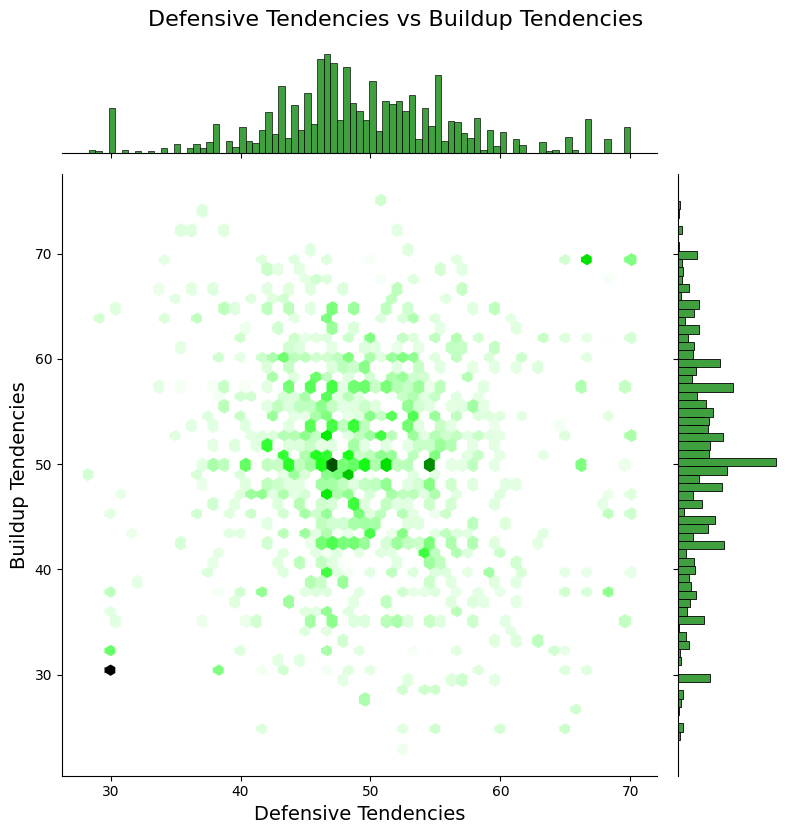

Pearson correlation (defensive and buildup): 0.0501


In [99]:
joint = sns.jointplot(
    data=tendencies_df, x="defence", y="buildup", kind="hex", height=8, color="green"
)

joint.fig.suptitle("Defensive Tendencies vs Buildup Tendencies", fontsize=16, y=1.03)
joint.set_axis_labels("Defensive Tendencies", "Buildup Tendencies", fontsize=14)

plt.show()

correlation = tendencies_df["defence"].corr(tendencies_df["buildup"])
print(f"Pearson correlation (defensive and buildup): {correlation:.4f}")

In the hexbin plot above, we see the distributions of defensive and buildup tendencies, as well as the relationship between them. There doesn't seem to be any correlation. Both tendencies do have somewhat of a bell-curve shape, but have many outliers in the data. Moreover, a lot of values are concentrated on the **50** level. Therefore, we will be using 50 as the cut-off point for classifying our data into groups.


In [100]:
tendencies_df["defence_category"] = pd.cut(
    tendencies_df["defence"], bins=[0, 50, 100], labels=["Low", "High"], right=False
)

tendencies_df["buildup_category"] = pd.cut(
    tendencies_df["buildup"], bins=[0, 50, 100], labels=["Low", "High"], right=False
)

print(tendencies_df.defence_category.value_counts())
print(tendencies_df.buildup_category.value_counts())

Low     22144
High    17688
Name: defence_category, dtype: int64
High    22496
Low     17336
Name: buildup_category, dtype: int64


In [101]:
model = ols(
    "points ~ C(defence_category) * C(buildup_category)", data=tendencies_df
).fit()

# Perform two-way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

display(anova_table)

print(f"P-value is: {anova_table['PR(>F)'][2]:.4f}")

sum_sq       df           F  \
C(defence_category)                        204.777262      1.0  118.873277   
C(buildup_category)                         26.376143      1.0   15.311361   
C(defence_category):C(buildup_category)      2.800413      1.0    1.625641   
Residual                                 68609.774955  39828.0         NaN   

                                               PR(>F)  
C(defence_category)                      1.221529e-27  
C(buildup_category)                      9.131798e-05  
C(defence_category):C(buildup_category)  2.023145e-01  
Residual                                          NaN

P-value is: 0.2023


Teams defensive tendencies category has statistical significance to teams performance. Similarly, teams with High buildup tendencies perform differently than those with Low buildup tendencies.

However, the interaction between the two tendencies (i.e., the combination of high defence with either low or high buildup, and vice versa) does not significantly affect team's performance in terms of points. Therefore, we **fail to reject the null hypothesis**.

Nevertheless, let's check how these combinations of groups perform on average.


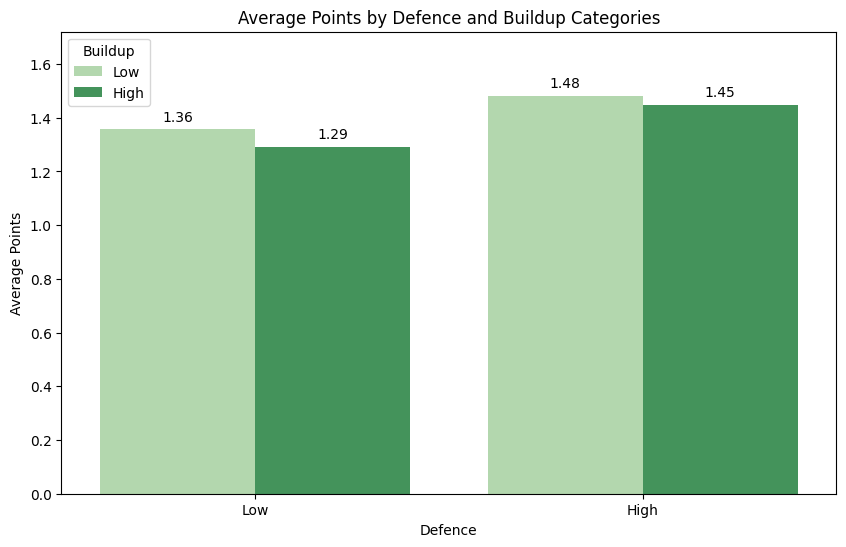

defence_category buildup_category      mean   size
0              Low              Low  1.356338   9940
1              Low             High  1.289413  12204
2             High              Low  1.481341   7396
3             High             High  1.448504  10292

In [102]:
grouped_data = (
    tendencies_df.groupby(["defence_category", "buildup_category"])["points"]
    .agg(["mean", "size"])
    .reset_index()
)

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    x="defence_category",
    y="mean",
    hue="buildup_category",
    data=grouped_data,
    palette="Greens",
)
plt.title("Average Points by Defence and Buildup Categories")
plt.ylabel("Average Points")
plt.ylim(0, 1.72)
plt.xlabel("Defence")
plt.legend(title="Buildup", loc="best")

for p in bar_plot.patches:
    bar_plot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.show()

display(grouped_data)

Despite the results of the hypothesis testing, we see that the combination of High Defence and Low Buildup tendencies have the most points on average.


# 4. Prediction Models


## 4.1. Can we predict how many goals each team will score in each match?


### 4.1.1. Preparing the data

Before training our model, we need to:

- add desider values from **teams** and **players** dataframes, such as team tendencies and average player overall ratings
- add aggregated values, such as season points and average goals scored
- deal with missing values
- split the dataset to training and testing


#### Adding **Teams** data


In [103]:
match_data = merge_team_data(
    match_data,
    teams,
    [
        "buildUpPlaySpeed",
        "buildUpPlayPassing",
        "chanceCreationPassing",
        "chanceCreationCrossing",
        "chanceCreationShooting",
        "defencePressure",
        "defenceAggression",
        "defenceTeamWidth",
    ],
)
match_data.head(1)

country_id  league_id     season  stage       date  match_api_id  \
match_id                                                                     
2                  1          1  2008/2009      1 2008-08-16        492474   

          home_team_id  away_team_id  home_team_goal  away_team_goal  \
match_id                                                               
2                10000          9994               0               0   

          home_player_X1  home_player_X2  home_player_X3  home_player_X4  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   

          home_player_X5  home_player_X6  home_player_X7  home_player_X8  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   

          home_player_X9  home_player_X10  home_player_X11  away_player_X1  \
match_id                                                                     
2                    NaN              NaN              NaN             NaN   

          away_player_X2  away_player_X3  away_player_X4  away_player_X5  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   

          away_player_X6  away_player_X7  away_player_X8  away_player_X9  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   

          away_player_X10  away_player_X11  home_player_Y1  home_player_Y2  \
match_id                                                                     
2                     NaN              NaN             NaN             NaN   

          home_player_Y3  home_player_Y4  home_player_Y5  home_player_Y6  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   

          home_player_Y7  home_player_Y8  home_player_Y9  home_player_Y10  \
match_id                                                                    
2                    NaN             NaN             NaN              NaN   

          home_player_Y11  away_player_Y1  away_player_Y2  away_player_Y3  \
match_id                                                                    
2                     NaN             NaN             NaN             NaN   

          away_player_Y4  away_player_Y5  away_player_Y6  away_player_Y7  \
match_id                                                                   
2                    NaN             NaN             NaN             NaN   

          away_player_Y8  away_player_Y9  away_player_Y10  away_player_Y11  \
match_id                                                                     
2                    NaN             NaN              NaN              NaN   

          home_player_1  home_player_2  home_player_3  home_player_4  \
match_id                                                               
2                   NaN            NaN            NaN            NaN   

          home_player_5  home_player_6  ...  goal  shoton  shotoff  \
match_id                                ...                          
2                   NaN            NaN  ...  None    None     None   

          foulcommit  card  cross  corner  possession  B365H  B365D  B365A  \
match_id                                                                     
2               None  None   None    None        None   1.95    3.2    3.6   

          BWH  BWD   BWA  IWH  IWD  IWA  LBH  LBD  LBA PSH PSD PSA   WHH  WHD  \
match_id                                                                        
2         1.8  3.3  3.95  1.9  3.2  3.5  1.9  3.2  3.5 NaN NaN NaN  1.83  3.3   

          WHA   SJH  SJD  SJA  VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD  \
match_id                    

#### Adding **Players** data


In [104]:
# presorting in dictionary for efficient lookups
players_dict_sorted = {}
for player_id, group in players.groupby("player_id"):
    players_dict_sorted[player_id] = group.sort_values(by="date")

In [105]:
def get_player_attribute_list(match_row, player_columns, attribute="overall_rating"):
    attribute_values = []

    for col in player_columns:
        player_id = match_row[col]
        player_date = match_row["date"]

        player_data = players_dict_sorted.get(player_id)
        if player_data is not None:
            idx = bisect.bisect_left(player_data["date"].values, player_date)
            if idx > 0:
                latest_entry = player_data.iloc[idx - 1]
                attribute_value = latest_entry[attribute]
                if not pd.isna(attribute_value):
                    attribute_values.append(attribute_value)

    return attribute_values

In [106]:
def safe_aggregate(lst, func):
    return None if len(lst) <= 5 else func(lst)

In [107]:
for side in ["home", "away"]:
    print(f"Finished aggregating {side}:", end=" ")

    player_columns = [f"{side}_player_{i}" for i in range(1, 12)]

    match_data[f"{side}_avg_ovr"] = match_data.apply(
        lambda row: safe_aggregate(
            get_player_attribute_list(row, player_columns, attribute="overall_rating"),
            np.mean,
        ),
        axis=1,
    )
    print("avg_overall", end=", ")

    # [Attacking : Defending]
    for attribute in list(attribute_categories.keys())[:-1]:
        col = f"{side}_{attribute.lower()}"
        match_data[col] = match_data.apply(
            lambda row: safe_aggregate(
                get_player_attribute_list(row, player_columns, attribute=attribute),
                np.mean,
            ),
            axis=1,
        )
        print(attribute.lower(), end=", ")

    # goalkeeping is max() instead of avg
    match_data[f"{side}_goalkeeping"] = match_data.apply(
        lambda row: safe_aggregate(
            get_player_attribute_list(
                row, home_player_columns, attribute="Goalkeeping"
            ),
            max,
        ),
        axis=1,
    )

    print("goalkeeping.")

Finished aggregating home: 

avg_overall, attacking, skill, movement, power, mentality, defending, goalkeeping.
Finished aggregating away: avg_overall, attacking, skill, movement, power, mentality, defending, goalkeeping.


In [108]:
# removing values where goalkeeping is assigned from other players thaan goalkeepers
match_data.loc[match_data["home_goalkeeping"] < 40, "home_goalkeeping"] = np.nan
match_data.loc[match_data["away_goalkeeping"] < 40, "away_goalkeeping"] = np.nan

In [109]:
attributes = [
    "avg_ovr",
    "attacking",
    "skill",
    "movement",
    "power",
    "mentality",
    "defending",
    "goalkeeping",
]
attribute_cols = []

for att in attributes:
    for side in ["home", "away"]:
        attribute_cols.append(f"{side}_{att}")

match_data[attribute_cols].describe()

home_avg_ovr  away_avg_ovr  home_attacking  away_attacking  \
count  24896.000000  24897.000000    24896.000000    24897.000000   
mean      71.083235     71.009668       55.881636       55.750577   
std        5.869715      5.859212        5.165377        5.156052   
min       52.333333     52.500000       37.533333       38.333333   
25%       66.700000     66.636364       52.200000       52.109091   
50%       71.636364     71.545455       55.927273       55.763636   
75%       75.090909     75.000000       59.454545       59.309091   
max       86.636364     87.272727       70.681818       70.736364   

         home_skill    away_skill  home_movement  away_movement    home_power  \
count  24896.000000  24897.000000   24896.000000   24897.000000  24896.000000   
mean      57.354952     57.215989      67.465235      67.383983     64.637859   
std        5.389817      5.359301       4.102218       4.089864      4.207048   
min       35.600000     37.133333      49.300000      50.428571     48.657143   
25%       53.600000     53.518182      64.654545      64.581818     61.822727   
50%       57.345455     57.200000      67.436364      67.381818     64.909091   
75%       61.109091     60.927273      70.290909      70.169697     67.581818   
max       74.745455     73.854545      80.440000      80.181818     78.836364   

         away_power  home_mentality  away_mentality  home_defending  \
count  24897.000000    24896.000000    24897.000000    24896.000000   
mean      64.594952       58.929692       58.898545       52.187721   
std        4.216919        6.345343        6.346768        4.992176   
min       49.650000       40.285714       40.628571       29.555556   
25%       61.763636       54.490909       54.436364       48.727273   
50%       64.854545       58.400000       58.381818       52.090909   
75%       67.540909       62.672727       62.654545       55.727273   
max       78.872727       82.472727       82.654545       71.266667   

       away_defending  home_goalkeeping  away_goalkeeping  
count    24897.000000      24630.000000      24630.000000  
mean        52.493040         72.015997         72.015997  
std          5.066745          7.071068          7.071068  
min         27.666667         43.200000         43.200000  
25%         48.939394         67.000000         67.000000  
50%         52.393939         72.600000         72.600000  
75%         56.121212         77.400000         77.400000  
max         72.500000         89.800000         89.800000

#### Aggregated values

We will start by computing a running average of points earned per game this season.


In [110]:
def compute_running_avg_points(df):
    # Reshape the data
    home_data = df[["home_team_id", "home_team_points", "date", "season"]].rename(
        columns={"home_team_id": "team_id", "home_team_points": "team_points"}
    )
    away_data = df[["away_team_id", "away_team_points", "date", "season"]].rename(
        columns={"away_team_id": "team_id", "away_team_points": "team_points"}
    )

    all_teams_data = pd.concat([home_data, away_data])

    # Sort and compute the cumulative sum
    all_teams_data = all_teams_data.sort_values(["team_id", "season", "date"])
    all_teams_data["cum_points"] = (
        all_teams_data.groupby(["team_id", "season"])["team_points"].cumsum()
        - all_teams_data["team_points"]
    )
    all_teams_data["match_count"] = all_teams_data.groupby(
        ["team_id", "season"]
    ).cumcount()
    all_teams_data["avg_points"] = np.where(
        all_teams_data["match_count"] == 0,
        0.0,
        all_teams_data["cum_points"] / all_teams_data["match_count"],
    )

    # Merge back with the original data
    df = pd.merge(
        df,
        all_teams_data[["team_id", "date", "avg_points"]],
        left_on=["home_team_id", "date"],
        right_on=["team_id", "date"],
    )
    df = df.rename(columns={"avg_points": "home_avg_points"}).drop(columns="team_id")

    df = pd.merge(
        df,
        all_teams_data[["team_id", "date", "avg_points"]],
        left_on=["away_team_id", "date"],
        right_on=["team_id", "date"],
    )
    df = df.rename(columns={"avg_points": "away_avg_points"}).drop(columns="team_id")

    return df

In [111]:
test_match = pd.DataFrame(
    {
        "home_team_id": [1, 2, 1, 2, 1, 2, 1, 2],
        "away_team_id": [2, 1, 3, 3, 2, 1, 3, 3],
        "home_team_points": [3, 0, 1, 3, 3, 0, 1, 3],
        "away_team_points": [0, 3, 1, 0, 0, 3, 1, 0],
        "date": [
            "2021-01-01",
            "2021-01-02",
            "2021-01-03",
            "2021-01-04",
            "2021-01-05",
            "2022-01-01",
            "2022-01-02",
            "2022-01-03",
        ],
        "season": ["2021", "2021", "2021", "2021", "2021", "2022", "2022", "2022"],
    }
)

result = compute_running_avg_points(test_match)
display(result)

assert result.loc[0, "home_avg_points"] == 0.0
assert result.loc[0, "away_avg_points"] == 0.0
assert result.loc[1, "home_avg_points"] == 0.0
assert result.loc[1, "away_avg_points"] == 3.0
assert result.loc[4, "home_avg_points"] == 7 / 3
assert result.loc[4, "away_avg_points"] == 1.0
assert result.loc[5, "home_avg_points"] == 0.0
assert result.loc[5, "away_avg_points"] == 0.0
assert result.loc[6, "home_avg_points"] == 3.0
assert result.loc[7, "away_avg_points"] == 1.0

home_team_id  away_team_id  home_team_points  away_team_points        date  \
0             1             2                 3                 0  2021-01-01   
1             2             1                 0                 3  2021-01-02   
2             1             3                 1                 1  2021-01-03   
3             2             3                 3                 0  2021-01-04   
4             1             2                 3                 0  2021-01-05   
5             2             1                 0                 3  2022-01-01   
6             1             3                 1                 1  2022-01-02   
7             2             3                 3                 0  2022-01-03   

  season  home_avg_points  away_avg_points  
0   2021         0.000000              0.0  
1   2021         0.000000              3.0  
2   2021         3.000000              0.0  
3   2021         0.000000              1.0  
4   2021         2.333333              1.0  
5   2022         0.000000              0.0  
6   2022         3.000000              0.0  
7   2022         0.000000              1.0

In [112]:
match_data = compute_running_avg_points(match_data)

Now we are adding the moving average of goals scored per game. We are using 5 last games for this metric.


In [113]:
def compute_rolling_avg_goals(match_data, n_games):
    # avg for fillna
    home_avg = match_data.home_team_goal.mean()
    away_avg = match_data.away_team_goal.mean()

    # Melting DataFrame to long-format
    home_data = match_data[["home_team_id", "home_team_goal", "date"]].rename(
        columns={"home_team_id": "team_id", "home_team_goal": "goals"}
    )
    away_data = match_data[["away_team_id", "away_team_goal", "date"]].rename(
        columns={"away_team_id": "team_id", "away_team_goal": "goals"}
    )

    all_teams_data = pd.concat([home_data, away_data], axis=0).sort_values(by="date")

    # Compute the rolling average of goals scored over the past n_games
    all_teams_data["rolling_avg_goals"] = all_teams_data.groupby("team_id")[
        "goals"
    ].transform(lambda x: x.shift().rolling(window=n_games).mean())

    # Merge back to the original data
    match_data = pd.merge(
        match_data,
        all_teams_data[["date", "team_id", "rolling_avg_goals"]],
        how="left",
        left_on=["date", "home_team_id"],
        right_on=["date", "team_id"],
    )
    match_data = match_data.rename(
        columns={"rolling_avg_goals": f"home_{n_games}avg_goals"}
    ).drop(columns="team_id")

    # Fill NaN values in the home team rolling average column with home_avg
    match_data[f"home_{n_games}avg_goals"].fillna(home_avg, inplace=True)

    match_data = pd.merge(
        match_data,
        all_teams_data[["date", "team_id", "rolling_avg_goals"]],
        how="left",
        left_on=["date", "away_team_id"],
        right_on=["date", "team_id"],
    )
    match_data = match_data.rename(
        columns={"rolling_avg_goals": f"away_{n_games}avg_goals"}
    ).drop(columns="team_id")

    # Fill NaN values in the away team rolling average column with away_avg
    match_data[f"away_{n_games}avg_goals"].fillna(away_avg, inplace=True)

    return match_data

In [114]:
match_data = compute_rolling_avg_goals(match_data, 5)

assert (
    match_data.loc[
        (match_data["date"] == "2008-09-20") & (match_data["home_team_id"] == 7947),
        "home_5avg_goals",
    ].values[0]
    == match_data.home_team_goal.mean()
)
assert (
    match_data.loc[
        (match_data["date"] == "2008-10-25") & (match_data["away_team_id"] == 10000),
        "away_5avg_goals",
    ].values[0]
    == 1.6
)

### 4.1.2. Building the model


In [115]:
correlation_coefficient = match_data["home_team_goal"].corr(
    match_data["away_team_goal"]
)
print(f"{correlation_coefficient:.4f}")

-0.0641


Since there doens't seem to be any correlation between home and away goals, we will be building separate linear models, to predict the amount of goals. We will start with the home team.

To begin with, let's take a look at the distribution of home_team_goals.


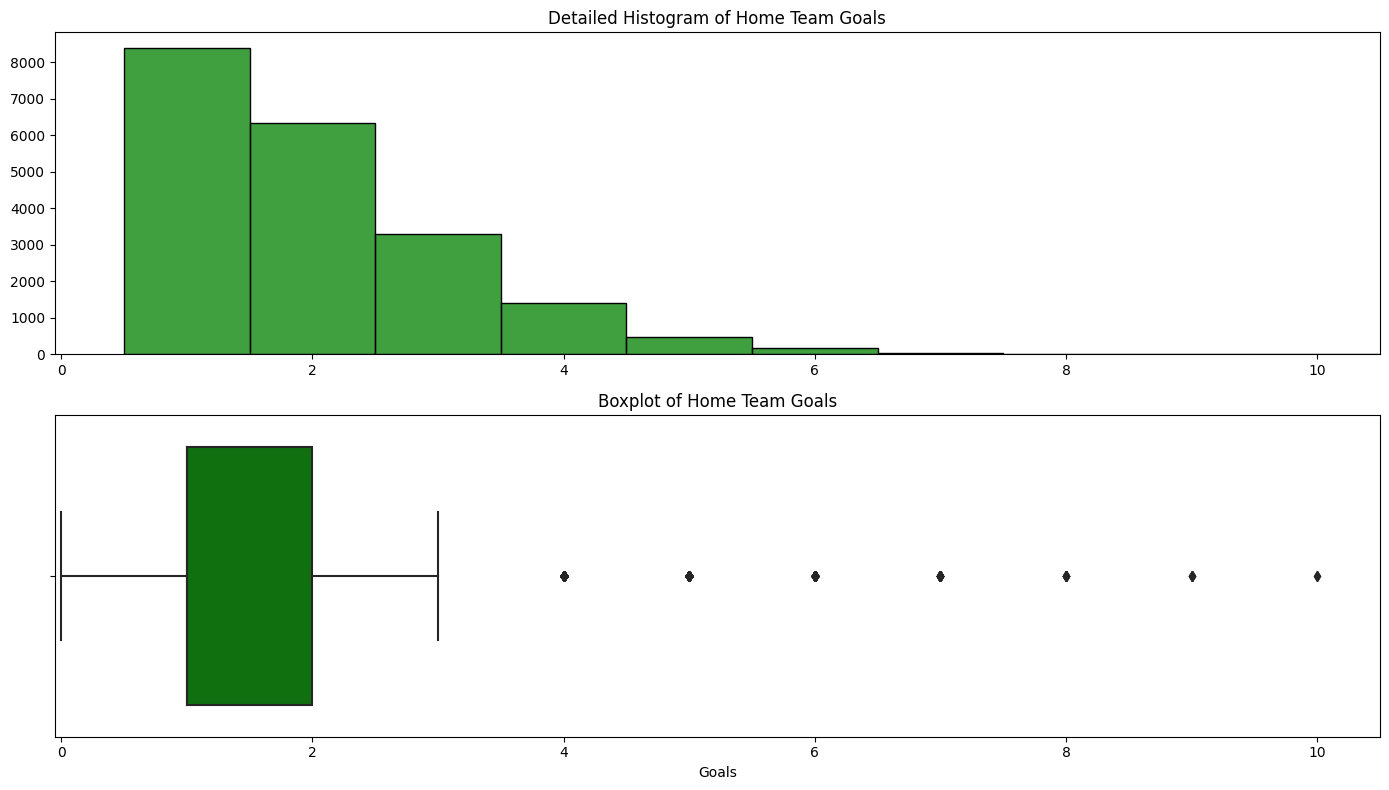

In [116]:
f, axes = plt.subplots(2, 1, figsize=(14, 8))
plt.sca(axes[0])

my.plot_detailed_histogram(match_data["home_team_goal"], color="green")
axes[0].set_title("Detailed Histogram of Home Team Goals")
axes[0].set_xlim(-0.05, 10.5)


plt.sca(axes[1])

sns.boxplot(x=match_data["home_team_goal"], color="green")
axes[1].set_title("Boxplot of Home Team Goals")
axes[1].set_xlabel("Goals")
axes[1].set_xlim(-0.05, 10.5)

plt.tight_layout()
plt.show()

In [117]:
team_tend_cols = [
    "home_team_buildUpPlaySpeed",
    "home_team_buildUpPlayPassing",
    "home_team_chanceCreationPassing",
    "home_team_chanceCreationCrossing",
    "home_team_chanceCreationShooting",
    "home_team_defencePressure",
    "home_team_defenceAggression",
    "home_team_defenceTeamWidth",
    "away_team_buildUpPlaySpeed",
    "away_team_buildUpPlayPassing",
    "away_team_chanceCreationPassing",
    "away_team_chanceCreationCrossing",
    "away_team_chanceCreationShooting",
    "away_team_defencePressure",
    "away_team_defenceAggression",
    "away_team_defenceTeamWidth",
]

In [118]:
goal_outlier = 7

df = match_data[
    (match_data["home_team_goal"] < goal_outlier)
    & (match_data["away_team_goal"] < goal_outlier)
].copy()  # removing outliers

# not needed columns
cols_to_drop = (
    [
        "stage",
        "goal_data",
        "goal",
        "shoton",
        "shotoff",
        "foulcommit",
        "card",
        "cross",
        "corner",
        "possession",
        "date",
        "total_goals",
        "win_margin",
        "winner",
        "home_team_points",
        "away_team_points",
    ]
    + list(bet_cols)
    + team_tend_cols
)

# id columns
for col in match_data.columns:
    if "_id" in col:
        cols_to_drop.append(col)

# player columns
for side in ["home", "away"]:
    for i in range(1, 12):
        cols_to_drop.append(f"{side}_player_{i}")
        cols_to_drop.append(f"{side}_player_X{i}")
        cols_to_drop.append(f"{side}_player_Y{i}")

df = df.drop(columns=cols_to_drop)
df = df.dropna()
df.shape

(24416, 23)

#### Checking for Linear relationship


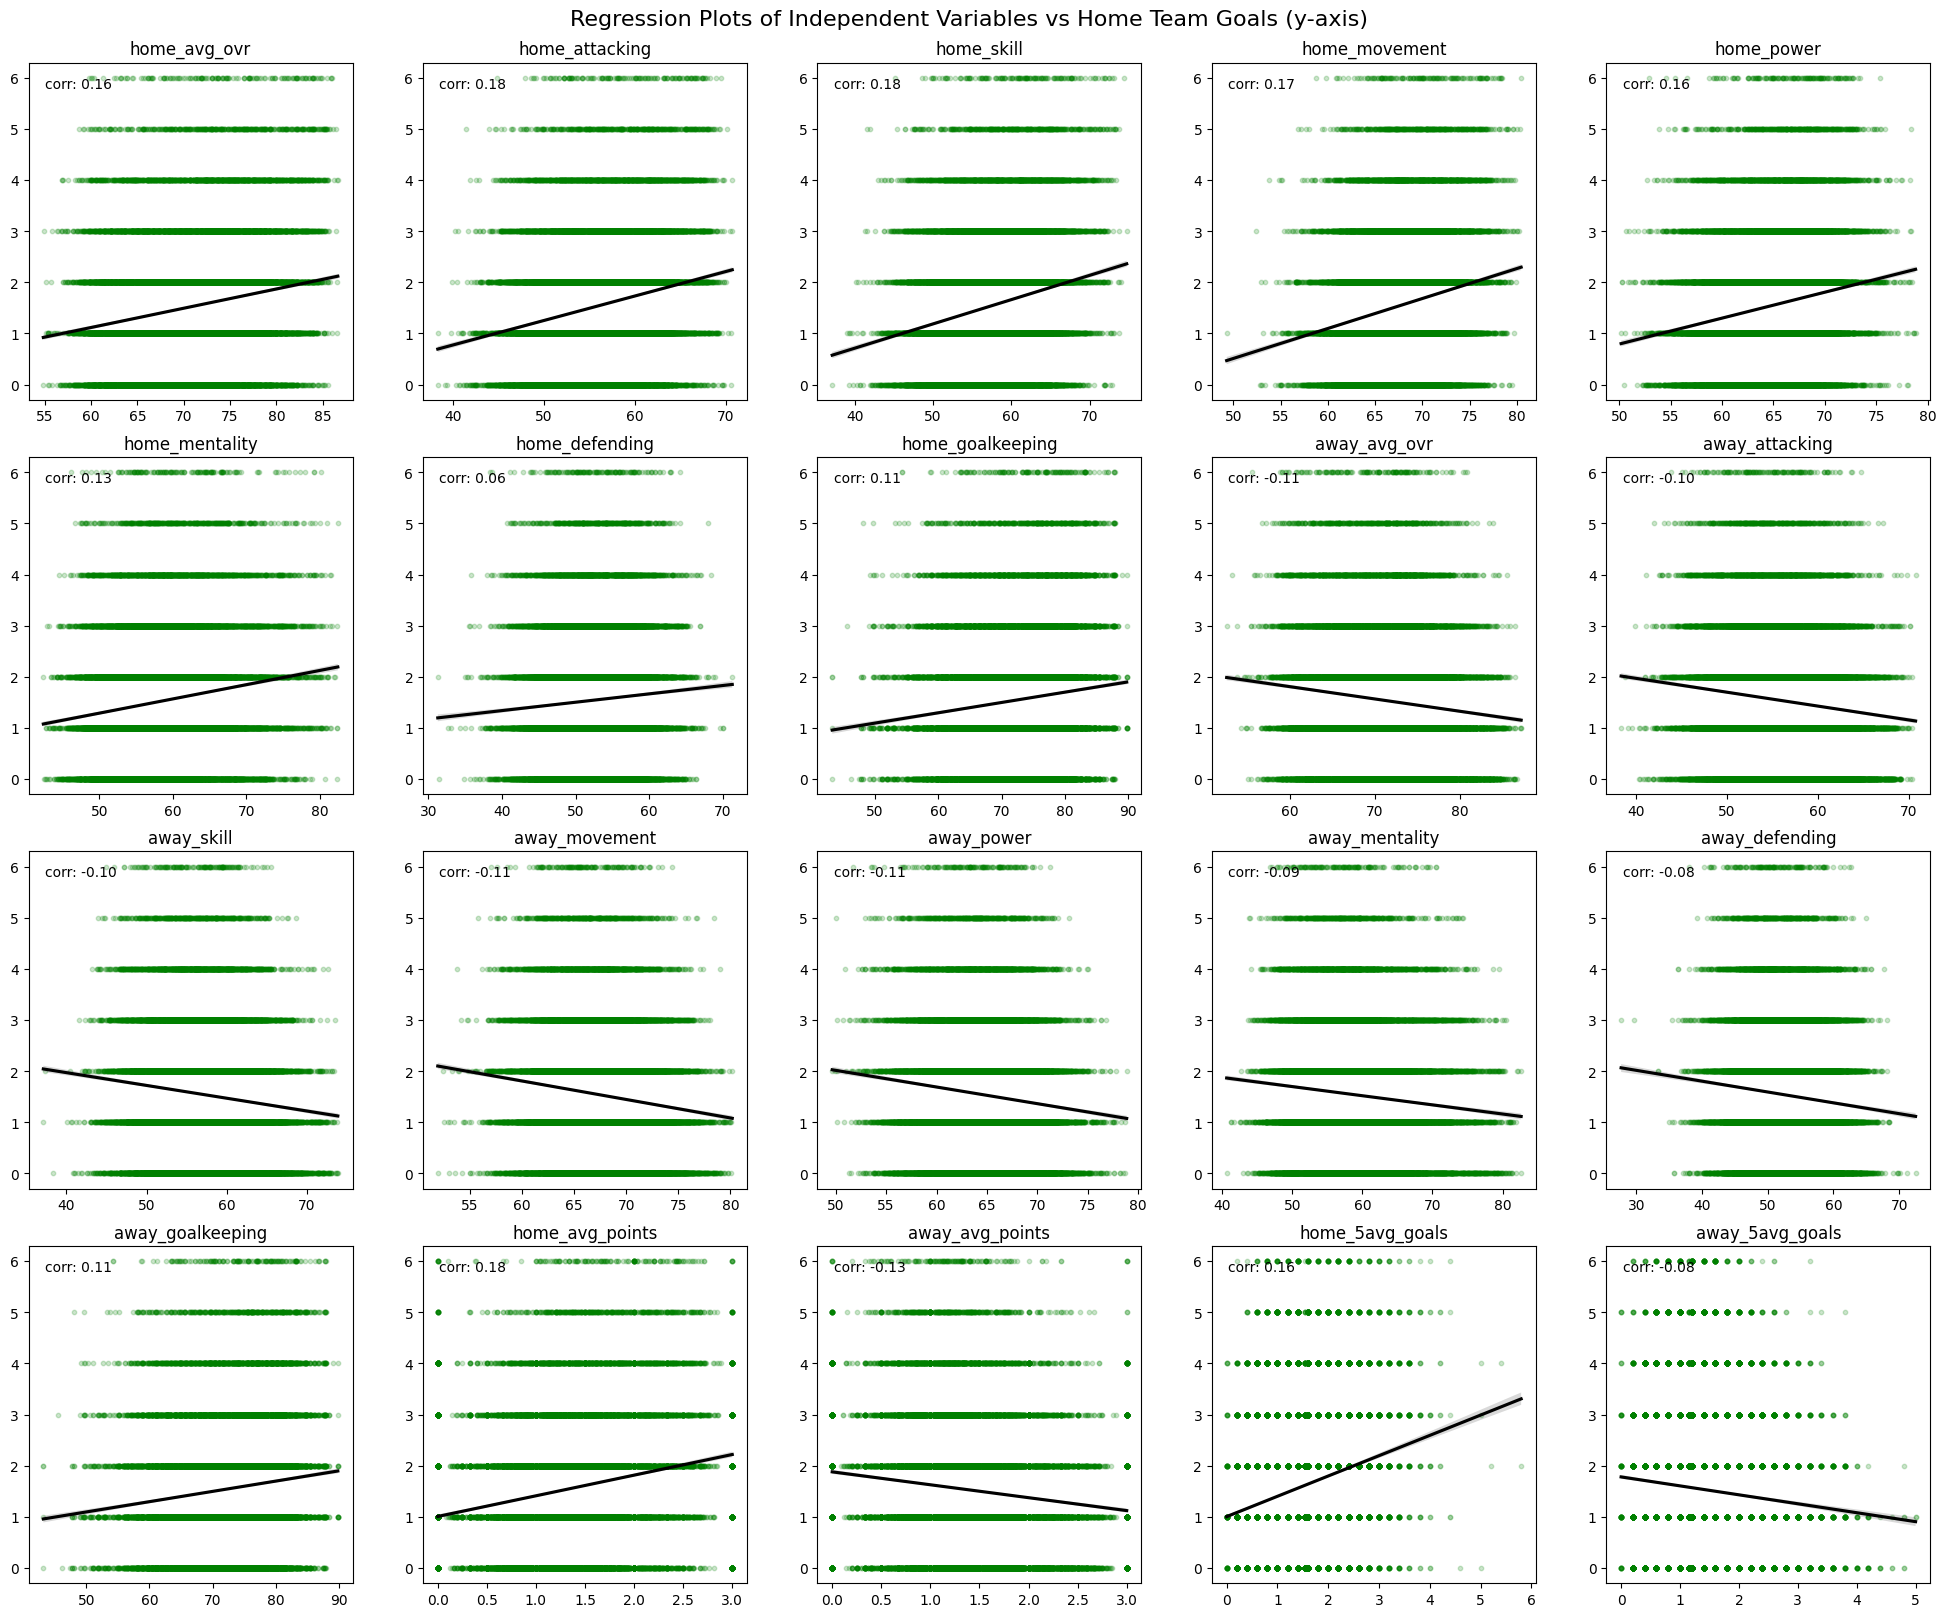

In [119]:
dependent_var = "home_team_goal"
excluded_columns = ["season", "away_team_goal", dependent_var]

independent_vars = [col for col in df.columns if col not in excluded_columns]

ncols = 5
nrows = 5


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
fig.tight_layout(pad=2.0)
fig.suptitle(
    "Regression Plots of Independent Variables vs Home Team Goals (y-axis)",
    fontsize=16,
    y=1.01,
)


for idx, var in enumerate(independent_vars):
    ax = axes[idx // ncols, idx % ncols]
    sns.regplot(
        x=var,
        y=dependent_var,
        data=df,
        scatter_kws={"s": 10, "alpha": 0.2},
        line_kws={"color": "black"},
        ax=ax,
        color="green",
    )
    # Using Spearman's Rank Correlation, as values are discrete
    corr_val = df[var].corr(df[dependent_var], method="spearman")
    ax.annotate(
        f"corr: {corr_val:.2f}",
        xy=(0.05, 0.925),
        xycoords="axes fraction",
        fontsize=10,
        color="black",
    )
    ax.set_title(var)
    ax.set_xlabel("")
    ax.set_ylabel("")

# removing unused grids
if len(independent_vars) < nrows * ncols:
    for idx in range(len(independent_vars), nrows * ncols):
        fig.delaxes(axes.flatten()[idx])

plt.show()

Unfortunately, none of our engineered variables seem to have a strong correlation or linear relationship with our value of interest (home team goals scored). Therefore, expectations for predicting goals accurately falls even lower.

Let's check correlation between our variables to avoid multicollinearity in the future.


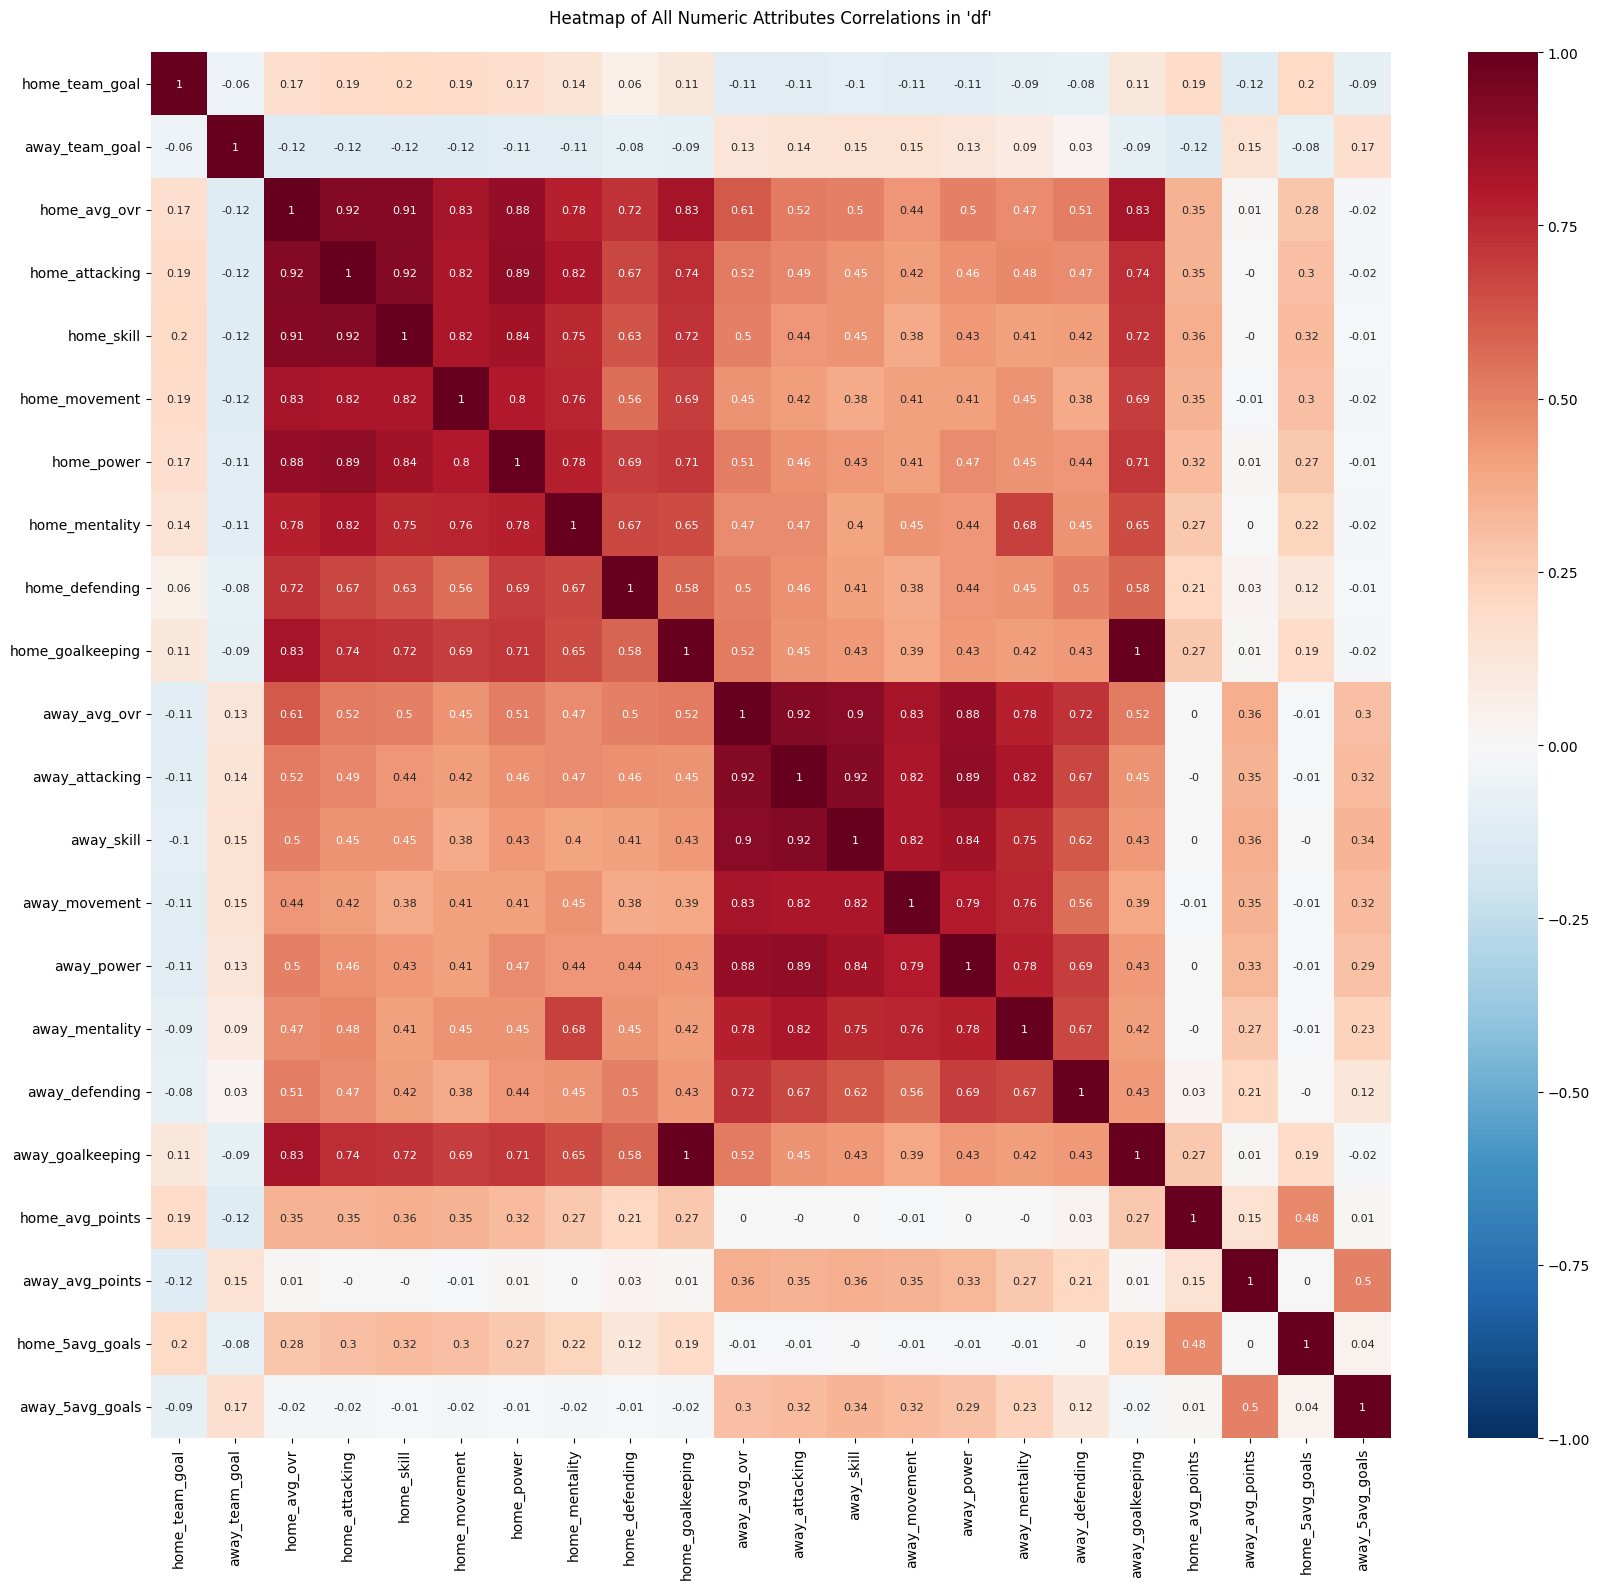

In [120]:
numeric_columns = df.select_dtypes(include="number").columns

corr_matrix = df[numeric_columns].corr()
corr_matrix = corr_matrix.round(2)

plt.figure(figsize=(20, 18))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    annot_kws={"fontsize": 8},
)

plt.title("Heatmap of All Numeric Attributes Correlations in 'df'\n")
plt.show()

From the heatmap above, we see that there is some strong positive correlation. For instance, average overall ratings correlate strongly with the major category values. Therefore, we will be dropping the _avg_ovr_ columns.

Furthermore, _attacking_ and _skill_ features are very strongly correlated (>0.92), so we will be combining these values into one valued called "Offense". Both _attacking_ and _skill_ were computed from 5 features each in the players dataframe, so we can just take the average of these two columns to compute _offense_.


In [121]:
# for original dataframe
match_data["home_offense"] = match_data[["home_attacking", "home_skill"]].mean(axis=1)
match_data["away_offense"] = match_data[["away_attacking", "away_skill"]].mean(axis=1)

# for our current workign dataframe
df["home_offense"] = df[["home_attacking", "home_skill"]].mean(axis=1)
df["away_offense"] = df[["away_attacking", "away_skill"]].mean(axis=1)

In [122]:
df = df.drop(
    columns=[
        "home_avg_ovr",
        "away_avg_ovr",
        "home_attacking",
        "away_attacking",
        "home_skill",
        "away_skill",
    ]
)

Removing the following features, as they should not affect our model based on domain knowledge:

- home_goalkeeping
- home_defending
- away_offense
- away_5avg_goals


In [123]:
df_home = df.copy()
df_home = df_home.drop(
    columns=["home_goalkeeping", "home_defending", "away_offense", "away_5avg_goals"]
)
df_home.head(2)

season  home_team_goal  away_team_goal  home_movement  home_power  \
207  2008/2009               2               1      62.163636   59.068182   
208  2008/2009               1               1      61.733333   61.966667   

     home_mentality  away_movement  away_power  away_mentality  \
207       55.522727      66.163636   61.018182       59.690909   
208       56.866667      67.181818   65.054545       63.890909   

     away_defending  away_goalkeeping  home_avg_points  away_avg_points  \
207       47.242424              56.2         1.173913         1.739130   
208       56.333333              65.2         1.347826         2.304348   

     home_5avg_goals  home_offense  
207              2.6     49.865909  
208              0.6     49.866667

#### Spliting the data


In [124]:
train = df_home[df_home["season"] != "2015/2016"]
test = df_home[df_home["season"] == "2015/2016"]

In [125]:
X_train = train.drop(columns=["home_team_goal", "season"])
y_train = train["home_team_goal"]
X_test = test.drop(columns=["home_team_goal", "season"])
y_test = test["home_team_goal"]

lin_reg = LinearRegression()

In [126]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [127]:
cross_val_results = cross_val_score(
    lin_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
print("Cross-validation MSE scores:", -cross_val_results)
print("Cross-validation RMSE scores:", np.sqrt(-cross_val_results))
print("Average RMSE:", np.sqrt(-cross_val_results).mean())

Cross-validation MSE scores: [1.3371354  1.44659898 1.48390813 1.45991709 1.41406977]
Cross-validation RMSE scores: [1.15634571 1.20274643 1.21815768 1.20827029 1.18914666]
Average RMSE: 1.1949333534077036


The values are very high, considering football is a low scoring game. Nevertheless, we will try predicting with the features and data we currently have.


In [128]:
lin_reg.fit(X_train, y_train)

train_predictions = lin_reg.predict(X_train)
rounded_train_predictions = np.round(train_predictions)

train_accuracy = accuracy_score(y_train, rounded_train_predictions)
print("Training Accuracy:", train_accuracy)


train_mse = mean_squared_error(y_train, rounded_train_predictions)
print("Training MSE:", train_mse)


train_rmse = np.sqrt(train_mse)
print("Training RMSE:", train_rmse)

Training Accuracy: 0.31382953522528073
Training MSE: 1.5203486994835838
Training RMSE: 1.233024208798669


In [129]:
predictions = lin_reg.predict(X_test)
rounded_predictions = np.round(predictions)

accuracy = accuracy_score(y_test, rounded_predictions)
print("Accuracy:", accuracy)

mse = mean_squared_error(y_test, rounded_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

Accuracy: 0.3022061045633122
MSE: 1.5735871864611666
RMSE: 1.2544270351284552


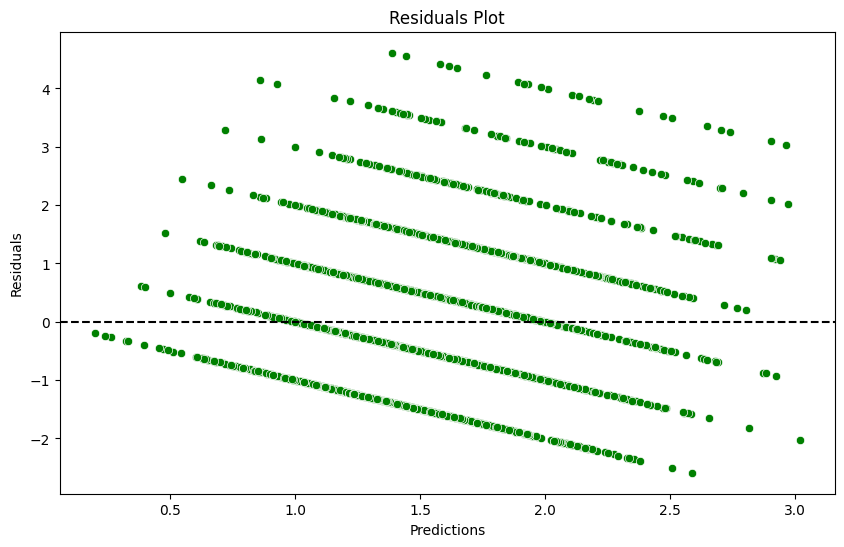

In [130]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals, color="green")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

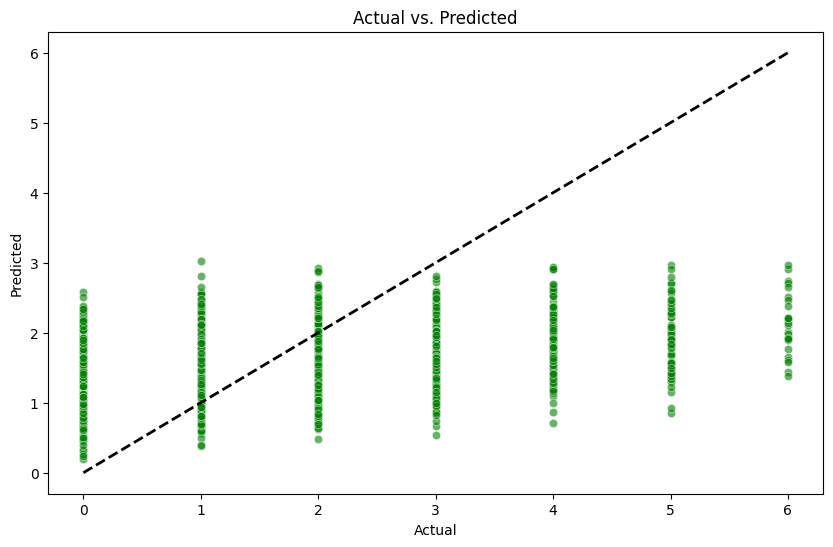

In [131]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")
plt.show()

Accuracy in the model is much too low, and the Root Mean Squared Error (RMSE) is very high with a value of 1.25 goals, indicating that we can't predict the number of goals scored by the home team with Linear Regression from the data we have and features selected.

Nevertheless, we will try at least increasing the accuracy by trying Polynomial regression.


In [132]:
degree = 3

poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X_train, y_train)

train_poly_predictions = poly_reg.predict(X_train)
rounded_train_poly_predictions = np.round(train_poly_predictions)

train_poly_mse = mean_squared_error(y_train, rounded_train_poly_predictions)
train_poly_rmse = np.sqrt(train_poly_mse)
train_poly_accuracy = accuracy_score(y_train, rounded_train_poly_predictions)

print("Polynomial Regression Training MSE:", train_poly_mse)
print("Polynomial Regression Training RMSE:", train_poly_rmse)
print("Polynomial Regression Training Accuracy:", train_poly_accuracy)

Polynomial Regression Training MSE: 1.4639219216373716
Polynomial Regression Training RMSE: 1.2099264116620363
Polynomial Regression Training Accuracy: 0.3218837352537073


In [133]:
poly_predictions = poly_reg.predict(X_test)
rounded_poly_predictions = np.round(poly_predictions)

poly_mse = mean_squared_error(y_test, rounded_poly_predictions)
poly_rmse = np.sqrt(poly_mse)
poly_accuracy = accuracy_score(y_test, rounded_poly_predictions)

print("Polynomial Regression Test MSE:", poly_mse)
print("Polynomial Regression Test RMSE:", poly_rmse)
print("Polynomial Regression Test Accuracy:", poly_accuracy)

Polynomial Regression Test MSE: 1.5908129344212754
Polynomial Regression Test RMSE: 1.2612743295656481
Polynomial Regression Test Accuracy: 0.3082502266545784


Even after using Polynomial Regregression (and testing with up to 5 degrees), the accuracy for the test data does not improve.

Therefore, we conclude that with limited time and data, it is most likely too big of a task to predict how many goals will the home team score in a given game. Different features should be engineered or different data should be gatherred in order to get better results. We will not be covering the same process with away team goals, and will be focusing on predicting match outcomes.


## 4.2. Can we predict which team will win the match?


In this section, we are building a Logistic Regression model for predicting match outcomes:

1.  Home (win)
2.  Draw
3.  Away (win)


In [134]:
print(
    f"Average competitors prediction accuracy: {season_accuracy_df['Accuracy'].mean():.6f}"
)
print(
    f"Average comp. pred. accuracy 2015/2016:  {season_accuracy_df[season_accuracy_df['Season']=='2015/2016']['Accuracy'].mean():.6f}"
)

print("Classification Report of Average Bookmaker Odds:\n")
print(comp_avg_metrics)

Average competitors prediction accuracy: 0.531519
Average comp. pred. accuracy 2015/2016:  0.518379
Classification Report of Average Bookmaker Odds:

              precision    recall  f1-score   support

        Home       0.54      0.75      0.63     11917
        Draw       0.26      0.14      0.18      6596
        Away       0.50      0.42      0.46      7466

    accuracy                           0.50     25979
   macro avg       0.44      0.43      0.42     25979
weighted avg       0.46      0.50      0.47     25979



As we saw in the Competitors Analysis, the average accuracy of betting odds is about 53.2%, with the mean accuracy for the 2015/2016 season being 51.8%.

These predictions were most likely made from the work of full data science teams. Therefore, our aim is to get as close as possible to these numbers and have a proof of concept model. Looking at the predictions of competitors, we can suspect that precision and accuracy is prioritized in building prediction models in the betting industry.

We will be evaluating our model based on:

- Accuracy (after balancing our dataset).
- Precision for each category.

First, we will be preparing our dataframe by removing:

1.  columns with values gathered _from/after the match_;
2.  _betting odds_ from other companies;
3.  _team tendencies_ columns, as they do not improve the metrics of the model after testing, and results in >23% the dataframe having missing values in rows.
4.  All _id_ columns, including player_ids, and their locations on the field as well.


In [135]:
df = match_data.copy()

# not needed columns
cols_to_drop = (
    [
        "stage",
        "goal_data",
        "goal",
        "shoton",
        "shotoff",
        "foulcommit",
        "card",
        "cross",
        "corner",
        "possession",
        "date",
        "total_goals",
        "win_margin",
        "home_team_goal",
        "away_team_goal",
        "home_team_points",
        "away_team_points",
    ]
    + list(bet_cols)
    + team_tend_cols
)

# id columns
for col in match_data.columns:
    if "_id" in col:
        cols_to_drop.append(col)

# player columns
for side in ["home", "away"]:
    for i in range(1, 12):
        cols_to_drop.append(f"{side}_player_{i}")
        cols_to_drop.append(f"{side}_player_X{i}")
        cols_to_drop.append(f"{side}_player_Y{i}")


df = df.drop(columns=cols_to_drop)
df = df.dropna()
df.shape

(24483, 24)

Before building the model, we need to check for multicollinearity. We must exclude values with infinite VIF scores, and values of above 5-10 VIF should be considered for dropping due to multicollinearity.


In [136]:
high_vif_cols = [
    "home_skill",
    "away_skill",
    "home_attacking",
    "away_attacking",
    "home_avg_ovr",
    "away_avg_ovr",
    "home_goalkeeping",
    "away_goalkeeping",
    "home_mentality",
    "away_mentality",
]

features = df.drop(columns=["winner", "season"] + high_vif_cols)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [
    variance_inflation_factor(features_scaled, i)
    for i in range(features_scaled.shape[1])
]


print(vif_data.sort_values(by="VIF", ascending=False))

            Feature       VIF
10     home_offense  6.541718
11     away_offense  6.507144
1        home_power  5.465888
4        away_power  5.454200
0     home_movement  3.733666
3     away_movement  3.686319
2    home_defending  2.185630
5    away_defending  2.180762
7   away_avg_points  1.584216
6   home_avg_points  1.555303
9   away_5avg_goals  1.454435
8   home_5avg_goals  1.397630


In [137]:
df = df.drop(columns=high_vif_cols)

train_data = df[df["season"] != "2015/2016"]
test_data = df[df["season"] == "2015/2016"]

X_train = train_data.drop(columns=["winner", "season"])
y_train = train_data["winner"].map({"Home": 0, "Draw": 1, "Away": 2})

X_test = test_data.drop(columns=["winner", "season"])
y_test = test_data["winner"].map({"Home": 0, "Draw": 1, "Away": 2})

In [138]:
df.winner.value_counts()

Home    11226
Away     7037
Draw     6220
Name: winner, dtype: int64

We have an unbalanced distribution of categories. In order to avoid information loss, we will use oversampling to deal with the lower representation of _Draw_ and _Away_ outcomes.


In [139]:
# Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(multi_class='multinomial')

In [140]:
train_predictions = model.predict(X_train_scaled)

train_report = classification_report(
    y_train_resampled, train_predictions, target_names=outcomes
)

print("Classification Report (Training data):\n\n", train_report)

Classification Report (Training data):

               precision    recall  f1-score   support

        Home       0.49      0.56      0.52      9770
        Draw       0.39      0.25      0.31      9770
        Away       0.48      0.57      0.52      9770

    accuracy                           0.46     29310
   macro avg       0.45      0.46      0.45     29310
weighted avg       0.45      0.46      0.45     29310



In [141]:
predictions = model.predict(X_test_scaled)

report = classification_report(y_test, predictions, target_names=outcomes)

print("Classification Report for Test Data (2015/2016):\n\n", report)

Classification Report for Test Data (2015/2016):

               precision    recall  f1-score   support

        Home       0.58      0.54      0.56      1456
        Draw       0.31      0.29      0.30       854
        Away       0.46      0.53      0.49      1008

    accuracy                           0.47      3318
   macro avg       0.45      0.45      0.45      3318
weighted avg       0.47      0.47      0.47      3318



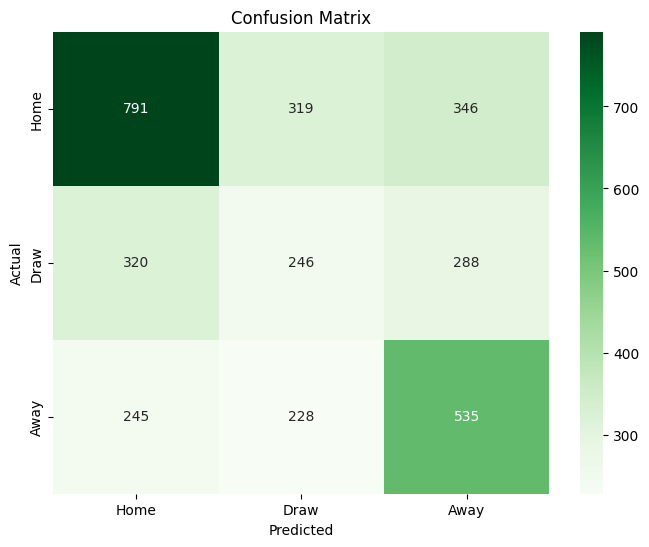

In [142]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Greens", xticklabels=outcomes, yticklabels=outcomes
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#### Summary of the resutls

With limited resources and imcomplete data we were able to get a model that has better accuracy than random (33.3%) and slighlt higher than just guessing the most likely option (Home: 45.9%). The results are not that far from the average of bookmaker odds, but looking at individual Classigication reports like the one fro B365, there is a lot of room for improvement. The precision of the model is still quite problematic, as the precision for Draws is lower than other categories. Nevertheless, the results are satisfactory as an initial proof of concept.


In [143]:
print("Classification Report of B365:\n")
print(classification_reports["B365"])

print("Classification Report of Average Bookmaker Odds:\n")
print(comp_avg_metrics)

Classification Report of B365:

              precision    recall  f1-score   support

        Home       0.54      0.86      0.67     10371
        Draw       0.57      0.00      0.01      5716
        Away       0.51      0.48      0.49      6505

    accuracy                           0.53     22592
   macro avg       0.54      0.45      0.39     22592
weighted avg       0.54      0.53      0.45     22592

Classification Report of Average Bookmaker Odds:

              precision    recall  f1-score   support

        Home       0.54      0.75      0.63     11917
        Draw       0.26      0.14      0.18      6596
        Away       0.50      0.42      0.46      7466

    accuracy                           0.50     25979
   macro avg       0.44      0.43      0.42     25979
weighted avg       0.46      0.50      0.47     25979



# 5. Summary and Conclusions

In **Exploratory Data Analysis** part of this notebook, we:

- 2.1. answered which leagues are in which countries. Furthermore, we compared the leagues by size and timeline:
  - Season starts in mid July-mid August, and ends in mid May for most leagues.
  - English, France, Spain and Italy leagues all have the most teams (20) and games (380) played during the season.
- 2.2. answered which leagues score the most and fewest goals:
  - per game, the Netherlands Eredivisie has the most goals scored with the average of 3.08 goals per game, while Polands' Ekstraklasa league has the least with 2.42.
  - in total, the Spain league has the most goals scored during the 2008-2016 time period with 8'412 goals, while Switzerland Super League had the least (4'166).
  - on average, 2.71 goals are scored per game, with the median value of 3.
- 2.3. computed dataframes for answering who are the top scorers by league and by team.
  - Lionel Messi had 281 goals scored in the Spain league, much higher than the Italy league's top scorer Antonio Di Natale with 147.
  - There was a lot of missing data for goals, so team and league goals for Netherlands, Switzerland, Scotland and Polant leagues are most likely inaccurate.
- 2.4. found out who were the champions of each league and each season.
  - Teams like FC Basel (Switzerland, 7 times), FC Barcelona (Spain, 6 times) and FC Bayern Munich (Germany, 5) dominate their respective national leagues quite consistently.
- 2.5 explored Team tendencies.
  - it seems that champion teams have higher defensive tendencies than average, and have lower buildup play tendencies, according to data from FIFA games.
- 2.6. explored Player attributes.
  - The average overall rating is ~69, and the distribution of ratings is normal.
  - Using k-means, we were able to cluster the players to 4 main positions based on FIFA attributes.
    - _Forwards_ and _Midfielders_ are shorter, weight less, and are faster than Defenders and Goalkeepers.
    - _Forwards_ have higher Attacking stats and low Defending stats, while _Midfielders_ have the most stamina of all positions.
    - _Defenders_ excell in Defending. From physical attributes, they excel in Strength.
    - _Goalkeepers_ are tallest. They are easy to distinguish based on stats, as only they have high Goalkeeping, while other stats are low.
- 2.7. looked at our competition.
  - None of the competitors offered odds on Poland league games.
  - Availability of odds vary by season and company.
  - From the odds offered, we evaluated how well our competition predict match outcomes:
    - All companies have similar accuracy in the range of 52.71%-53.34%. Companies SJ and B365 have the best accuracy.
    - **Accuracy** and balance in **precision** between categories seems to be valued when predicting match outcomes.
    - Looking at the **Overround** - the market seems to be increasing in competition, as the overround is getting lower over time.

In **Statistical Inference** part of this notebook, we tested the following hypothesis:

- 3.1. "Is there such a thing as home advantage?"
  - when looking at the proportions of wins by home team, it seems that **there is in fact a home court advantage**.
- 3.2. Teams with higher defensive tendencies and lower buildup tendencies are more likely to perform better.
  - Although higher defensive tendencies and lower buildupplay tendencies both correlate with better team performance separately, the combination of the two does not give better results than the sum of the benefits separately.

Furthermore, we tried building models for:

- 4.1. predicting goals scored by each team.
  - The results using linear regression were dissapointing. Most likely this is too big of a problem for the scope of this project.
  - Nevertheless, improvements could be made. Better (or just different) feature engineering and selection should lead to better results. Ordinal Logistic Regression also could be used.
- 4.2. predicting match outcomes.
  - Although still quite far from the predictions of our competitors, the logistic regression model is satisfactory for a proof concept.
  - The model can predict match outcomes with accuracy of about ~47%.
  - The main weakpoint of the model is precision of predicting Draws, as it's significantly lower than for other categories (~0.30).


## Potential improvements

For further exploration of the dataset, I recommend:

- **exploring team formations and player positions in the lineu-ups**. Most likely, different individual player stats are of different importance for different positions and formations. For example, most likely - shooting is much more important for Forwards, Defensive stats for Defenders, and passing for Midfielders, etc. This requires deeper domain knowledge of football, as well as additional data wrangling for the player coordinate columns (columns ex.: "home_player_X1", "home_player_Y1").
- **different feature engineering**. Taking the average of major categories does not influence predictions for team goals that well. Using player coordinates and positions to assign weight for computing the attributes could help in building a more accurate model. Different running averages could be used.
- **gathering more data** or **limiting the scope of the analysis by leagues**. For some leagues, we have a lot of missing data on **goals**. The analysis could be improved by filling in those holes, or limiting the scope of the analysis to leagues with more complete data (English, Spain leagues).
